# Contexte 


La société PJM est un opérateur de réseau de transport d'électricité du nord-est des Etats-Unis (RTO). Elle a pour obligation d'assurer la production d'énergie électrique afin de répondre à la demande des consommateurs et d'éviter un Blackout électrique.
Elle doit pour cela essayer de prévoir les besoins de maintenance des équipements actuels et d'investissements en nouveau générateur d'énergie (centrâle électrique, parc éolien, parc spolaire, ...).   

## Problématique 

Prédire la consommation d'énergie électrique dans la région sous le contrôle de la société PJM sur les 3 prochaines années.



# Import des librairies

In [1]:
#installation des librairies nécessaires

#!pip install pandas
#!pip install numpy
#!pip install sklearn
#!pip install pyarrow
#!pip install fastparquet
#!pip install matplotlib
#!pip install seaborn
#!pip install xgboost
#!pip install warnings

In [2]:
#Data analytics
import pandas as pd
import numpy as np
from numpy import asarray
from pandas import read_excel,read_csv
from pandas import DataFrame
from pandas import concat
from math import sqrt


# Librairies pour les modèles de prédiction
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA

#Librairies pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance, plot_tree, to_graphviz

# Librairies pour la gestion des dates et jours chômés
import holidays
import datetime
from datetime import date

plt.style.use('seaborn-pastel') 

# Import des données

In [3]:
data = pd.read_parquet('dataset\\est_hourly.parquet', engine='pyarrow')

# Analyse descriptive des données

#### Aperçu rapide des données

In [4]:
data.head()

AEP  COMED  DAYTON  DEOK  DOM  DUQ  EKPC  FE  NI  PJME  \
Datetime                                                                      
1998-12-31 01:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
1998-12-31 02:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
1998-12-31 03:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
1998-12-31 04:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
1998-12-31 05:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   

                     PJMW  PJM_Load  
Datetime                             
1998-12-31 01:00:00   NaN   29309.0  
1998-12-31 02:00:00   NaN   28236.0  
1998-12-31 03:00:00   NaN   27692.0  
1998-12-31 04:00:00   NaN   27596.0  
1998-12-31 05:00:00   NaN   27888.0

In [5]:
data.tail()

AEP    COMED  DAYTON    DEOK      DOM     DUQ  \
Datetime                                                                 
2018-01-01 20:00:00  21089.0  13858.0  2732.0  4426.0  18418.0  1962.0   
2018-01-01 21:00:00  20999.0  13758.0  2724.0  4419.0  18567.0  1940.0   
2018-01-01 22:00:00  20820.0  13627.0  2664.0  4355.0  18307.0  1891.0   
2018-01-01 23:00:00  20415.0  13336.0  2614.0  4224.0  17814.0  1820.0   
2018-01-02 00:00:00  19993.0  12816.0  2552.0  4100.0  17428.0  1721.0   

                       EKPC      FE  NI     PJME    PJMW  PJM_Load  
Datetime                                                            
2018-01-01 20:00:00  2866.0  9378.0 NaN  44284.0  8401.0       NaN  
2018-01-01 21:00:00  2846.0  9255.0 NaN  43751.0  8373.0       NaN  
2018-01-01 22:00:00  2883.0  9044.0 NaN  42402.0  8238.0       NaN  
2018-01-01 23:00:00  2880.0  8676.0 NaN  40164.0  7958.0       NaN  
2018-01-02 00:00:00  2846.0  8393.0 NaN  38608.0  7691.0       NaN

Les colonnes correspondent aux differents producteurs d'éléctricité qui fournissent l'opérateur PJM (RTO)

#### Dimensions du dataset

In [6]:
data.shape

(178262, 12)

#### Types des colonnes 

In [7]:
data.dtypes

AEP         float64
COMED       float64
DAYTON      float64
DEOK        float64
DOM         float64
DUQ         float64
EKPC        float64
FE          float64
NI          float64
PJME        float64
PJMW        float64
PJM_Load    float64
dtype: object

#### Statistiques descriptives

In [8]:
data.describe()

AEP         COMED         DAYTON          DEOK  \
count  121273.000000  66497.000000  121275.000000  57739.000000   
mean    15499.513717  11420.152112    2037.851140   3105.096486   
std      2591.399065   2304.139517     393.403153    599.859026   
min      9581.000000   7237.000000     982.000000    907.000000   
25%     13630.000000   9780.000000    1749.000000   2687.000000   
50%     15310.000000  11152.000000    2009.000000   3013.000000   
75%     17200.000000  12510.000000    2279.000000   3449.000000   
max     25695.000000  23753.000000    3746.000000   5445.000000   

                 DOM            DUQ          EKPC            FE            NI  \
count  116189.000000  119068.000000  45334.000000  62874.000000  58450.000000   
mean    10949.203625    1658.820296   1464.218423   7792.159064  11701.682943   
std      2413.946569     301.740640    378.868404   1331.268006   2371.498701   
min      1253.000000    1014.000000    514.000000      0.000000   7003.000000   
25%      9322.000000    1444.000000   1185.000000   6807.000000   9954.000000   
50%     10501.000000    1630.000000   1386.000000   7700.000000  11521.000000   
75%     12378.000000    1819.000000   1699.000000   8556.000000  12896.750000   
max     21651.000000    3054.000000   3490.000000  14032.000000  23631.000000   

                PJME           PJMW      PJM_Load  
count  145366.000000  143206.000000  32896.000000  
mean    32080.222831    5602.375089  29766.427408  
std      6464.012166     979.142872   5849.769954  
min     14544.000000     487.000000  17461.000000  
25%     27573.000000    4907.000000  25473.000000  
50%     31421.000000    5530.000000  29655.000000  
75%     35650.000000    6252.000000  33073.250000  
max     62009.000000    9594.000000  54030.000000

###  Analyse visuelle des données (distribution, densité, outliers)

#### Distribution des données

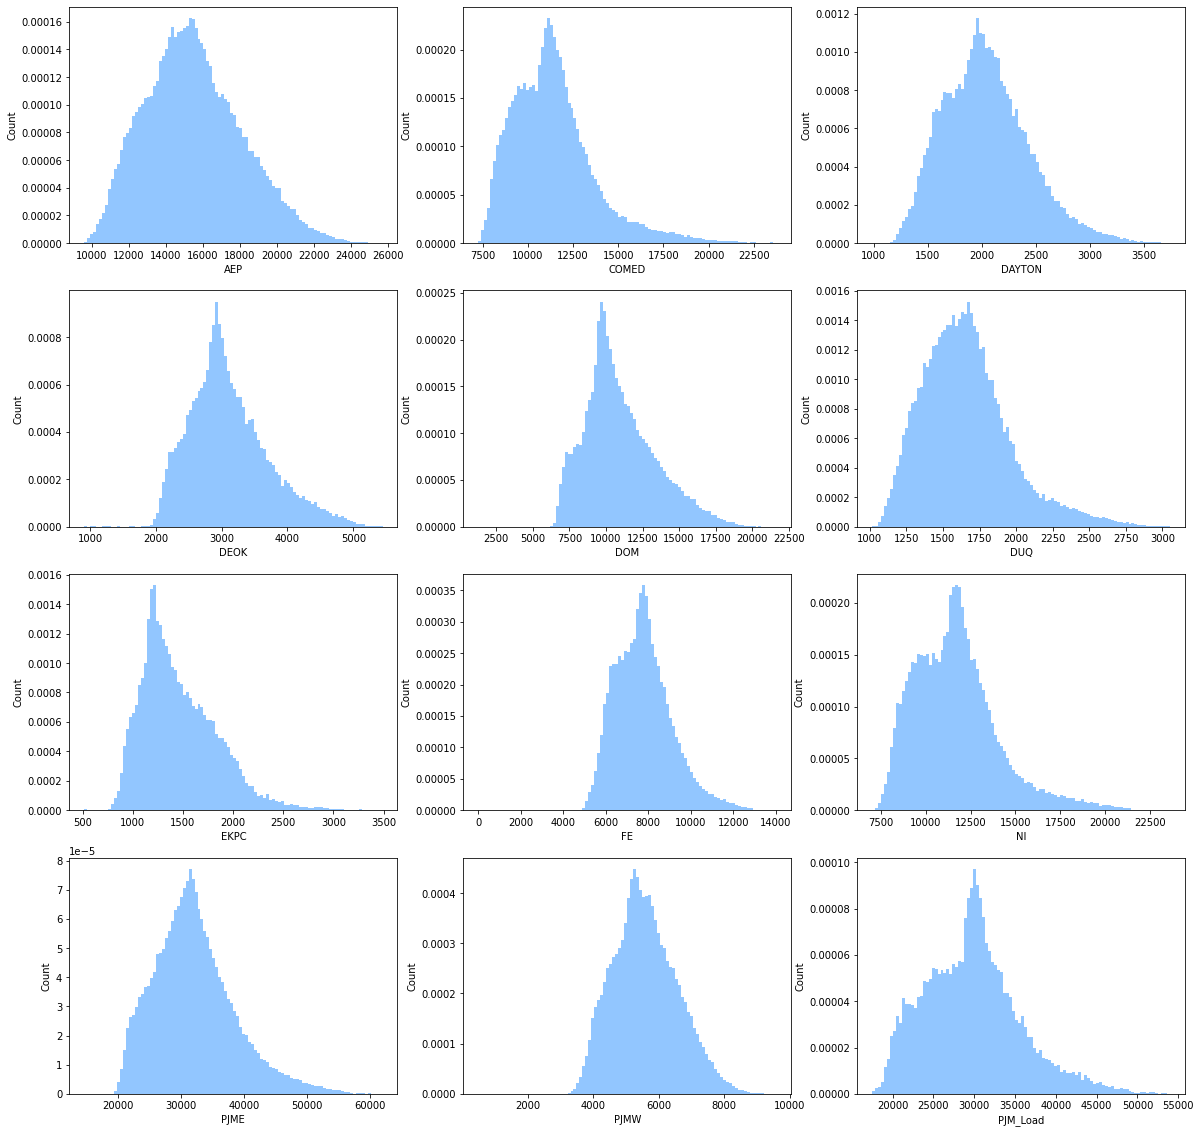

In [9]:
plt.figure(figsize = [20, 20])

for i,x in enumerate(data.columns):
    plt.subplot(4,3,i+1)
    plt.hist(data[x], bins = 100,density=True)
    plt.xlabel(x, fontsize=10)
    plt.ylabel('Count', fontsize=10)

Les données suivent une distribution normale avec une légère assymétrie positive.

#### Analyse de l'assymétrie des distributions

In [10]:
skew = data.skew()
print(skew)

AEP         0.378998
COMED       1.161846
DAYTON      0.523796
DEOK        0.676583
DOM         0.698117
DUQ         0.851328
EKPC        0.948599
FE          0.664220
NI          0.972439
PJME        0.739012
PJMW        0.334853
PJM_Load    0.557544
dtype: float64


#### Analyse des outliers

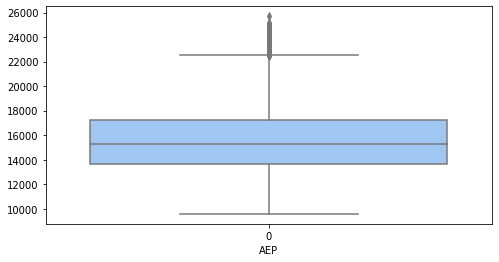

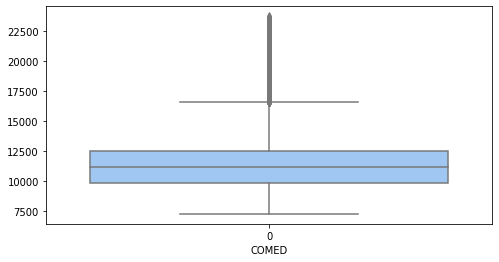

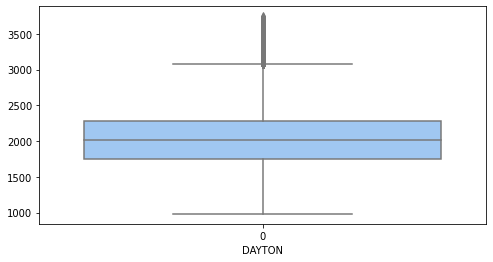

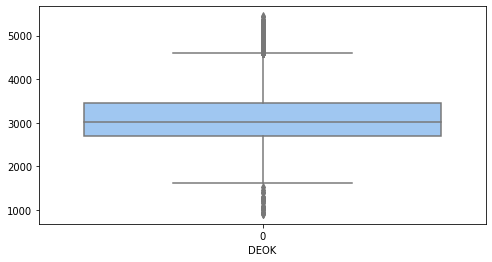

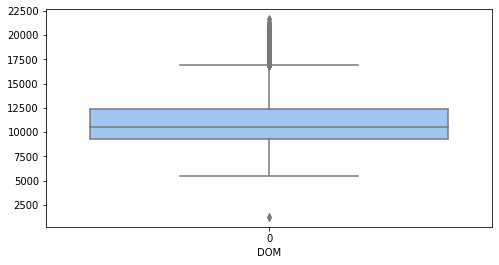

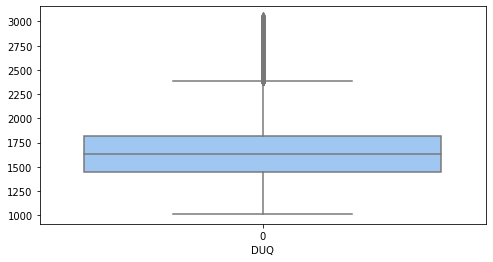

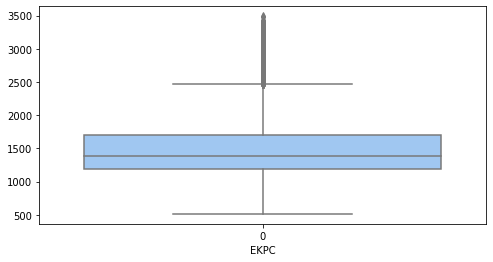

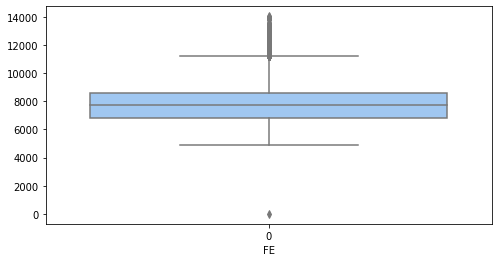

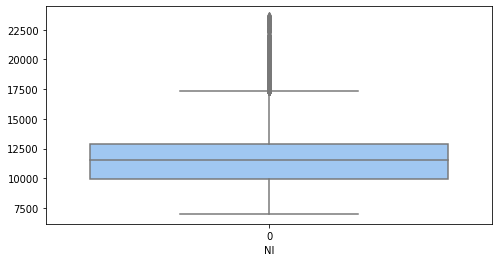

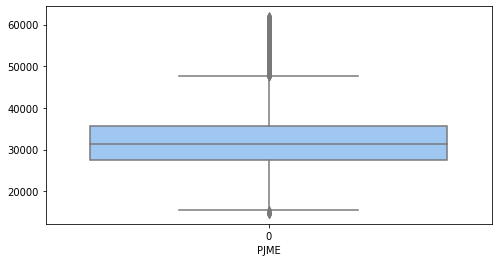

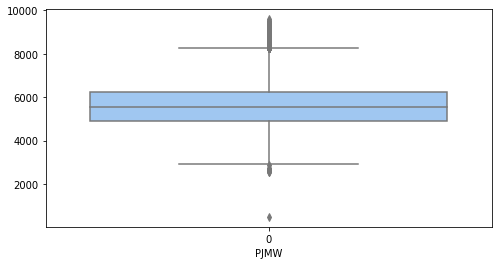

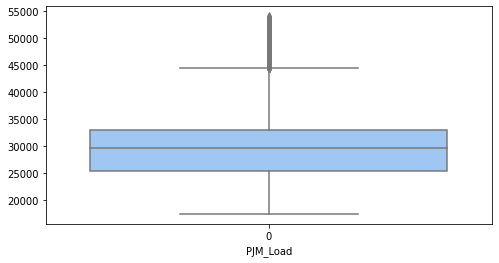

In [11]:
for col in data.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=data[col].dropna())
    plt.xlabel(col)
    plt.show

### Analyse des observations (périodicité, doublons, données manquantes)

#### Analyse des données manquantes

In [12]:
data.isna().sum()

AEP          56989
COMED       111765
DAYTON       56987
DEOK        120523
DOM          62073
DUQ          59194
EKPC        132928
FE          115388
NI          119812
PJME         32896
PJMW         35056
PJM_Load    145366
dtype: int64

#### Pas de données => remplacement par 0 car compagnies pas encore présentes dans le groupe ou sortie de la compagnie 

In [13]:
data = data.fillna(0)

In [14]:
data.isna().sum()

AEP         0
COMED       0
DAYTON      0
DEOK        0
DOM         0
DUQ         0
EKPC        0
FE          0
NI          0
PJME        0
PJMW        0
PJM_Load    0
dtype: int64

#### Doublons sur les dates

In [15]:
data.iloc[np.where(data.index.duplicated(keep=False) == True)[0],]

AEP   COMED  DAYTON    DEOK     DOM     DUQ    EKPC  \
Datetime                                                                       
2014-11-02 02:00:00  12994.0  8869.0  1623.0  2518.0  8555.0  1272.0  1554.0   
2014-11-02 02:00:00  13190.0  9184.0  1634.0  2562.0  8562.0  1240.0  1566.0   
2015-11-01 02:00:00  10785.0  8270.0  1324.0  2164.0  7392.0  1113.0   978.0   
2015-11-01 02:00:00  10542.0  7923.0  1292.0  2257.0  7345.0  1138.0   944.0   
2016-11-06 02:00:00  10964.0  7814.0  1334.0  2350.0  7924.0  1121.0  1042.0   
2016-11-06 02:00:00  11008.0  8028.0  1364.0  2198.0  8145.0  1107.0  1028.0   
2017-11-05 02:00:00  10596.0  8198.0  1449.0  2064.0  7677.0  1131.0   910.0   
2017-11-05 02:00:00  10446.0  7878.0  1331.0  1044.0  7468.0  1105.0   900.0   

                         FE   NI     PJME    PJMW  PJM_Load  
Datetime                                                     
2014-11-02 02:00:00  6051.0  0.0  22935.0  4613.0       0.0  
2014-11-02 02:00:00  6185.0  0.0  23755.0  4571.0       0.0  
2015-11-01 02:00:00  5653.0  0.0  21567.0  3927.0       0.0  
2015-11-01 02:00:00  5455.0  0.0  21171.0  3832.0       0.0  
2016-11-06 02:00:00  5523.0  0.0  20795.0  4114.0       0.0  
2016-11-06 02:00:00  5587.0  0.0  21692.0  4089.0       0.0  
2017-11-05 02:00:00  5573.0  0.0  21236.0  4042.0       0.0  
2017-11-05 02:00:00  5467.0  0.0  20666.0  3984.0       0.0

#### 4 doublons seulement => suppression du premier enregistrement

In [16]:
data_clean = data[~data.index.duplicated(keep='first')].copy()

In [17]:
data_clean.shape

(178258, 12)

In [18]:
np.where(data_clean.index.duplicated(keep=False) == True)

(array([], dtype=int64),)

#### Contrôles des dates manquantes

##### Ajout de colonnes pour décomposer l'index Datetime en colonnes 'Année','Mois','Jour','Heure'

In [19]:
from pandas import DatetimeIndex
## day_of_week:
# 0 - Monday
# 1 - Tuesday
# 2 - Wednesday
# 3 - Thursday
# 4 - Friday
# 5 - Saturday
# 6 - Sunday

data_clean['date'] = data_clean.index.date
data_clean['annee'] = data_clean.index.year
data_clean['mois'] = data_clean.index.month
data_clean['semaine'] = data_clean.index.isocalendar().week
data_clean['heure'] = data_clean.index.hour
data_clean['jour_annee'] = data_clean.index.dayofyear
data_clean['trimestre'] = data_clean.index.quarter
data_clean['jour_semaine'] = data_clean.index.dayofweek
data_clean['jour_mois'] = data_clean.index.day

In [20]:
data_clean.head()

AEP  COMED  DAYTON  DEOK  DOM  DUQ  EKPC   FE   NI  PJME  \
Datetime                                                                        
1998-12-31 01:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-12-31 02:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-12-31 03:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-12-31 04:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-12-31 05:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   

                     ...  PJM_Load        date annee  mois  semaine  heure  \
Datetime             ...                                                     
1998-12-31 01:00:00  ...   29309.0  1998-12-31  1998    12       53      1   
1998-12-31 02:00:00  ...   28236.0  1998-12-31  1998    12       53      2   
1998-12-31 03:00:00  ...   27692.0  1998-12-31  1998    12       53      3   
1998-12-31 04:00:00  ...   27596.0  1998-12-31  1998    12       53      4   
1998-12-31 05:00:00  ...   27888.0  1998-12-31  1998    12       53      5   

                     jour_annee  trimestre  jour_semaine  jour_mois  
Datetime                                                             
1998-12-31 01:00:00         365          4             3         31  
1998-12-31 02:00:00         365          4             3         31  
1998-12-31 03:00:00         365          4             3         31  
1998-12-31 04:00:00         365          4             3         31  
1998-12-31 05:00:00         365          4             3         31  

[5 rows x 21 columns]

##### Liste des jours pour lesquels il manque au moins une observation

In [21]:
checkmonth=pd.DataFrame(data_clean.groupby(['jour_annee','annee'])['annee'].count())
checkmonth.rename(columns={'annee':'nb'}, inplace=True)
df_missing=checkmonth[checkmonth.nb!=24]
df_missing=df_missing.reset_index()
df_missing.head(50)

jour_annee  annee  nb
0           67   2009  23
1           67   2015  23
2           68   2014  23
3           69   2008  23
4           69   2013  23
5           70   2007  23
6           70   2018  23
7           71   2012  23
8           71   2017  23
9           72   2011  23
10          73   2010  23
11          73   2016  23
12          91   1998  23
13          91   2001  23
14          92   2006  23
15          93   2000  23
16          93   2005  23
17          94   1999  23
18          95   1998  23
19          95   2004  23
20          96   2003  23
21          97   2002  23
22         215   2018   1
23         298   1998  23
24         299   2003  23
25         300   2002  23
26         301   2001  23
27         302   2006  23
28         303   2000  23
29         303   2005  23
30         304   1999  23
31         305   2004  23
32         305   2009  23
33         307   2008  23
34         307   2013  23
35         308   2007  23
36         309   2012  23
37         310   2011  23
38         311   2010  23
39         344   2010  23

In [22]:
Hour0_24=pd.DataFrame(np.arange(24))
df_to_append=pd.DataFrame()

In [23]:
for x,y in zip(df_missing['jour_annee'],df_missing['annee']):
    print(x,y)
    
    df_encours=data_clean[(data_clean.jour_annee==x)&(data_clean.annee==y)]
    h_missing=Hour0_24[~Hour0_24[0].isin(df_encours.heure)]
    #print(h_missing.iloc[0].name+1)
    
    h=h_missing.iloc[0].name
    df_to_append=df_to_append.append(data_clean[(data_clean.jour_annee==x)&(data_clean.annee==y)&(data_clean.heure==(h+1))])

df_to_append.heure=df_to_append.heure-1
data_clean=data_clean.append(df_to_append)


67 2009
67 2015
68 2014
69 2008
69 2013
70 2007
70 2018
71 2012
71 2017
72 2011
73 2010
73 2016
91 1998
91 2001
92 2006
93 2000
93 2005
94 1999
95 1998
95 2004
96 2003
97 2002
215 2018
298 1998
299 2003
300 2002
301 2001
302 2006
303 2000
303 2005
304 1999
305 2004
305 2009
307 2008
307 2013
308 2007
309 2012
310 2011
311 2010
344 2010


In [24]:
data_clean.sort_index(inplace=True)

# Analyse visuelle des time series

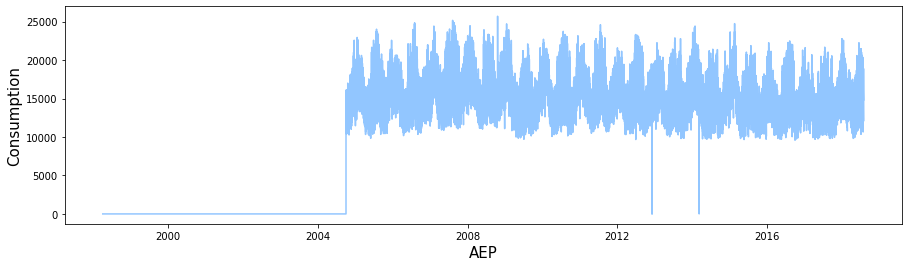

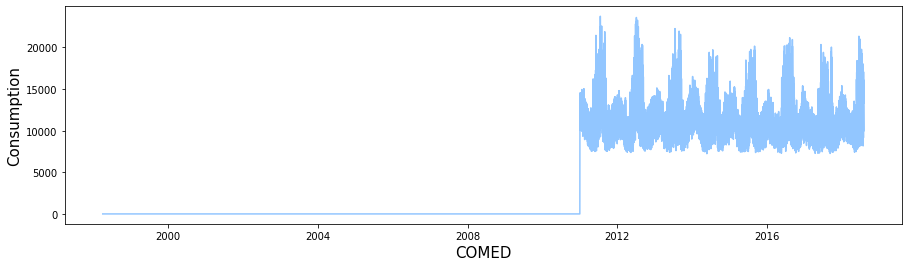

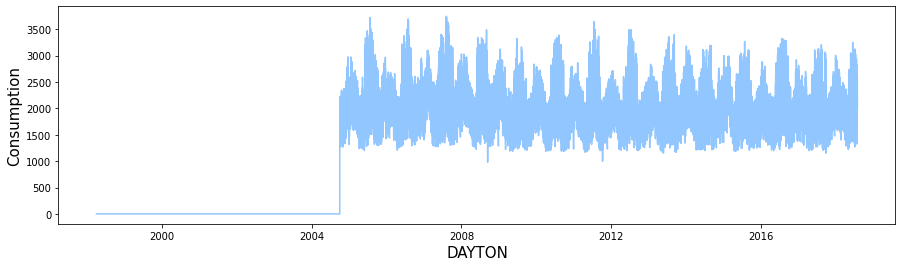

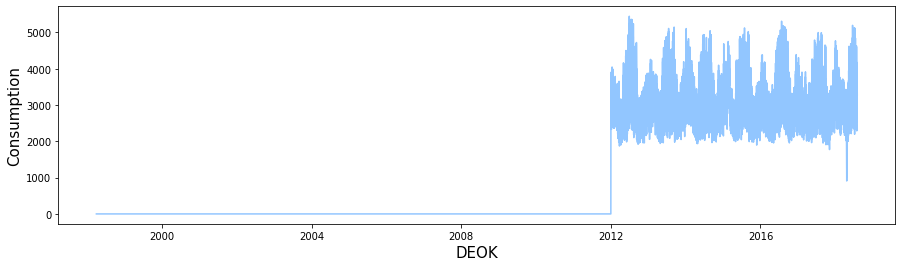

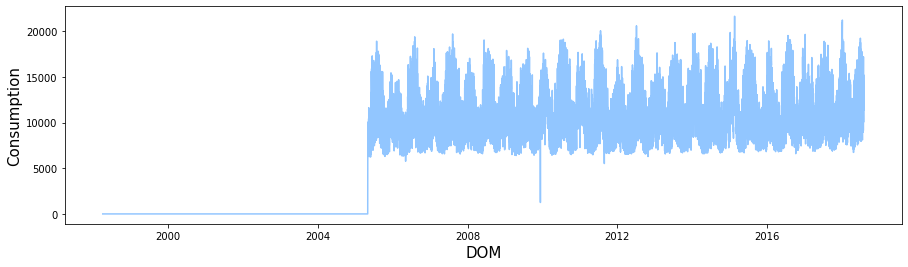

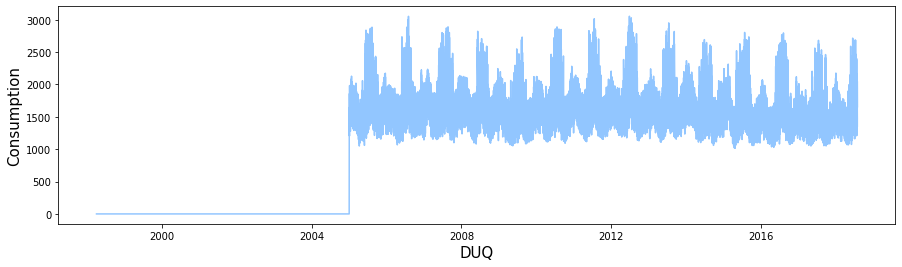

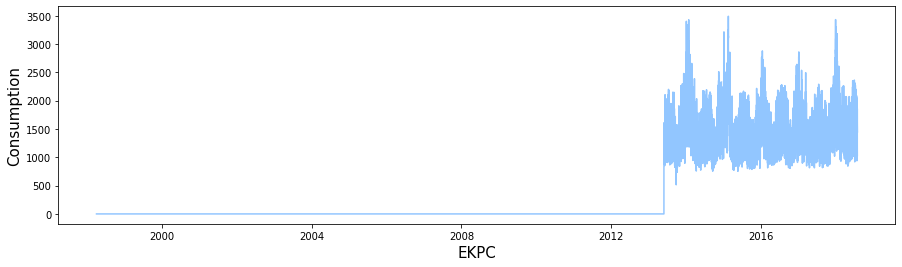

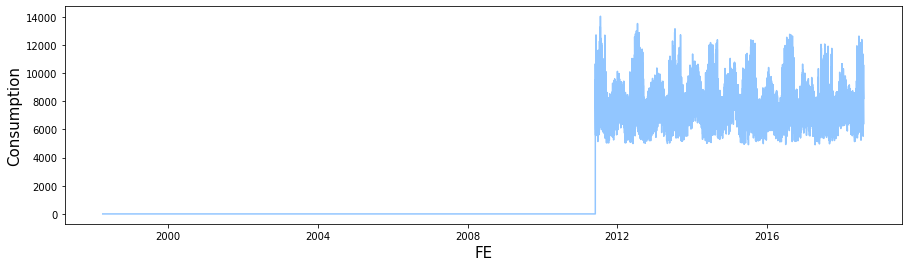

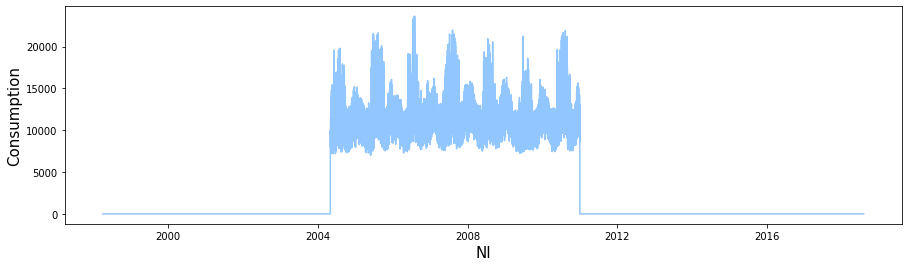

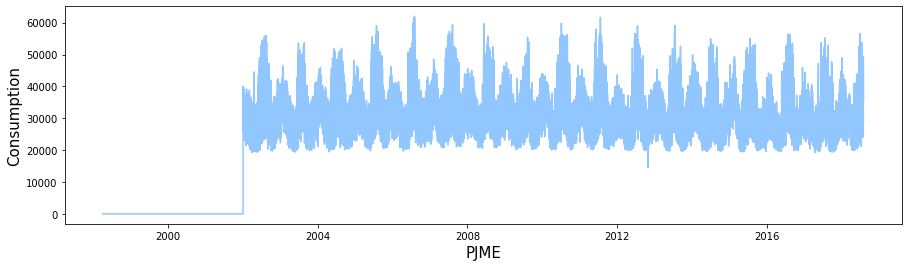

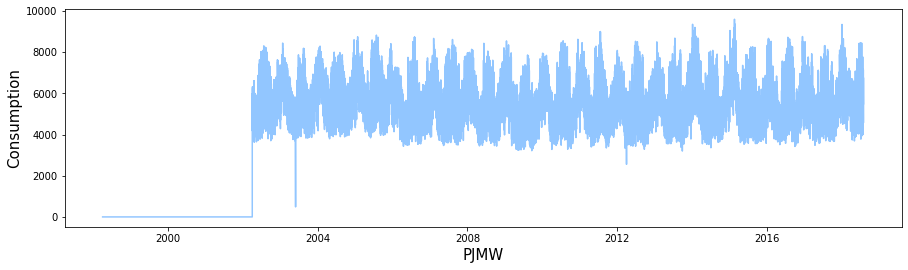

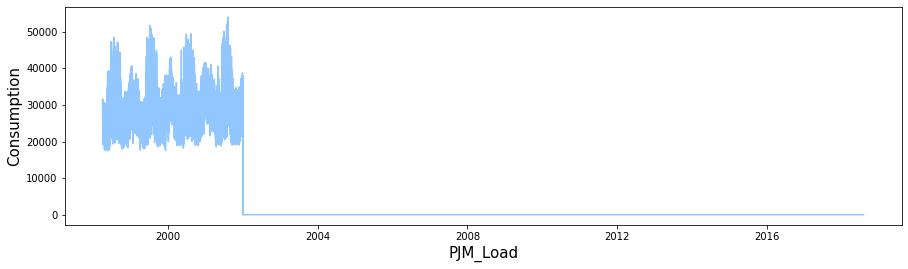

In [25]:
for col in data_clean.loc[:,'AEP':'PJM_Load'].columns:
    plt.figure(figsize = (15,4))
    plt.plot(data_clean['date'], data_clean[col])
    plt.xlabel(col, fontsize=15)
    plt.ylabel('Consumption', fontsize=15)
    plt.show()

#### => La liste des compagnies qui fournissent PJM en électricité évolue dans le temps, donc pour éviter des problèmes avec les données d'entrée, il faut étudier la consommation électrique globale

# Feature Engineering

### Analyse que sur la consommation globale de PJM (total des compagnies) 
#### Ajout d'une feature sur le total des consommations des compagnies

In [26]:
data_clean['Total'] = data_clean.apply(lambda x : x.loc['AEP':'PJM_Load'].sum(), axis=1)

In [27]:
data_clean.head(50)

AEP  COMED  DAYTON  DEOK  DOM  DUQ  EKPC   FE   NI  PJME  \
Datetime                                                                        
1998-04-01 01:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 01:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 02:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 03:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 04:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 05:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 06:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 07:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 08:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 09:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 10:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 11:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 12:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 13:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 14:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 15:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 16:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 17:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 18:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 19:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 20:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 21:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 22:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-01 23:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 00:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 01:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 02:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 03:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 04:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 05:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 06:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 07:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 08:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 09:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 10:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 11:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 12:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 13:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 14:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 15:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 16:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 17:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 18:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 19:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 20:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 21:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 22:00:00  0.0    0.0     0.0   0.0  0.0  0.0   0.0  0.0  0.0   0.0   
1998-04-02 23:00:00  0.0    0.0     0.0   0.0  0.0  

In [28]:
data_clean.tail(50)

AEP    COMED  DAYTON    DEOK      DOM     DUQ  \
Datetime                                                                 
2018-07-31 23:00:00  15504.0  12898.0  2096.0  3503.0  12787.0  1740.0   
2018-08-01 00:00:00  14424.0  11945.0  1928.0  3187.0  11712.0  1603.0   
2018-08-01 01:00:00  13538.0  10975.0  1796.0  2971.0  10947.0  1510.0   
2018-08-01 02:00:00  12903.0  10233.0  1715.0  2807.0  10398.0  1432.0   
2018-08-01 03:00:00  12506.0   9734.0  1648.0  2695.0  10115.0  1391.0   
2018-08-01 04:00:00  12206.0   9374.0  1613.0  2615.0   9944.0  1358.0   
2018-08-01 05:00:00  12295.0   9156.0  1626.0  2624.0  10033.0  1384.0   
2018-08-01 06:00:00  12714.0   9270.0  1697.0  2737.0  10530.0  1459.0   
2018-08-01 07:00:00  13512.0   9753.0  1851.0  2963.0  11177.0  1555.0   
2018-08-01 08:00:00  14139.0  10466.0  1950.0  3097.0  11840.0  1605.0   
2018-08-01 09:00:00  14685.0  11424.0  2032.0  3210.0  12453.0  1676.0   
2018-08-01 10:00:00  15223.0  12294.0  2068.0  3301.0  13080.0  1725.0   
2018-08-01 11:00:00  15648.0  13025.0  2122.0  3384.0  13973.0  1808.0   
2018-08-01 12:00:00  16116.0  13814.0  2140.0  3465.0  14639.0  1888.0   
2018-08-01 13:00:00  16623.0  14516.0  2183.0  3545.0  15360.0  1947.0   
2018-08-01 14:00:00  17008.0  15203.0  2247.0  3670.0  15987.0  1990.0   
2018-08-01 15:00:00  17146.0  15881.0  2311.0  3748.0  16345.0  2052.0   
2018-08-01 16:00:00  17193.0  16123.0  2314.0  3859.0  16713.0  2082.0   
2018-08-01 17:00:00  17183.0  15766.0  2377.0  3931.0  17208.0  2073.0   
2018-08-01 18:00:00  17204.0  15574.0  2433.0  3972.0  17131.0  2017.0   
2018-08-01 19:00:00  16870.0  15569.0  2402.0  3873.0  16638.0  1953.0   
2018-08-01 20:00:00  16579.0  15122.0  2349.0  3793.0  15973.0  1907.0   
2018-08-01 21:00:00  16457.0  14449.0  2270.0  3688.0  15461.0  1865.0   
2018-08-01 22:00:00  16197.0  14246.0  2257.0  3687.0  14687.0  1809.0   
2018-08-01 23:00:00  15259.0  13778.0  2118.0  3467.0  13569.0  1704.0   
2018-08-02 00:00:00  14125.0  12892.0  1924.0  3209.0  12362.0  1580.0   
2018-08-02 01:00:00  13286.0  11916.0  1789.0  2963.0  11457.0  1480.0   
2018-08-02 02:00:00  12587.0  11095.0  1717.0  2791.0  10830.0  1400.0   
2018-08-02 03:00:00  12296.0  10530.0  1632.0  2682.0  10353.0  1351.0   
2018-08-02 04:00:00  12059.0  10165.0  1605.0  2613.0  10082.0  1346.0   
2018-08-02 05:00:00  12224.0   9931.0  1604.0  2613.0  10058.0  1353.0   
2018-08-02 06:00:00  12781.0   9996.0  1684.0  2728.0  10490.0  1413.0   
2018-08-02 07:00:00  13661.0  10482.0  1820.0  2956.0  11181.0  1503.0   
2018-08-02 08:00:00  14326.0  11200.0  1927.0  3083.0  11850.0  1592.0   
2018-08-02 09:00:00  14834.0  12179.0  2023.0  3239.0  12555.0  1674.0   
2018-08-02 10:00:00  15309.0  13042.0  2107.0  3359.0  13232.0  1735.0   
2018-08-02 11:00:00  16025.0  13828.0  2226.0  3536.0  13966.0  1792.0   
2018-08-02 12:00:00  16651.0  14790.0  2315.0  3674.0  14666.0  1865.0   
2018-08-02 13:00:00  17423.0  15527.0  2429.0  3890.0  15191.0  1931.0   
2018-08-02 14:00:00  18067.0  16074.0  2525.0  3991.0  15244.0  1952.0   
2018-08-02 15:00:00  18534.0  16584.0  2576.0  4070.0  14941.0  1983.0   
2018-08-02 16:00:00  18826.0  16869.0  2594.0  4113.0  14791.0  2029.0   
2018-08-02 17:00:00  18869.0  17015.0  2626.0  4136.0  14924.0  2039.0   
2018-08-02 18:00:00  18562.0  17068.0  2624.0  4168.0  14898.0  2050.0   
2018-08-02 19:00:00  18118.0  16897.0  2600.0  4122.0  14453.0  1999.0   
2018-08-02 20:00:00  17673.0  16437.0  2554.0  4052.0  14038.0  1966.0   
2018-08-02 21:00:00  17303.0  15590.0  2481.0  3892.0  13832.0  1944.0   
2018-08-02 22:00:00  17001.0  15086.0  2405.0  3851.0  13312.0  1901.0   
2018-08-02 23:00:00  15964.0  14448.0  2250.0  3575.0  12390.0  1789.0   
2018-08-03 00:00:00  14809.0  13335.0  2042.0  3281.0  11385.0  1656.0   

                       EKPC       FE   NI     PJME  ...        date  annee  \
Datetime                                            ...                      
2018-07-31 23:00:00 

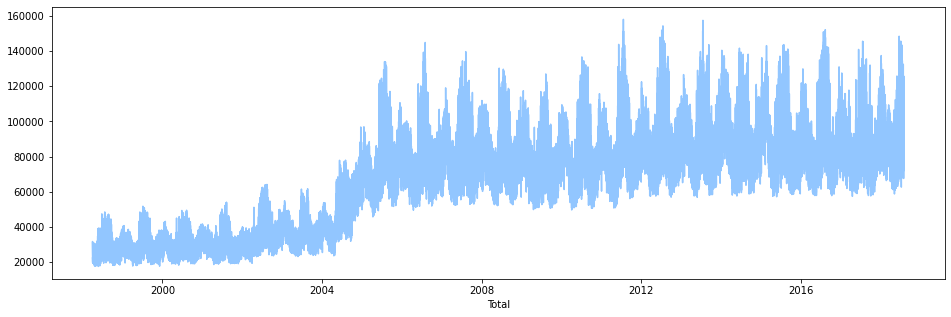

In [29]:
plt.figure(figsize=(16,5))
plt.plot(data_clean['date'], data_clean['Total'])
plt.xlabel("Total")
plt.show()

#### Pour éviter de biaiser nos résultats, les données entre 1998 à 2004 sont supprimées

In [30]:
data_clean = data_clean[data_clean['annee'] > 2004]

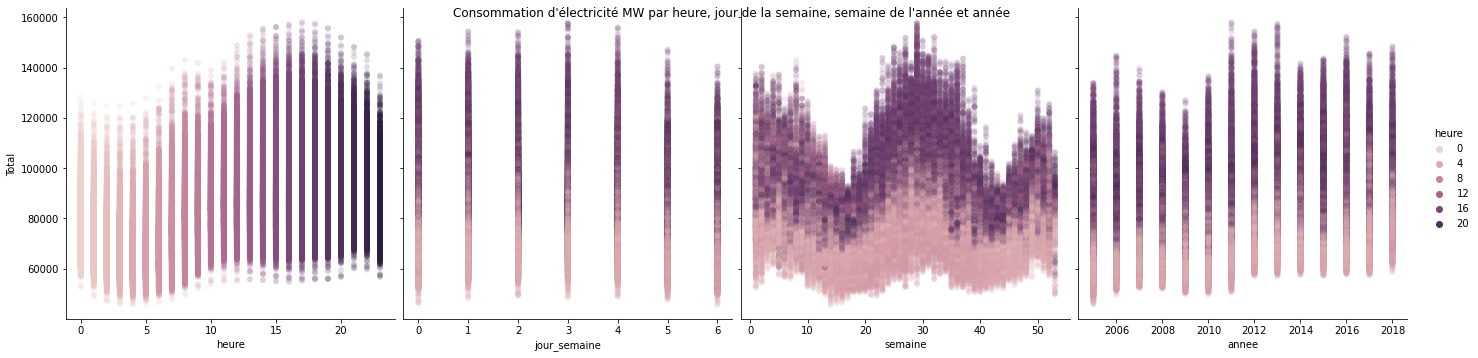

In [31]:
sns.pairplot(data_clean.dropna(),
             hue='heure',
             x_vars=['heure','jour_semaine'
                     ,'semaine','annee'],
             y_vars='Total',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Consommation d\'électricité MW par heure, jour de la semaine, semaine de l\'année et année')
plt.show()

<Figure size 1440x360 with 0 Axes>

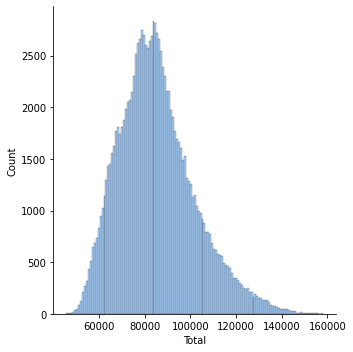

In [32]:
plt.figure(figsize=(20,5))
sns.displot( data_clean['Total'] )
plt.show()

### Définition des nouvelles features

#### La prédiction de consommation d'énergie électrique à long terme doit se baser sur le total de la consommation électrique par jour

In [33]:
#Création de la feature de consommation total d'energie par jour
df_feature_total_per_day = pd.DataFrame(data_clean.groupby(['date'])['Total'].sum())

# Retrait de la dernière ligne qui a une consommation incomplète
df_feature_total_per_day = df_feature_total_per_day[:-1]

print(df_feature_total_per_day.head())
print(df_feature_total_per_day.tail())

# Converting the index as date
df_feature_total_per_day.index = pd.to_datetime(df_feature_total_per_day.index, format="%Y-%m-%d")

                Total
date                 
2005-01-01  1369994.0
2005-01-02  1439464.0
2005-01-03  1602888.0
2005-01-04  1623191.0
2005-01-05  1711922.0
                Total
date                 
2018-07-29  2120395.0
2018-07-30  2270128.0
2018-07-31  2324560.0
2018-08-01  2484528.0
2018-08-02  2525317.0


# Persistence
La première étape avant de passer à l'analyse et la modélisation des données est d'établir une référence de performance. Cela fournira à la fois un modèle pour évaluer les modèles en utilisant les "harnais'" de test et une mesure de la performance par laquelle tous les modèles prédictifs plus élaborés peuvent être comparés. 

La prédiction de base pour la prévision de séries chronologiques est appelée prévision naïve, ou persistance. C'est là que l'observation du pas de temps précédent est utilisée comme prédiction pour l'observation au prochain pas de temps. (valeur prédite = valeur du timestep précédent)

Train shape :  (3473, 1)
Test shape :  (1489, 1)
1489
>Predicted=1852269.000, Expected=1997038.000
>Predicted=1997038.000, Expected=2570678.000
>Predicted=2570678.000, Expected=2656345.000
>Predicted=2656345.000, Expected=2486524.000
>Predicted=2486524.000, Expected=2397725.000
>Predicted=2397725.000, Expected=2389559.000
>Predicted=2389559.000, Expected=2328726.000
>Predicted=2328726.000, Expected=2394560.000
>Predicted=2394560.000, Expected=2568026.000
>Predicted=2568026.000, Expected=2416788.000
>Predicted=2416788.000, Expected=2217472.000
>Predicted=2217472.000, Expected=2179785.000
>Predicted=2179785.000, Expected=2163464.000
>Predicted=2163464.000, Expected=1999999.000
>Predicted=1999999.000, Expected=2041641.000
>Predicted=2041641.000, Expected=2435213.000
>Predicted=2435213.000, Expected=2641848.000
>Predicted=2641848.000, Expected=2628275.000
>Predicted=2628275.000, Expected=2312467.000
>Predicted=2312467.000, Expected=2188312.000
>Predicted=2188312.000, Expected=2166063.000
>

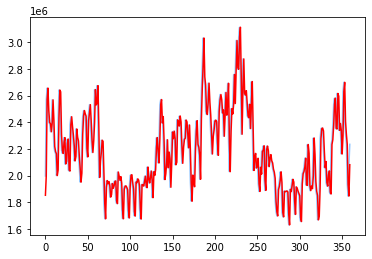

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Feature = Total de la consommation électrique par jour
X = df_feature_total_per_day[['Total']].values

# Echantillons d'apprentissage et de validation 
train_rate = 0.70
train_size = int(len(X) * train_rate)
train, test = X[0:train_size], X[train_size:]

print("Train shape : ",train.shape)
print("Test shape : ", test.shape)

# walk-forward validation => valeur prédite = valeur de la veille
history = [x for x in train]
predictions = list()
print(len(test))
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

# Plot des prédictions vs test
plt.plot(test[:360])
plt.plot(predictions[:360],'-r')
plt.show() 

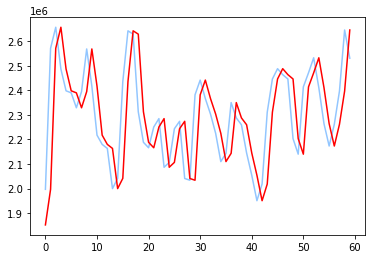

In [36]:
# Plot des prédictions vs test
plt.plot(test[:60])
plt.plot(predictions[:60],'-r')
plt.show() 

In [37]:
print('RMSE = {:.0f} MW'.format(rmse))
print('% erreur / consommation électrique quotidienne : {:.2%} du minimum - {:.2%} du maximum'.format(rmse/X.min(),rmse/X.max()))

RMSE = 147466 MW
% erreur / consommation électrique quotidienne : 11.56% du minimum - 4.68% du maximum


#### Le RMSE du test de persistence est de 147466 
##### En moyenne la valeur prédite a une erreur de 147466 MW



# Exploration de la time series de consommation électrique totale par jour

## Statistiques descriptives

In [38]:
df_feature_total_per_day.describe()

Total
count  4.962000e+03
mean   2.048073e+06
std    3.011892e+05
min    1.275837e+06
25%    1.833779e+06
50%    2.006090e+06
75%    2.242308e+06
max    3.148567e+06

##### 4962 observations
##### Moyenne : 2 048 073 (Level)
##### Ecart-type et quantile suggèrent une répartition étroite autour de la moyenne

## Visualisation de la Time Series

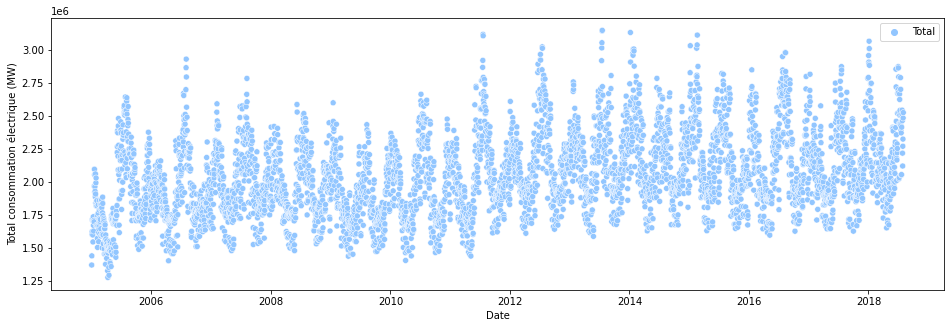

In [39]:
plt.figure(figsize=(16,5))
sns.scatterplot(data=df_feature_total_per_day)
plt.xlabel("Date")
plt.ylabel("Total consommation électrique (MW)")
plt.show()

## Distribution et densité

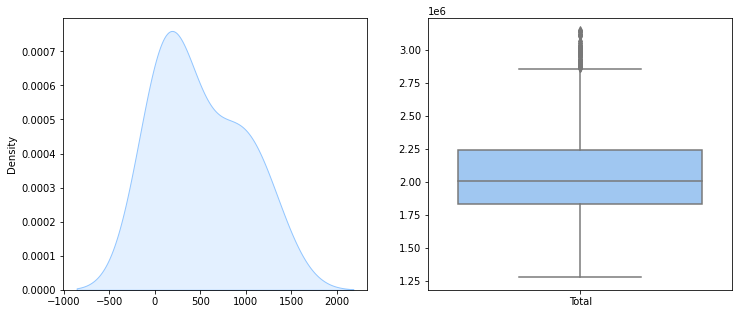

In [40]:
plt.figure(1,figsize=(12,5))
plt.subplot(121)
hist, bin_edges = np.histogram(df_feature_total_per_day)
sns.kdeplot(hist, label='X', fill=True)
plt.subplot(122)
sns.boxplot(data=df_feature_total_per_day)
plt.show()

## Boxplot

<AxesSubplot:>

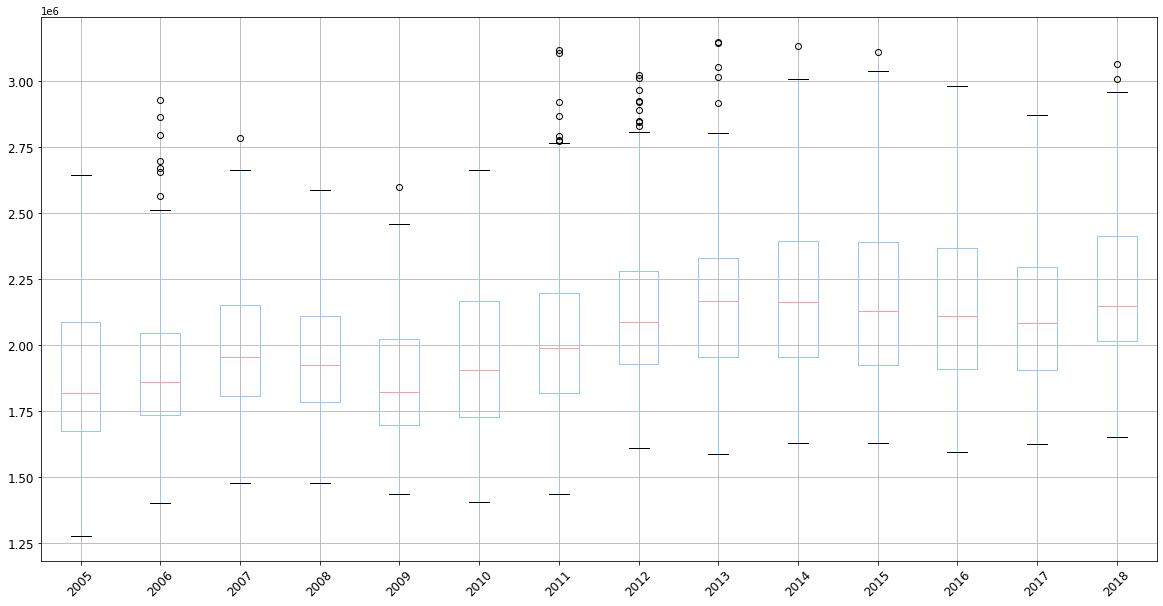

In [41]:
df = df_feature_total_per_day.copy()
df['annee'] = df.index.year
df.pivot(columns='annee', values='Total').boxplot(rot=45, fontsize=12, figsize=(20,10))

- La valeur médiane de chaque année indique une légère tendance à la hausse
- La répartition des valeurs de chaque année indique une légère variation

La time series semble stationnaire.

# Analyse de la structure temporelle 

## Décomposition de la time series

La décomposition des séries chronologiques implique de penser à une série comme une combinaison :
- de niveau,
- de tendance,
- de saisonnalité,
- les composants du bruit.

La décomposition fournit un modèle abstrait utile pour réfléchir au temps séries en général et pour une meilleure compréhension des problèmes lors de l’analyse et de la prévision des séries chronologiques.

### Analyse de la saisonnalité dans la série

Une structure de cycle dans une série chronologique peut ou non être saisonnière. S'il se répète constamment à
la même fréquence, elle est saisonnière, sinon elle n'est pas saisonnière et s'appelle un cycle.

<b>Avantages de la saisonnalité pour le machine learning</b>

Comprendre la composante saisonnière dans les séries chronologiques peut améliorer les performances de la modélisation avec l'apprentissage automatique. 


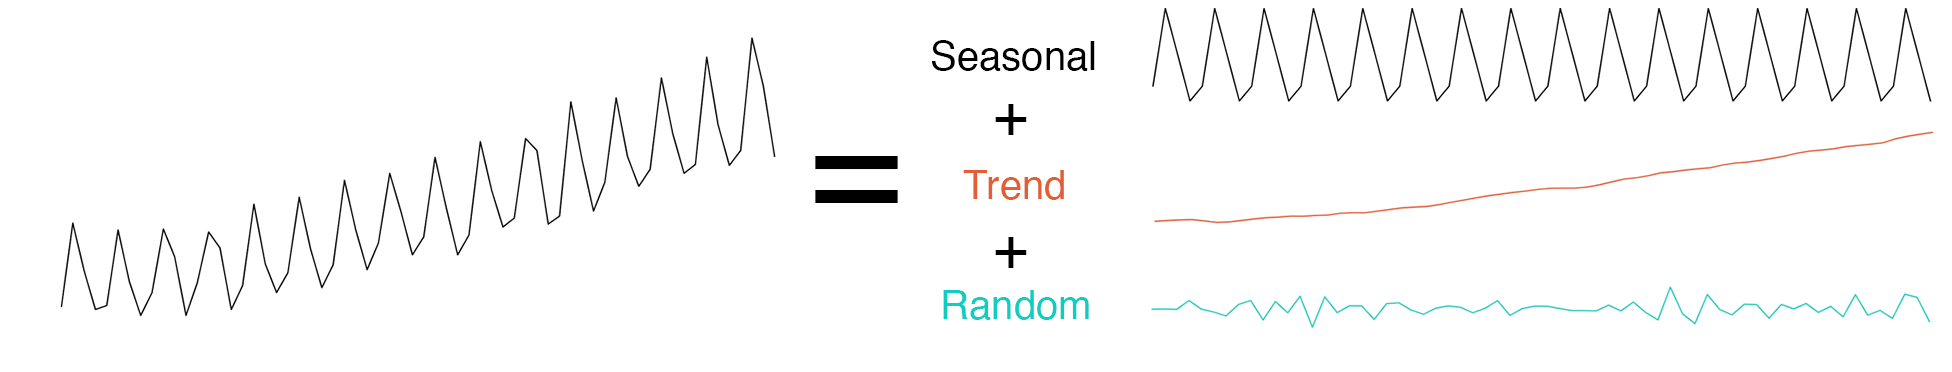
https://anomaly.io/seasonal-trend-decomposition-in-r/index.html

Cela peut se produire de deux manières principales :

- <b>Un signal plus clair</b>  : l'identification et la suppression de la composante saisonnière de la série chronologique peuvent résulter en une relation plus claire entre les variables d'entrée et de sortie.
- <b>Plus d'informations</b>   : les informations supplémentaires sur la composante saisonnière de la time series peuvent fournir de nouvelles informations pour améliorer les performances du modèle.

Les deux approches peuvent être utiles sur un projet. 

La modélisation et la suppression de la saisonnalité peut être réalisée pendant la phase de nettoyage et préparation des données. 
L'extraction des informations saisonnières et leur sélection en tant que données d'entrée, soit directement ou sous forme de résumé, peut être réalisée pendant les phases de features selection et features engineering.

<u>Types de saisonnalité </u>:
- Heure de la journée
- Quotidienne
- Hebdomadaire
- Mensuelle
- Annuelle

L'approche la plus simple pour déterminer la saisonnalité est d'afficher graphiquement la time series, peut-être à différentes échelles, et l'ajout d'une courbe de tendance.



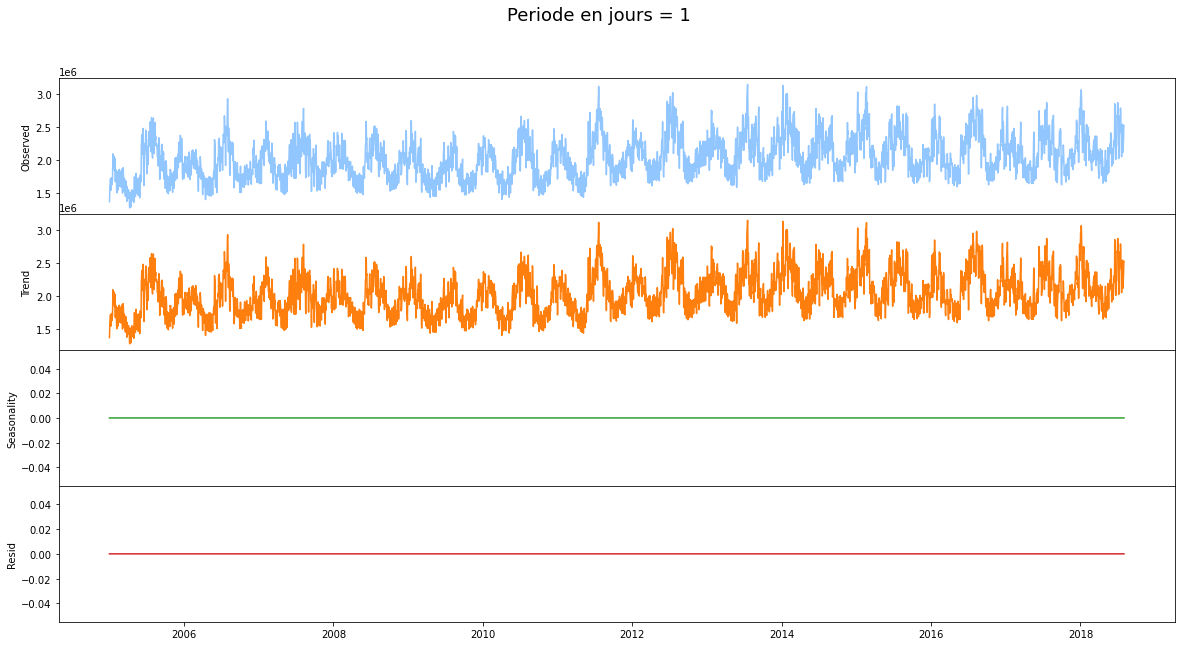

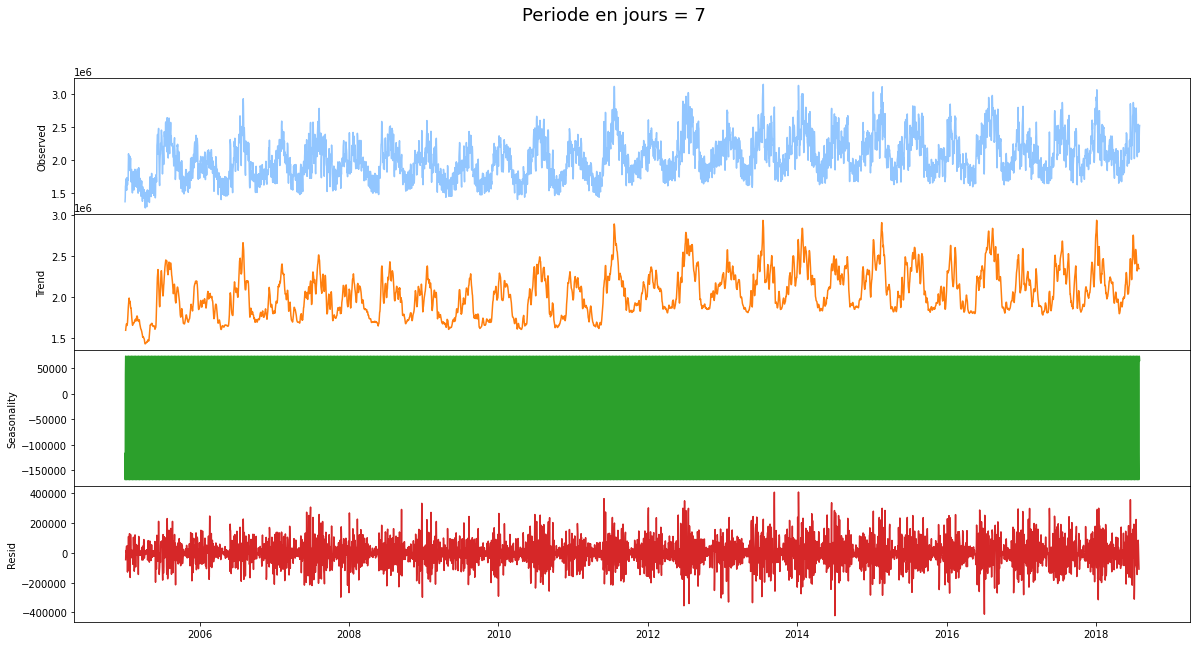

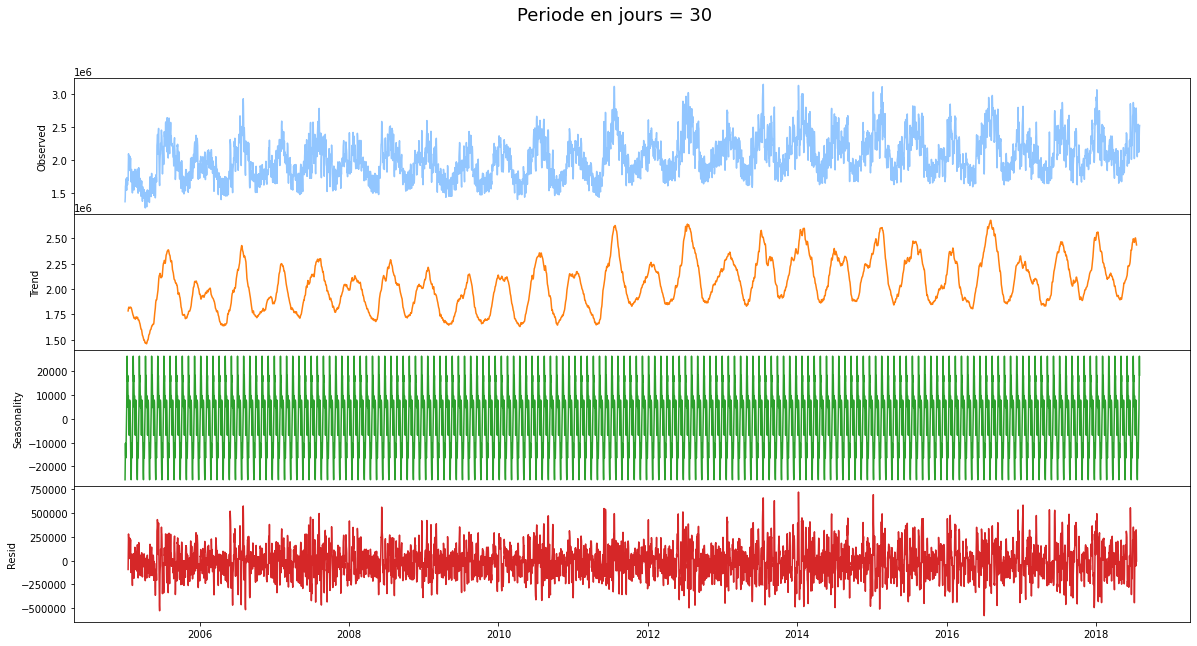

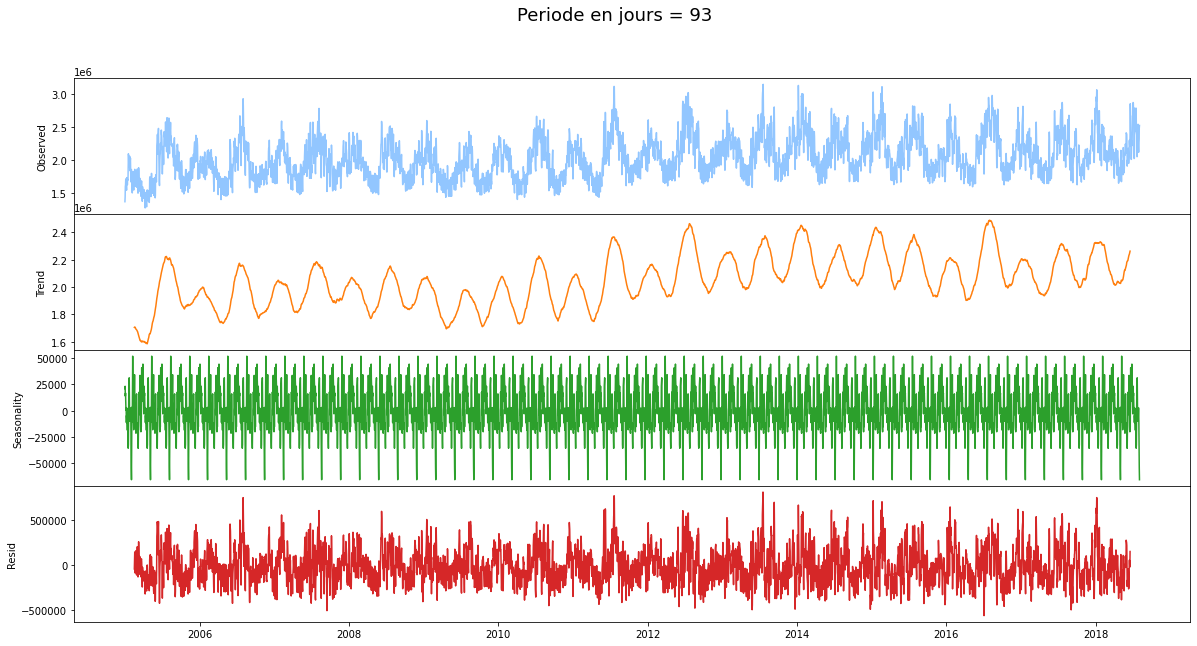

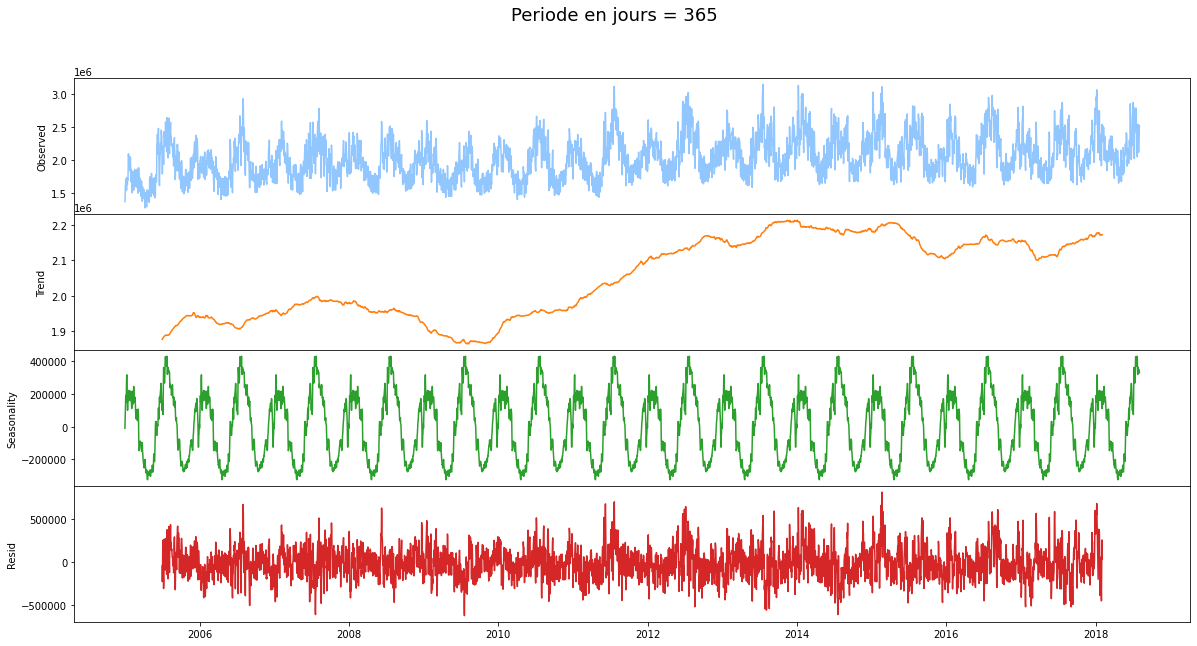

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose


for i in [1,7,30,93,365]:
    result = seasonal_decompose(df_feature_total_per_day, model='additive',period=i)
    #print(result.trend)
    #print(result.seasonal)
    #print(result.resid)
    #print(result.observed)
    #result.plot()
    
    fig, axs = plt.subplots(4,figsize = (20,10), sharex=True, gridspec_kw={'hspace': 0})
    
    fig.suptitle("Periode en jours = {}".format(i), fontsize=18)

    axs[0].plot(result.observed)
    axs[0].set_ylabel("Observed")
    axs[1].plot(result.trend, 'tab:orange')
    axs[1].set_ylabel("Trend")
    axs[2].plot(result.seasonal, 'tab:green')
    axs[2].set_ylabel("Seasonality")
    axs[3].plot(result.resid, 'tab:red')
    axs[3].set_ylabel("Resid")

    #plt.plot(result.observed)
    #plt.ylabel("Observed",fontsize=18)
    #plt.show()
    #plt.figure(figsize=(20,4))
    #plt.plot(result.trend)
    #plt.ylabel("Trend",fontsize=18)
    #plt.show()
    #plt.figure(figsize=(20,4))
    #plt.plot(result.seasonal)
    #plt.ylabel("Seasonality",fontsize=18)
    #plt.show()
    #plt.figure(figsize=(20,4))
    #plt.plot(result.resid)
    #plt.ylabel("Resid",fontsize=18)

    plt.show()
    print("\n\n")


###### Suppression de la saisonnalité

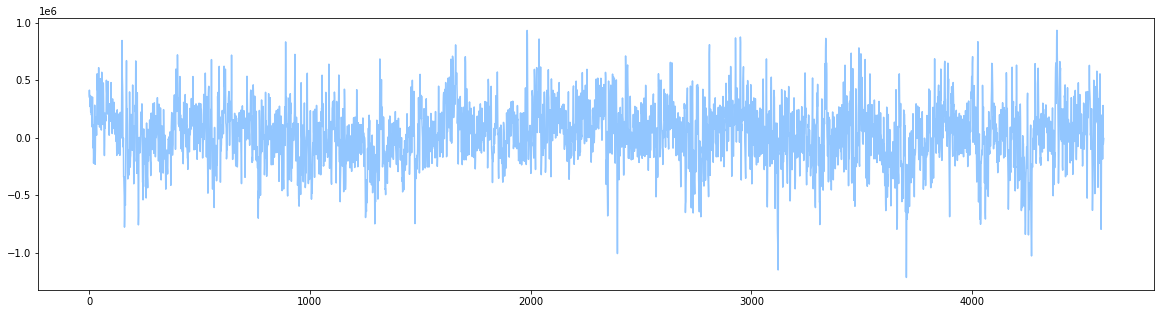

In [43]:
X = df_feature_total_per_day.values
diff = list()
days_in_year = 365
for i in range(days_in_year, len(X)):
    value = X[i] - X[i - days_in_year]
    diff.append(value)

plt.figure(figsize=(20,5))
plt.plot(diff)
plt.show()

In [44]:
df_feature_total_per_day_decompose = df_feature_total_per_day[days_in_year:].copy()
df_feature_total_per_day_decompose['Total_without_seasonality'] = diff

## Contrôle de la stationnarité

Les observations dans une série chronologique stationnaire ne dépendent pas du temps. Les séries chronologiques sont stationnaires si elles n'ont pas d'effets de tendance ou de saison. 
Les statistiques récapitulatives calculées sur la série chronologique sont cohérentes dans le temps, comme la moyenne ou la variance des observations. Quand une série chronologique est stationnaire, elle peut être plus facile à modéliser. Les méthodes de modélisation statistique supposent ou exigent que les séries chronologiques doivent être stationnaires pour être efficaces.

<b><u>Notions et types de séries temporelles stationnaires</u></b>

- <b>Processus stationnaire :</b> processus qui génère une série d'observations stationnaires.
- <b>Modèle stationnaire :</b> Un modèle qui décrit une série stationnaire d'observations.
- <b>Tendance stationnaire :</b> une série chronologique qui ne présente pas de tendance.
- <b>Stationnaire saisonnier :</b> une série chronologique qui ne présente pas de saisonnalité.
- <b>Strictement stationnaire :</b> la distribution conjointe des observations est invariante au décalage temporel.

### Test statistique de stationnarité : augmented Dickey-Fuller test

In [45]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_feature_total_per_day['Total'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: {:f} ({})'.format(result[1],result[1]))
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.628947
p-value: 0.000000 (5.780186754846657e-09)
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [46]:
# Données avec suppression dela saisonnalité
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_feature_total_per_day_decompose['Total_without_seasonality'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: {:f} ({})'.format(result[1],result[1]))
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.953505
p-value: 0.000000 (3.0808180338568586e-12)
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


La P-value à 0 (< 0.05 soit 5%) et le résultat statistique du test à -6.62 ( < à la valeur critique de 1% soit -3.432) indiquent que la time series est stationnaire.

Le résultat du test confirme la conclusion suggérée par la visualisation des boxplot par année.

Ces résultats suggèrent que le modèle ARIMA ait au moins 1 niveau de différenciation (paramètre <b>d</b>  du modèle >= 1).

## Autocorrélation et autorégression

L'étape suivante consiste à sélectionner les valeurs de décalage pour l'Autorégression (AR) et la moyenne mobile (MA), respectivement les paramètres p et q du modèle ARIMA. Il faut pour cela utiliser la fonction d'autocorrélation (ACF) et les tracés de fonction d'autocorrélation partielle (PACF).

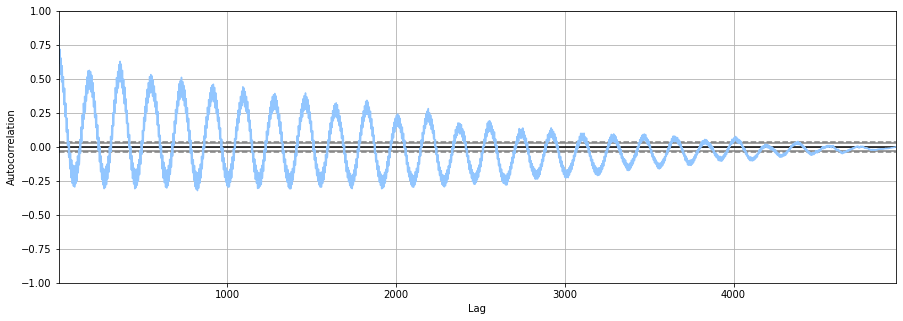

In [47]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize = [15, 5])
autocorrelation_plot(df_feature_total_per_day[['Total']])
plt.show()

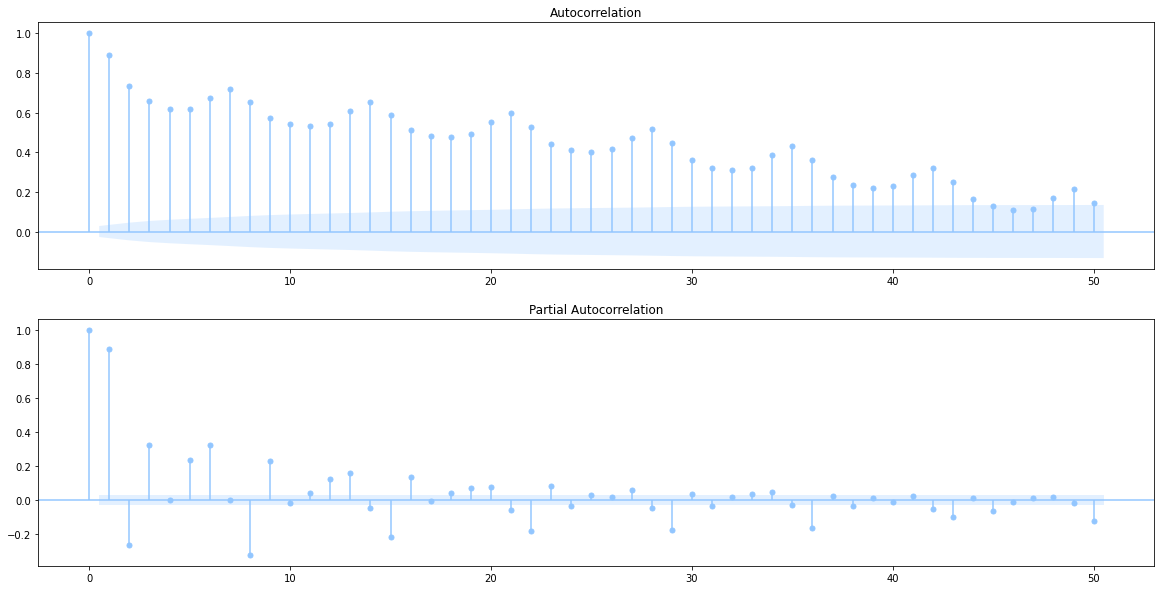

In [48]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(20,10))
plt.subplot(211)
plot_acf(df_feature_total_per_day['Total'].values, lags=(50), ax=plt.gca())
plt.subplot(212)
plot_pacf(df_feature_total_per_day['Total'].values, lags=(50), ax=plt.gca())
plt.show()

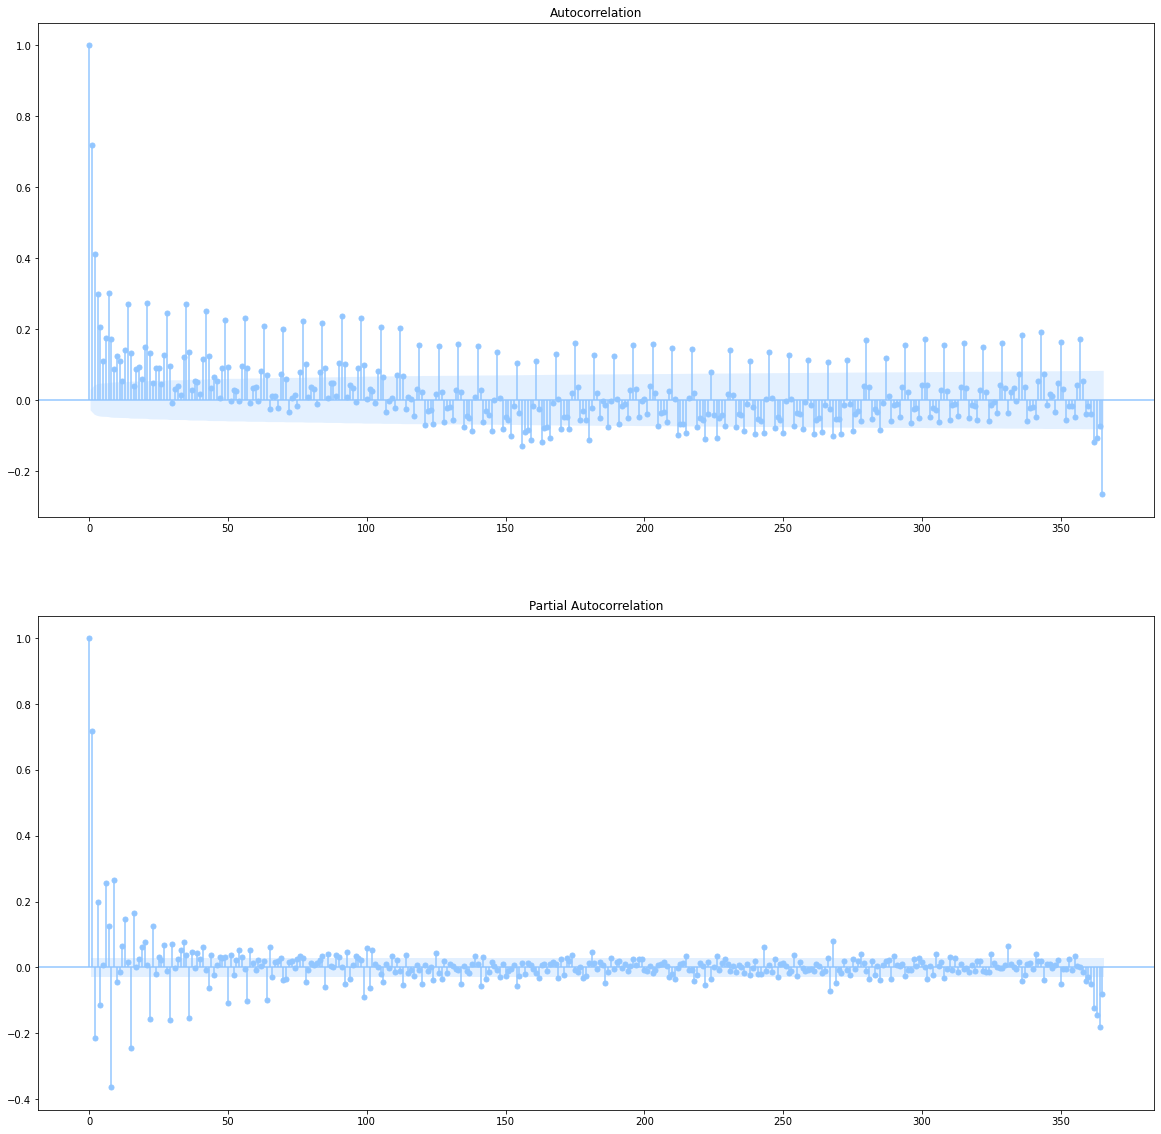

In [49]:
# Données sans saisonnalité annuelle

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(20,20))
plt.subplot(211)
plot_acf(df_feature_total_per_day_decompose['Total_without_seasonality'].values, lags=(365*1), ax=plt.gca())
plt.subplot(212)
plot_pacf(df_feature_total_per_day_decompose['Total_without_seasonality'].values, lags=(365*1), ax=plt.gca())
plt.show()

lags = 366 ou  365*2  => p et q difficiles à estimer 

<b>Intuition for ACF and PACF Plots</b>

Plots of the autocorrelation function and the partial autocorrelation function for a time series tell a very different story.

We can use the intuition for ACF and PACF above to explore some thought experiments.


<b>Autoregression Intuition</b>

Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.


<b>Moving Average Intuition</b>

Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

In [50]:

# prepare data
X = df_feature_total_per_day['Total'].values
X = X.astype('float32')

# Echantillons d'apprentissage et de test
train_size = int(len(X) * 0.70)
train, test = X[0:train_size], X[train_size:]

## Evaluation manuelle du modèle ARIMA



#    What does ARIMA(1, 0, 12) mean?

    Specifically for your model, ARIMA(1, 0, 12) means that it you are describing some response variable (Y) by combining a 1st order Auto-Regressive model and a 12th order Moving Average model. A good way to think about it is (AR, I, MA). This makes your model look the following, in simple terms:

    Y = (Auto-Regressive Parameters) + (Moving Average Parameters)

    The 0 in the between the 1 and the 12 represents the 'I' part of the model (the Integrative part) and it signifies a model where you're taking the difference between response variable data - this can be done with non-stationary data and it doesn't seem like you're dealing with that, so you can just ignore it.

    The link that DanTheMan posted shows a nice mix of models that could help you understand yours by comparing it to those.

###    What values can be assigned to p, d, q?

    Lots of different whole numbers. There are diagnostic tests you can do to try to find the best values of p,d,q (see part 3).

###    What is the process to find the values of p, d, q?

    There are a number of ways, and I don't intend this to be exhaustive:
        look at an autocorrelation graph of the data (will help if Moving Average (MA) model is appropriate)
        
        
        look at a partial autocorrelation graph of the data (will help if AutoRegressive (AR) model is appropriate)
        
        
        look at extended autocorrelation chart of the data (will help if a combination of AR and MA are needed)
        
        
        try Akaike's Information Criterion (AIC) on a set of models and investigate the models with the lowest AIC values
        
        
        try the Schwartz Bayesian Information Criterion (BIC) and investigate the models with the lowest BIC values
        

    Without knowing how much more you need to know, I can't go too much farther, but if you have more questions, feel free to ask and maybe I, or someone else, can help.


In [54]:
# evaluate a manually configured ARIMA model

# walk-forward validation
history = [x for x in train]
predictions = list()
hist_rmse = list()

#Evaluation sur un petit échantillon
test = test[:90]

for i in range(len(test)):
    # predict
    #model = ARIMA(history, order=(7,1,1))
    model = ARIMA(history)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    hist_rmse.append(sqrt(mean_squared_error(test[:len(predictions)], predictions)))
    print('step %.0f >Predicted=%.3f, Expected=%.3f, RMSE = %.0f' % (i,yhat, obs, hist_rmse[-1]))
   
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

step 0 >Predicted=1999631.080, Expected=1997038.000, RMSE = 2593
step 1 >Predicted=1999630.334, Expected=2570678.000, RMSE = 403796
step 2 >Predicted=1999794.664, Expected=2656345.000, RMSE = 502381
step 3 >Predicted=1999983.545, Expected=2486524.000, RMSE = 498468
step 4 >Predicted=2000123.476, Expected=2397725.000, RMSE = 479994
step 5 >Predicted=2000237.795, Expected=2389559.000, RMSE = 466108
step 6 >Predicted=2000349.701, Expected=2328726.000, RMSE = 449026
step 7 >Predicted=2000444.062, Expected=2394560.000, RMSE = 442535
step 8 >Predicted=2000557.282, Expected=2568026.000, RMSE = 458102
step 9 >Predicted=2000720.254, Expected=2416788.000, RMSE = 454074
step 10 >Predicted=2000839.710, Expected=2217472.000, RMSE = 437842
step 11 >Predicted=2000901.889, Expected=2179785.000, RMSE = 422370
step 12 >Predicted=2000953.219, Expected=2163464.000, RMSE = 408296
step 13 >Predicted=2000999.837, Expected=1999999.000, RMSE = 393444
step 14 >Predicted=2000999.550, Expected=2041641.000, RMSE =

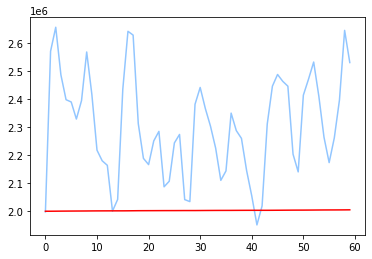

In [55]:

# Plot des prédictions vs test
plt.plot(test[:60])
plt.plot(predictions[:60],'-r')
plt.show()    

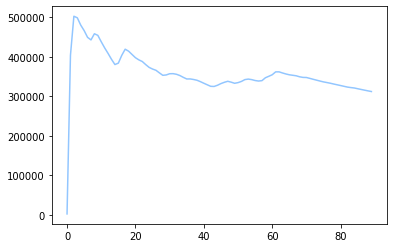

In [58]:
# Plot des prédictions vs test
plt.plot(hist_rmse)
plt.show()

Autorégression (AR) : p = 7

Differences :         d = 1

Moyenne mobile (MA) : q = 1

=> RMSE = 116902



(0, 0, 0)   step =  0
Predicted=1939100.259, Expected=1943332.000, RMSE = 64638
(0, 0, 0)   step =  1
Predicted=1939074.216, Expected=1943332.000, RMSE = 48001
(0, 0, 0)   step =  2
Predicted=1939065.864, Expected=1943332.000, RMSE = 40118
(0, 0, 0)   step =  3
Predicted=1939059.892, Expected=1943332.000, RMSE = 44486
(0, 0, 0)   step =  4
Predicted=1939037.531, Expected=1943332.000, RMSE = 105560
(0, 0, 0)   step =  5
Predicted=1938949.586, Expected=1943332.000, RMSE = 144338
(0, 0, 0)   step =  6
Predicted=1938843.747, Expected=1943332.000, RMSE = 136263
(0, 0, 0)   step =  7
Predicted=1938815.405, Expected=1943332.000, RMSE = 129039
(0, 0, 0)   step =  8
Predicted=1938792.550, Expected=1943332.000, RMSE = 123149
(0, 0, 0)   step =  9
Predicted=1938769.540, Expected=1943332.000, RMSE = 117431
(0, 0, 0)   step =  10
Predicted=1938754.469, Expected=1943332.000, RMSE = 111991
(0, 0, 0)   step =  11
Predicted=1938757.615, Expected=1943332.000, RMSE = 108721
(0, 0, 0)   step =  12
Predict

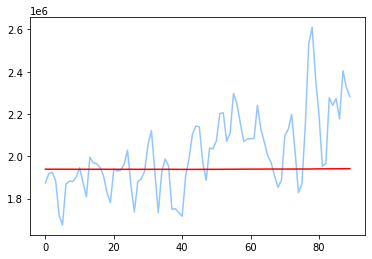

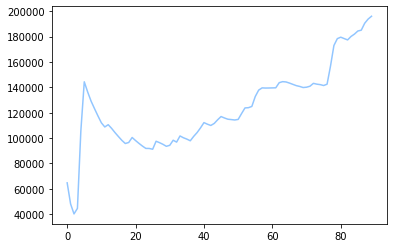

ARIMA(0, 0, 0) RMSE=196065  , actual best : (0, 0, 0) RMSE: 196065
(1, 0, 0)   step =  0
Predicted=1846812.428, Expected=1943332.000, RMSE = 27650
(1, 0, 0)   step =  1
Predicted=1881981.692, Expected=1943332.000, RMSE = 32297
(1, 0, 0)   step =  2
Predicted=1920748.845, Expected=1943332.000, RMSE = 26447
(1, 0, 0)   step =  3
Predicted=1925956.124, Expected=1943332.000, RMSE = 31230
(1, 0, 0)   step =  4
Predicted=1889957.905, Expected=1943332.000, RMSE = 80807
(1, 0, 0)   step =  5
Predicted=1745833.188, Expected=1943332.000, RMSE = 79124
(1, 0, 0)   step =  6
Predicted=1706316.982, Expected=1943332.000, RMSE = 95477
(1, 0, 0)   step =  7
Predicted=1876538.199, Expected=1943332.000, RMSE = 89331
(1, 0, 0)   step =  8
Predicted=1888553.152, Expected=1943332.000, RMSE = 84254
(1, 0, 0)   step =  9
Predicted=1888169.550, Expected=1943332.000, RMSE = 80037
(1, 0, 0)   step =  10
Predicted=1905600.484, Expected=1943332.000, RMSE = 77307
(1, 0, 0)   step =  11
Predicted=1945680.162, Expect

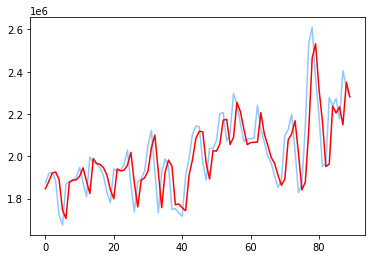

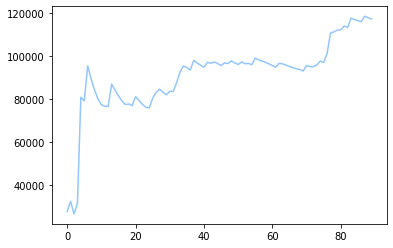

ARIMA(1, 0, 0) RMSE=117268  , actual best : (1, 0, 0) RMSE: 117268
(2, 0, 0)   step =  0
Predicted=1906667.743, Expected=1943332.000, RMSE = 32206
(2, 0, 0)   step =  1
Predicted=1894520.062, Expected=1943332.000, RMSE = 28323
(2, 0, 0)   step =  2
Predicted=1933003.227, Expected=1943332.000, RMSE = 23674
(2, 0, 0)   step =  3
Predicted=1927976.227, Expected=1943332.000, RMSE = 30250
(2, 0, 0)   step =  4
Predicted=1880902.289, Expected=1943332.000, RMSE = 76705
(2, 0, 0)   step =  5
Predicted=1709443.342, Expected=1943332.000, RMSE = 71362
(2, 0, 0)   step =  6
Predicted=1702670.133, Expected=1943332.000, RMSE = 91024
(2, 0, 0)   step =  7
Predicted=1929734.957, Expected=1943332.000, RMSE = 86806
(2, 0, 0)   step =  8
Predicted=1893918.594, Expected=1943332.000, RMSE = 81947
(2, 0, 0)   step =  9
Predicted=1889834.719, Expected=1943332.000, RMSE = 77825
(2, 0, 0)   step =  10
Predicted=1911986.530, Expected=1943332.000, RMSE = 74933
(2, 0, 0)   step =  11
Predicted=1957439.776, Expect

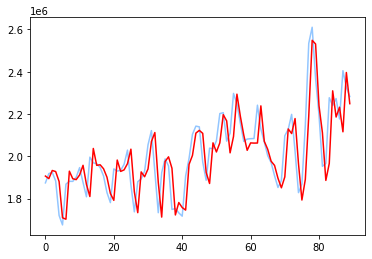

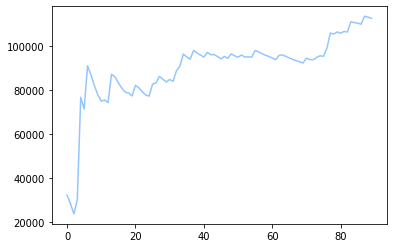

ARIMA(2, 0, 0) RMSE=112550  , actual best : (2, 0, 0) RMSE: 112550
(3, 0, 0)   step =  0
Predicted=1922773.798, Expected=1943332.000, RMSE = 48312
(3, 0, 0)   step =  1
Predicted=1825727.401, Expected=1943332.000, RMSE = 73859
(3, 0, 0)   step =  2
Predicted=1921147.690, Expected=1943332.000, RMSE = 60332
(3, 0, 0)   step =  3
Predicted=1913727.534, Expected=1943332.000, RMSE = 54392
(3, 0, 0)   step =  4
Predicted=1874982.181, Expected=1943332.000, RMSE = 84531
(3, 0, 0)   step =  5
Predicted=1706122.934, Expected=1943332.000, RMSE = 78157
(3, 0, 0)   step =  6
Predicted=1740045.466, Expected=1943332.000, RMSE = 87102
(3, 0, 0)   step =  7
Predicted=1947565.003, Expected=1943332.000, RMSE = 84717
(3, 0, 0)   step =  8
Predicted=1831211.436, Expected=1943332.000, RMSE = 81612
(3, 0, 0)   step =  9
Predicted=1882883.601, Expected=1943332.000, RMSE = 77641
(3, 0, 0)   step =  10
Predicted=1911098.802, Expected=1943332.000, RMSE = 74797
(3, 0, 0)   step =  11
Predicted=1953263.558, Expect

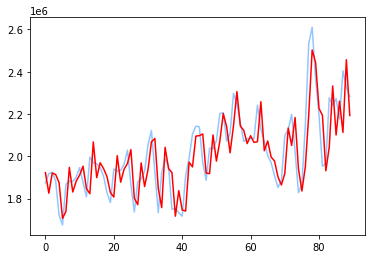

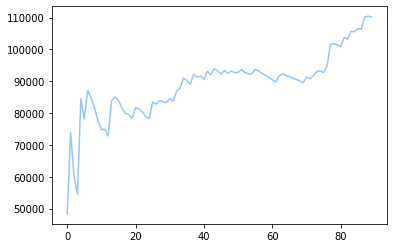

ARIMA(3, 0, 0) RMSE=110220  , actual best : (3, 0, 0) RMSE: 110220
(4, 0, 0)   step =  0
Predicted=1923543.675, Expected=1943332.000, RMSE = 49082
(4, 0, 0)   step =  1
Predicted=1826196.104, Expected=1943332.000, RMSE = 73820
(4, 0, 0)   step =  2
Predicted=1919378.513, Expected=1943332.000, RMSE = 60339
(4, 0, 0)   step =  3
Predicted=1913454.786, Expected=1943332.000, RMSE = 54360
(4, 0, 0)   step =  4
Predicted=1874736.434, Expected=1943332.000, RMSE = 84424
(4, 0, 0)   step =  5
Predicted=1706373.714, Expected=1943332.000, RMSE = 78077
(4, 0, 0)   step =  6
Predicted=1740045.029, Expected=1943332.000, RMSE = 87041
(4, 0, 0)   step =  7
Predicted=1948096.115, Expected=1943332.000, RMSE = 84713
(4, 0, 0)   step =  8
Predicted=1831770.489, Expected=1943332.000, RMSE = 81570
(4, 0, 0)   step =  9
Predicted=1881337.000, Expected=1943332.000, RMSE = 77640
(4, 0, 0)   step =  10
Predicted=1910898.329, Expected=1943332.000, RMSE = 74805
(4, 0, 0)   step =  11
Predicted=1953157.123, Expect

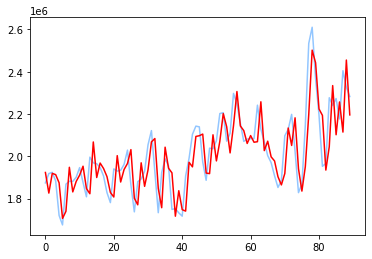

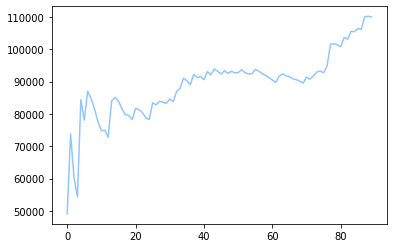

ARIMA(4, 0, 0) RMSE=109986  , actual best : (4, 0, 0) RMSE: 109986
(5, 0, 0)   step =  0
Predicted=1922846.115, Expected=1943332.000, RMSE = 48384
(5, 0, 0)   step =  1
Predicted=1851679.050, Expected=1943332.000, RMSE = 58242
(5, 0, 0)   step =  2
Predicted=1934976.292, Expected=1943332.000, RMSE = 47957
(5, 0, 0)   step =  3
Predicted=1855250.058, Expected=1943332.000, RMSE = 43867
(5, 0, 0)   step =  4
Predicted=1865803.385, Expected=1943332.000, RMSE = 75944
(5, 0, 0)   step =  5
Predicted=1698626.230, Expected=1943332.000, RMSE = 69954
(5, 0, 0)   step =  6
Predicted=1748253.983, Expected=1943332.000, RMSE = 79083
(5, 0, 0)   step =  7
Predicted=1947833.441, Expected=1943332.000, RMSE = 77558
(5, 0, 0)   step =  8
Predicted=1849129.466, Expected=1943332.000, RMSE = 73914
(5, 0, 0)   step =  9
Predicted=1899706.427, Expected=1943332.000, RMSE = 70123
(5, 0, 0)   step =  10
Predicted=1860522.206, Expected=1943332.000, RMSE = 71720
(5, 0, 0)   step =  11
Predicted=1946476.955, Expect

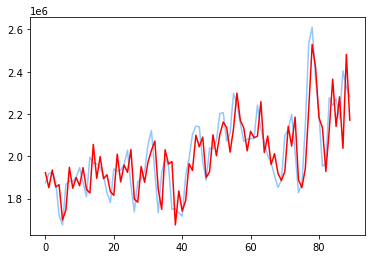

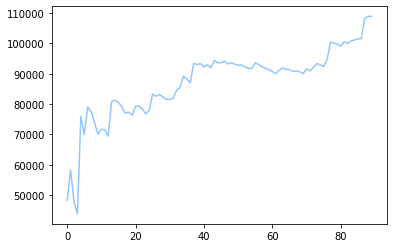

ARIMA(5, 0, 0) RMSE=108904  , actual best : (5, 0, 0) RMSE: 108904
(6, 0, 0)   step =  0
Predicted=1923371.551, Expected=1943332.000, RMSE = 48910
(6, 0, 0)   step =  1
Predicted=1855108.307, Expected=1943332.000, RMSE = 56524
(6, 0, 0)   step =  2
Predicted=1961033.432, Expected=1943332.000, RMSE = 50808
(6, 0, 0)   step =  3
Predicted=1875759.433, Expected=1943332.000, RMSE = 44171
(6, 0, 0)   step =  4
Predicted=1790355.845, Expected=1943332.000, RMSE = 50392
(6, 0, 0)   step =  5
Predicted=1700348.389, Expected=1943332.000, RMSE = 47087
(6, 0, 0)   step =  6
Predicted=1740561.890, Expected=1943332.000, RMSE = 65057
(6, 0, 0)   step =  7
Predicted=1947447.559, Expected=1943332.000, RMSE = 65115
(6, 0, 0)   step =  8
Predicted=1854672.945, Expected=1943332.000, RMSE = 62039
(6, 0, 0)   step =  9
Predicted=1918600.859, Expected=1943332.000, RMSE = 59111
(6, 0, 0)   step =  10
Predicted=1883422.713, Expected=1943332.000, RMSE = 59491
(6, 0, 0)   step =  11
Predicted=1875638.991, Expect

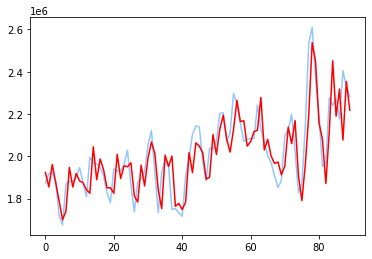

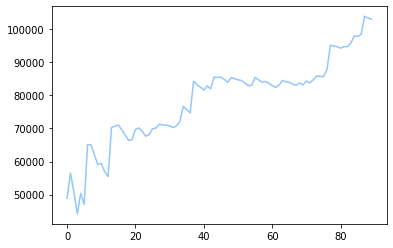

ARIMA(6, 0, 0) RMSE=103025  , actual best : (6, 0, 0) RMSE: 103025
(7, 0, 0)   step =  0
Predicted=1923187.971, Expected=1943332.000, RMSE = 48726
(7, 0, 0)   step =  1
Predicted=1855392.048, Expected=1943332.000, RMSE = 56286
(7, 0, 0)   step =  2
Predicted=1960823.333, Expected=1943332.000, RMSE = 50581
(7, 0, 0)   step =  3
Predicted=1877005.190, Expected=1943332.000, RMSE = 43924
(7, 0, 0)   step =  4
Predicted=1791144.135, Expected=1943332.000, RMSE = 50440
(7, 0, 0)   step =  5
Predicted=1697728.973, Expected=1943332.000, RMSE = 46913
(7, 0, 0)   step =  6
Predicted=1740766.023, Expected=1943332.000, RMSE = 64892
(7, 0, 0)   step =  7
Predicted=1946441.735, Expected=1943332.000, RMSE = 64845
(7, 0, 0)   step =  8
Predicted=1855017.361, Expected=1943332.000, RMSE = 61770
(7, 0, 0)   step =  9
Predicted=1918673.850, Expected=1943332.000, RMSE = 58859
(7, 0, 0)   step =  10
Predicted=1884288.383, Expected=1943332.000, RMSE = 59181
(7, 0, 0)   step =  11
Predicted=1876232.308, Expect

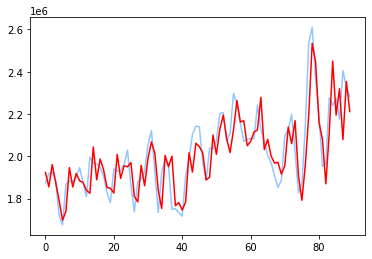

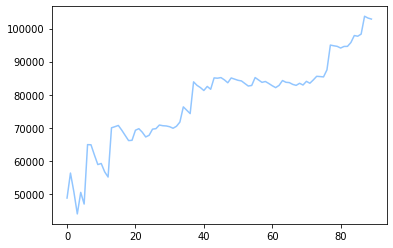

ARIMA(7, 0, 0) RMSE=102886  , actual best : (7, 0, 0) RMSE: 102886
(8, 0, 0)   step =  0
Predicted=1914822.410, Expected=1943332.000, RMSE = 40360
(8, 0, 0)   step =  1
Predicted=1859366.925, Expected=1943332.000, RMSE = 50529
(8, 0, 0)   step =  2
Predicted=1954630.050, Expected=1943332.000, RMSE = 44835
(8, 0, 0)   step =  3
Predicted=1881477.219, Expected=1943332.000, RMSE = 38841
(8, 0, 0)   step =  4
Predicted=1762768.693, Expected=1943332.000, RMSE = 39570
(8, 0, 0)   step =  5
Predicted=1679473.794, Expected=1943332.000, RMSE = 36155
(8, 0, 0)   step =  6
Predicted=1801132.492, Expected=1943332.000, RMSE = 42017
(8, 0, 0)   step =  7
Predicted=1942479.787, Expected=1943332.000, RMSE = 44756
(8, 0, 0)   step =  8
Predicted=1877613.735, Expected=1943332.000, RMSE = 42216
(8, 0, 0)   step =  9
Predicted=1911034.532, Expected=1943332.000, RMSE = 40169
(8, 0, 0)   step =  10
Predicted=1882415.708, Expected=1943332.000, RMSE = 42911
(8, 0, 0)   step =  11
Predicted=1857131.533, Expect

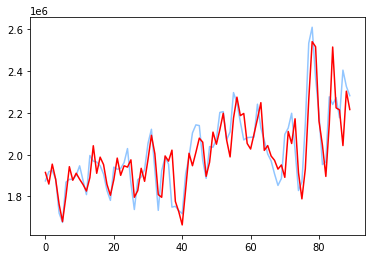

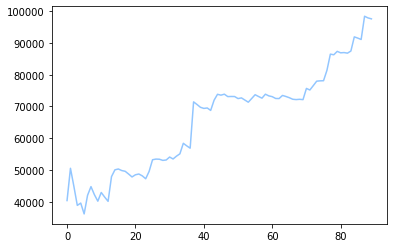

ARIMA(8, 0, 0) RMSE=97605  , actual best : (8, 0, 0) RMSE: 97605
(9, 0, 0)   step =  0
Predicted=1890995.504, Expected=1943332.000, RMSE = 16534
(9, 0, 0)   step =  1
Predicted=1860716.658, Expected=1943332.000, RMSE = 42387
(9, 0, 0)   step =  2
Predicted=1957385.752, Expected=1943332.000, RMSE = 39550
(9, 0, 0)   step =  3
Predicted=1882452.863, Expected=1943332.000, RMSE = 34255
(9, 0, 0)   step =  4
Predicted=1760379.873, Expected=1943332.000, RMSE = 35472
(9, 0, 0)   step =  5
Predicted=1692139.994, Expected=1943332.000, RMSE = 33068
(9, 0, 0)   step =  6
Predicted=1811273.354, Expected=1943332.000, RMSE = 37447
(9, 0, 0)   step =  7
Predicted=1913557.555, Expected=1943332.000, RMSE = 36770
(9, 0, 0)   step =  8
Predicted=1874691.977, Expected=1943332.000, RMSE = 34741
(9, 0, 0)   step =  9
Predicted=1898408.183, Expected=1943332.000, RMSE = 32971
(9, 0, 0)   step =  10
Predicted=1885967.018, Expected=1943332.000, RMSE = 36364
(9, 0, 0)   step =  11
Predicted=1863710.689, Expected

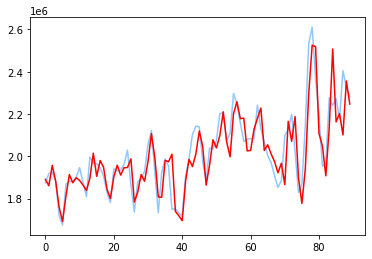

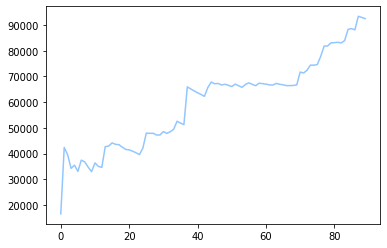

ARIMA(9, 0, 0) RMSE=92506  , actual best : (9, 0, 0) RMSE: 92506
(10, 0, 0)   step =  0
Predicted=1890269.134, Expected=1943332.000, RMSE = 15807
(10, 0, 0)   step =  1
Predicted=1862117.874, Expected=1943332.000, RMSE = 41294
(10, 0, 0)   step =  2
Predicted=1957508.811, Expected=1943332.000, RMSE = 38806
(10, 0, 0)   step =  3
Predicted=1882167.277, Expected=1943332.000, RMSE = 33614
(10, 0, 0)   step =  4
Predicted=1760310.939, Expected=1943332.000, RMSE = 34962
(10, 0, 0)   step =  5
Predicted=1692157.487, Expected=1943332.000, RMSE = 32613
(10, 0, 0)   step =  6
Predicted=1810414.264, Expected=1943332.000, RMSE = 37294
(10, 0, 0)   step =  7
Predicted=1913104.219, Expected=1943332.000, RMSE = 36585
(10, 0, 0)   step =  8
Predicted=1876369.853, Expected=1943332.000, RMSE = 34535
(10, 0, 0)   step =  9
Predicted=1898603.671, Expected=1943332.000, RMSE = 32773
(10, 0, 0)   step =  10
Predicted=1886758.566, Expected=1943332.000, RMSE = 36082
(10, 0, 0)   step =  11
Predicted=1863705.5

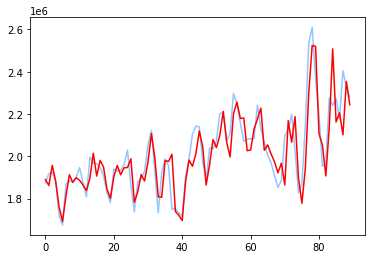

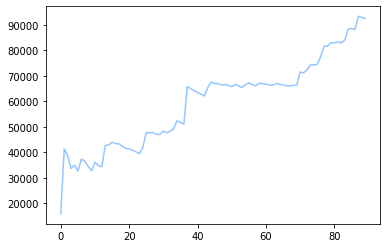

ARIMA(10, 0, 0) RMSE=92545  , actual best : (9, 0, 0) RMSE: 92506
(11, 0, 0)   step =  0
Predicted=1890283.939, Expected=1943332.000, RMSE = 15822
(11, 0, 0)   step =  1
Predicted=1864535.545, Expected=1943332.000, RMSE = 39654
(11, 0, 0)   step =  2
Predicted=1952846.429, Expected=1943332.000, RMSE = 36349
(11, 0, 0)   step =  3
Predicted=1881701.214, Expected=1943332.000, RMSE = 31492
(11, 0, 0)   step =  4
Predicted=1761285.960, Expected=1943332.000, RMSE = 33580
(11, 0, 0)   step =  5
Predicted=1692308.405, Expected=1943332.000, RMSE = 31392
(11, 0, 0)   step =  6
Predicted=1810396.672, Expected=1943332.000, RMSE = 36388
(11, 0, 0)   step =  7
Predicted=1916021.523, Expected=1943332.000, RMSE = 36109
(11, 0, 0)   step =  8
Predicted=1877735.409, Expected=1943332.000, RMSE = 34067
(11, 0, 0)   step =  9
Predicted=1893042.985, Expected=1943332.000, RMSE = 32423
(11, 0, 0)   step =  10
Predicted=1886081.928, Expected=1943332.000, RMSE = 35896
(11, 0, 0)   step =  11
Predicted=1861118.

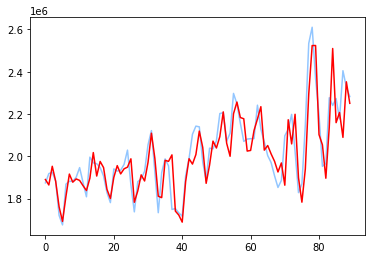

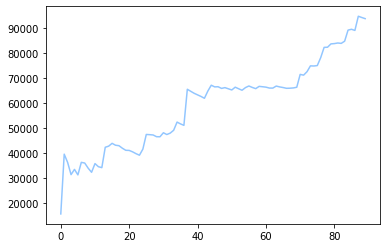

ARIMA(11, 0, 0) RMSE=93706  , actual best : (9, 0, 0) RMSE: 92506
(12, 0, 0)   step =  0
Predicted=1887718.623, Expected=1943332.000, RMSE = 13257
(12, 0, 0)   step =  1
Predicted=1864633.075, Expected=1943332.000, RMSE = 39114
(12, 0, 0)   step =  2
Predicted=1957077.286, Expected=1943332.000, RMSE = 37142
(12, 0, 0)   step =  3
Predicted=1873135.845, Expected=1943332.000, RMSE = 32581
(12, 0, 0)   step =  4
Predicted=1760415.889, Expected=1943332.000, RMSE = 34195
(12, 0, 0)   step =  5
Predicted=1694331.439, Expected=1943332.000, RMSE = 32127
(12, 0, 0)   step =  6
Predicted=1810767.135, Expected=1943332.000, RMSE = 36851
(12, 0, 0)   step =  7
Predicted=1915695.549, Expected=1943332.000, RMSE = 36479
(12, 0, 0)   step =  8
Predicted=1883281.501, Expected=1943332.000, RMSE = 34398
(12, 0, 0)   step =  9
Predicted=1895560.330, Expected=1943332.000, RMSE = 32682
(12, 0, 0)   step =  10
Predicted=1875650.604, Expected=1943332.000, RMSE = 37796
(12, 0, 0)   step =  11
Predicted=1859544.

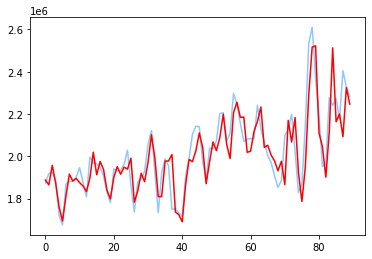

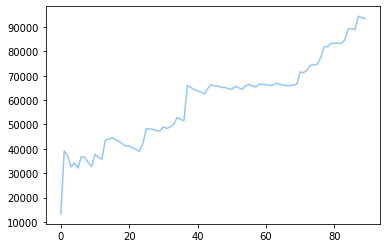

ARIMA(12, 0, 0) RMSE=93504  , actual best : (9, 0, 0) RMSE: 92506
(13, 0, 0)   step =  0
Predicted=1890578.271, Expected=1943332.000, RMSE = 16116
(13, 0, 0)   step =  1
Predicted=1860793.447, Expected=1943332.000, RMSE = 42254
(13, 0, 0)   step =  2
Predicted=1956414.644, Expected=1943332.000, RMSE = 39186
(13, 0, 0)   step =  3
Predicted=1880307.595, Expected=1943332.000, RMSE = 33974
(13, 0, 0)   step =  4
Predicted=1746715.473, Expected=1943332.000, RMSE = 32585
(13, 0, 0)   step =  5
Predicted=1693591.961, Expected=1943332.000, RMSE = 30627
(13, 0, 0)   step =  6
Predicted=1814250.710, Expected=1943332.000, RMSE = 34954
(13, 0, 0)   step =  7
Predicted=1915397.480, Expected=1943332.000, RMSE = 34772
(13, 0, 0)   step =  8
Predicted=1883287.964, Expected=1943332.000, RMSE = 32788
(13, 0, 0)   step =  9
Predicted=1904356.686, Expected=1943332.000, RMSE = 31121
(13, 0, 0)   step =  10
Predicted=1879553.776, Expected=1943332.000, RMSE = 35904
(13, 0, 0)   step =  11
Predicted=1841963.

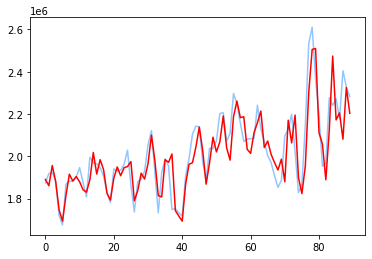

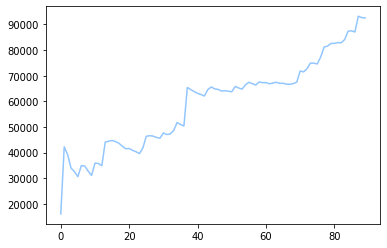

ARIMA(13, 0, 0) RMSE=92513  , actual best : (9, 0, 0) RMSE: 92506
(14, 0, 0)   step =  0
Predicted=1891846.333, Expected=1943332.000, RMSE = 17384
(14, 0, 0)   step =  1
Predicted=1859820.751, Expected=1943332.000, RMSE = 43164
(14, 0, 0)   step =  2
Predicted=1957943.527, Expected=1943332.000, RMSE = 40261
(14, 0, 0)   step =  3
Predicted=1880292.209, Expected=1943332.000, RMSE = 34904
(14, 0, 0)   step =  4
Predicted=1744659.235, Expected=1943332.000, RMSE = 33049
(14, 0, 0)   step =  5
Predicted=1697377.856, Expected=1943332.000, RMSE = 31438
(14, 0, 0)   step =  6
Predicted=1814328.187, Expected=1943332.000, RMSE = 35548
(14, 0, 0)   step =  7
Predicted=1914775.284, Expected=1943332.000, RMSE = 35222
(14, 0, 0)   step =  8
Predicted=1883112.341, Expected=1943332.000, RMSE = 33212
(14, 0, 0)   step =  9
Predicted=1904336.930, Expected=1943332.000, RMSE = 31523
(14, 0, 0)   step =  10
Predicted=1876990.811, Expected=1943332.000, RMSE = 36657
(14, 0, 0)   step =  11
Predicted=1841311.

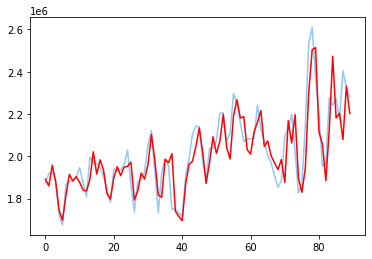

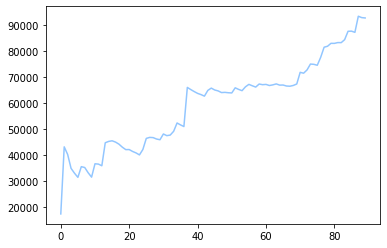

ARIMA(14, 0, 0) RMSE=92707  , actual best : (9, 0, 0) RMSE: 92506
(15, 0, 0)   step =  0
Predicted=1884826.349, Expected=1943332.000, RMSE = 10364
(15, 0, 0)   step =  1
Predicted=1866825.653, Expected=1943332.000, RMSE = 37153
(15, 0, 0)   step =  2
Predicted=1952199.931, Expected=1943332.000, RMSE = 34366
(15, 0, 0)   step =  3
Predicted=1888953.955, Expected=1943332.000, RMSE = 29887
(15, 0, 0)   step =  4
Predicted=1744424.825, Expected=1943332.000, RMSE = 28809
(15, 0, 0)   step =  5
Predicted=1686523.673, Expected=1943332.000, RMSE = 26665
(15, 0, 0)   step =  6
Predicted=1834966.783, Expected=1943332.000, RMSE = 27721
(15, 0, 0)   step =  7
Predicted=1914586.304, Expected=1943332.000, RMSE = 28385
(15, 0, 0)   step =  8
Predicted=1880137.217, Expected=1943332.000, RMSE = 26765
(15, 0, 0)   step =  9
Predicted=1903542.674, Expected=1943332.000, RMSE = 25402
(15, 0, 0)   step =  10
Predicted=1876963.261, Expected=1943332.000, RMSE = 32053
(15, 0, 0)   step =  11
Predicted=1826667.

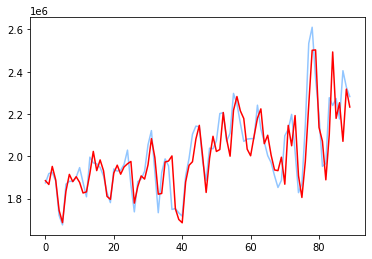

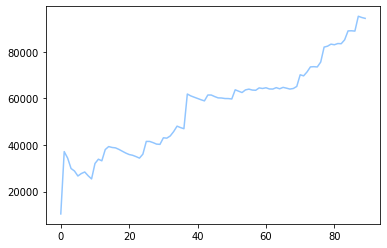

ARIMA(15, 0, 0) RMSE=94428  , actual best : (9, 0, 0) RMSE: 92506
(16, 0, 0)   step =  0
Predicted=1873372.374, Expected=1943332.000, RMSE = 1090
(16, 0, 0)   step =  1
Predicted=1870646.462, Expected=1943332.000, RMSE = 33730
(16, 0, 0)   step =  2
Predicted=1950032.507, Expected=1943332.000, RMSE = 31312
(16, 0, 0)   step =  3
Predicted=1891312.126, Expected=1943332.000, RMSE = 27397
(16, 0, 0)   step =  4
Predicted=1738907.349, Expected=1943332.000, RMSE = 25864
(16, 0, 0)   step =  5
Predicted=1685725.925, Expected=1943332.000, RMSE = 23960
(16, 0, 0)   step =  6
Predicted=1841152.863, Expected=1943332.000, RMSE = 24445
(16, 0, 0)   step =  7
Predicted=1903360.093, Expected=1943332.000, RMSE = 24089
(16, 0, 0)   step =  8
Predicted=1878919.466, Expected=1943332.000, RMSE = 22728
(16, 0, 0)   step =  9
Predicted=1905438.923, Expected=1943332.000, RMSE = 21602
(16, 0, 0)   step =  10
Predicted=1877352.848, Expected=1943332.000, RMSE = 29327
(16, 0, 0)   step =  11
Predicted=1829483.6

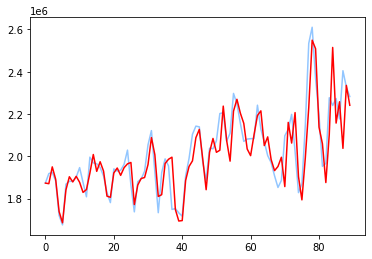

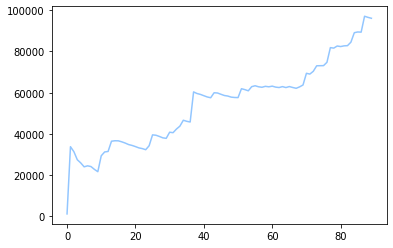

ARIMA(16, 0, 0) RMSE=96113  , actual best : (9, 0, 0) RMSE: 92506
(17, 0, 0)   step =  0
Predicted=1873268.156, Expected=1943332.000, RMSE = 1194
(17, 0, 0)   step =  1
Predicted=1871127.624, Expected=1943332.000, RMSE = 33392
(17, 0, 0)   step =  2
Predicted=1949893.727, Expected=1943332.000, RMSE = 31031
(17, 0, 0)   step =  3
Predicted=1891365.392, Expected=1943332.000, RMSE = 27160
(17, 0, 0)   step =  4
Predicted=1738833.181, Expected=1943332.000, RMSE = 25652
(17, 0, 0)   step =  5
Predicted=1685907.848, Expected=1943332.000, RMSE = 23783
(17, 0, 0)   step =  6
Predicted=1841164.388, Expected=1943332.000, RMSE = 24295
(17, 0, 0)   step =  7
Predicted=1903157.826, Expected=1943332.000, RMSE = 23933
(17, 0, 0)   step =  8
Predicted=1879326.813, Expected=1943332.000, RMSE = 22576
(17, 0, 0)   step =  9
Predicted=1905437.207, Expected=1943332.000, RMSE = 21458
(17, 0, 0)   step =  10
Predicted=1877270.275, Expected=1943332.000, RMSE = 29249
(17, 0, 0)   step =  11
Predicted=1829571.8

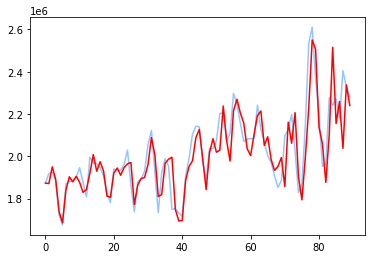

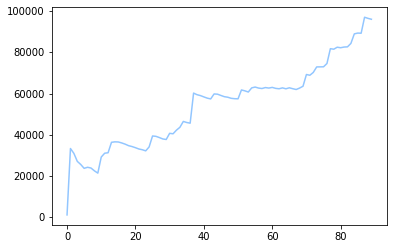

ARIMA(17, 0, 0) RMSE=96073  , actual best : (9, 0, 0) RMSE: 92506
(18, 0, 0)   step =  0
Predicted=1874532.327, Expected=1943332.000, RMSE = 70
(18, 0, 0)   step =  1
Predicted=1871678.598, Expected=1943332.000, RMSE = 32992
(18, 0, 0)   step =  2
Predicted=1947775.848, Expected=1943332.000, RMSE = 30174
(18, 0, 0)   step =  3
Predicted=1891851.562, Expected=1943332.000, RMSE = 26463
(18, 0, 0)   step =  4
Predicted=1738539.152, Expected=1943332.000, RMSE = 25020
(18, 0, 0)   step =  5
Predicted=1686375.479, Expected=1943332.000, RMSE = 23250
(18, 0, 0)   step =  6
Predicted=1840247.688, Expected=1943332.000, RMSE = 23999
(18, 0, 0)   step =  7
Predicted=1903102.333, Expected=1943332.000, RMSE = 23664
(18, 0, 0)   step =  8
Predicted=1880372.018, Expected=1943332.000, RMSE = 22314
(18, 0, 0)   step =  9
Predicted=1903463.082, Expected=1943332.000, RMSE = 21181
(18, 0, 0)   step =  10
Predicted=1877052.190, Expected=1943332.000, RMSE = 29111
(18, 0, 0)   step =  11
Predicted=1829913.905

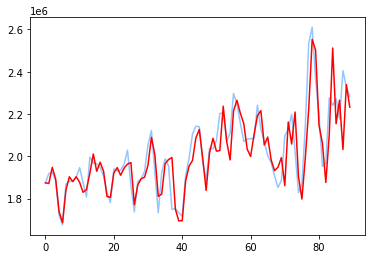

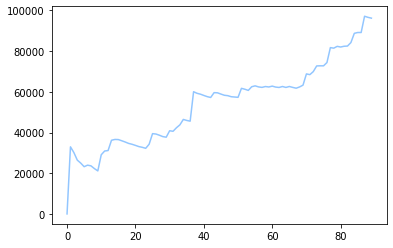

ARIMA(18, 0, 0) RMSE=96170  , actual best : (9, 0, 0) RMSE: 92506
(19, 0, 0)   step =  0
Predicted=1878312.397, Expected=1943332.000, RMSE = 3850
(19, 0, 0)   step =  1
Predicted=1873353.119, Expected=1943332.000, RMSE = 31924
(19, 0, 0)   step =  2
Predicted=1948482.914, Expected=1943332.000, RMSE = 29589
(19, 0, 0)   step =  3
Predicted=1889094.745, Expected=1943332.000, RMSE = 25777
(19, 0, 0)   step =  4
Predicted=1739223.308, Expected=1943332.000, RMSE = 24543
(19, 0, 0)   step =  5
Predicted=1685989.571, Expected=1943332.000, RMSE = 22793
(19, 0, 0)   step =  6
Predicted=1840946.019, Expected=1943332.000, RMSE = 23504
(19, 0, 0)   step =  7
Predicted=1901890.547, Expected=1943332.000, RMSE = 23090
(19, 0, 0)   step =  8
Predicted=1880302.402, Expected=1943332.000, RMSE = 21774
(19, 0, 0)   step =  9
Predicted=1904833.723, Expected=1943332.000, RMSE = 20688
(19, 0, 0)   step =  10
Predicted=1874398.656, Expected=1943332.000, RMSE = 29375
(19, 0, 0)   step =  11
Predicted=1829527.7

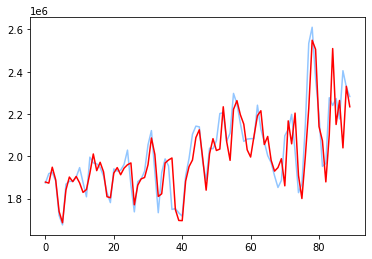

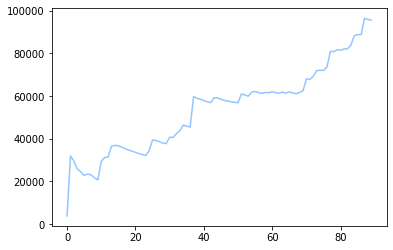

ARIMA(19, 0, 0) RMSE=95500  , actual best : (9, 0, 0) RMSE: 92506
(0, 1, 0)   step =  0
Predicted=1834659.000, Expected=1943332.000, RMSE = 39803
(0, 1, 0)   step =  1
Predicted=1874462.000, Expected=1943332.000, RMSE = 41888
(0, 1, 0)   step =  2
Predicted=1918336.000, Expected=1943332.000, RMSE = 34370
(0, 1, 0)   step =  3
Predicted=1924230.000, Expected=1943332.000, RMSE = 36067
(0, 1, 0)   step =  4
Predicted=1883493.000, Expected=1943332.000, RMSE = 79750
(0, 1, 0)   step =  5
Predicted=1720408.000, Expected=1943332.000, RMSE = 75052
(0, 1, 0)   step =  6
Predicted=1675728.000, Expected=1943332.000, RMSE = 100634
(0, 1, 0)   step =  7
Predicted=1868327.000, Expected=1943332.000, RMSE = 94258
(0, 1, 0)   step =  8
Predicted=1881929.000, Expected=1943332.000, RMSE = 88867
(0, 1, 0)   step =  9
Predicted=1881498.000, Expected=1943332.000, RMSE = 84537
(0, 1, 0)   step =  10
Predicted=1901229.000, Expected=1943332.000, RMSE = 81755
(0, 1, 0)   step =  11
Predicted=1946593.000, Expect

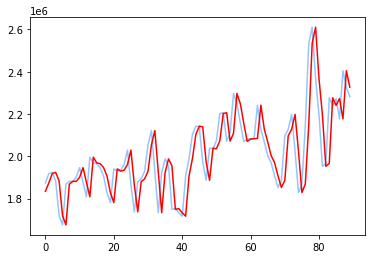

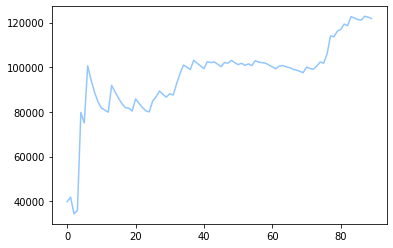

ARIMA(0, 1, 0) RMSE=121795  , actual best : (9, 0, 0) RMSE: 92506
(1, 1, 0)   step =  0
Predicted=1874174.851, Expected=1943332.000, RMSE = 287
(1, 1, 0)   step =  1
Predicted=1881819.452, Expected=1943332.000, RMSE = 25822
(1, 1, 0)   step =  2
Predicted=1926447.396, Expected=1943332.000, RMSE = 21122
(1, 1, 0)   step =  3
Predicted=1925319.666, Expected=1943332.000, RMSE = 27785
(1, 1, 0)   step =  4
Predicted=1875961.885, Expected=1943332.000, RMSE = 73871
(1, 1, 0)   step =  5
Predicted=1690234.981, Expected=1943332.000, RMSE = 67695
(1, 1, 0)   step =  6
Predicted=1667459.196, Expected=1943332.000, RMSE = 98447
(1, 1, 0)   step =  7
Predicted=1903931.930, Expected=1943332.000, RMSE = 92417
(1, 1, 0)   step =  8
Predicted=1884442.248, Expected=1943332.000, RMSE = 87137
(1, 1, 0)   step =  9
Predicted=1881418.364, Expected=1943332.000, RMSE = 82903
(1, 1, 0)   step =  10
Predicted=1904874.685, Expected=1943332.000, RMSE = 80039
(1, 1, 0)   step =  11
Predicted=1954975.717, Expected=

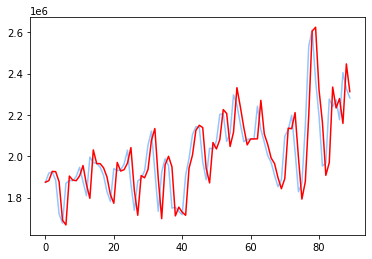

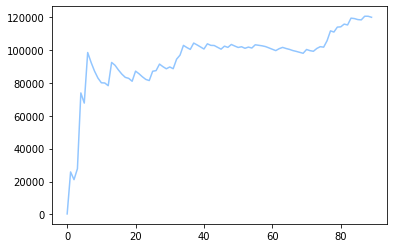

ARIMA(1, 1, 0) RMSE=119875  , actual best : (9, 0, 0) RMSE: 92506
(2, 1, 0)   step =  0
Predicted=1904186.701, Expected=1943332.000, RMSE = 29725
(2, 1, 0)   step =  1
Predicted=1808494.021, Expected=1943332.000, RMSE = 80464
(2, 1, 0)   step =  2
Predicted=1915391.851, Expected=1943332.000, RMSE = 65896
(2, 1, 0)   step =  3
Predicted=1910133.441, Expected=1943332.000, RMSE = 58602
(2, 1, 0)   step =  4
Predicted=1870986.959, Expected=1943332.000, RMSE = 85335
(2, 1, 0)   step =  5
Predicted=1693199.248, Expected=1943332.000, RMSE = 78226
(2, 1, 0)   step =  6
Predicted=1722309.843, Expected=1943332.000, RMSE = 91055
(2, 1, 0)   step =  7
Predicted=1933492.075, Expected=1943332.000, RMSE = 87103
(2, 1, 0)   step =  8
Predicted=1816814.902, Expected=1943332.000, RMSE = 84905
(2, 1, 0)   step =  9
Predicted=1876547.824, Expected=1943332.000, RMSE = 80925
(2, 1, 0)   step =  10
Predicted=1906422.083, Expected=1943332.000, RMSE = 78104
(2, 1, 0)   step =  11
Predicted=1951159.864, Expecte

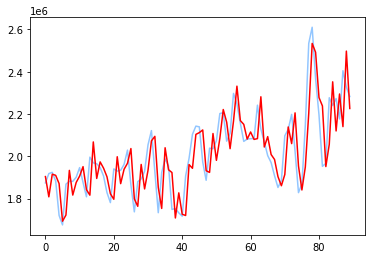

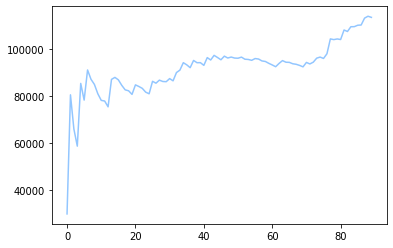

ARIMA(2, 1, 0) RMSE=113473  , actual best : (9, 0, 0) RMSE: 92506
(3, 1, 0)   step =  0
Predicted=1909841.445, Expected=1943332.000, RMSE = 35379
(3, 1, 0)   step =  1
Predicted=1812741.880, Expected=1943332.000, RMSE = 78746
(3, 1, 0)   step =  2
Predicted=1904199.658, Expected=1943332.000, RMSE = 65327
(3, 1, 0)   step =  3
Predicted=1908599.603, Expected=1943332.000, RMSE = 57951
(3, 1, 0)   step =  4
Predicted=1869651.656, Expected=1943332.000, RMSE = 84507
(3, 1, 0)   step =  5
Predicted=1695586.948, Expected=1943332.000, RMSE = 77569
(3, 1, 0)   step =  6
Predicted=1723027.917, Expected=1943332.000, RMSE = 90406
(3, 1, 0)   step =  7
Predicted=1937336.600, Expected=1943332.000, RMSE = 86807
(3, 1, 0)   step =  8
Predicted=1821456.372, Expected=1943332.000, RMSE = 84254
(3, 1, 0)   step =  9
Predicted=1866940.691, Expected=1943332.000, RMSE = 80662
(3, 1, 0)   step =  10
Predicted=1905334.088, Expected=1943332.000, RMSE = 77908
(3, 1, 0)   step =  11
Predicted=1950550.817, Expecte

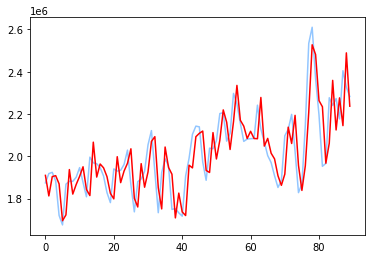

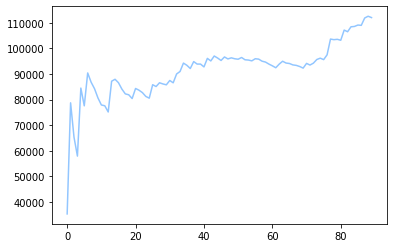

ARIMA(3, 1, 0) RMSE=112021  , actual best : (9, 0, 0) RMSE: 92506
(4, 1, 0)   step =  0
Predicted=1911757.302, Expected=1943332.000, RMSE = 37295
(4, 1, 0)   step =  1
Predicted=1843393.616, Expected=1943332.000, RMSE = 59192
(4, 1, 0)   step =  2
Predicted=1925260.702, Expected=1943332.000, RMSE = 48333
(4, 1, 0)   step =  3
Predicted=1848837.581, Expected=1943332.000, RMSE = 45303
(4, 1, 0)   step =  4
Predicted=1861844.273, Expected=1943332.000, RMSE = 75118
(4, 1, 0)   step =  5
Predicted=1690668.235, Expected=1943332.000, RMSE = 68844
(4, 1, 0)   step =  6
Predicted=1735994.433, Expected=1943332.000, RMSE = 81019
(4, 1, 0)   step =  7
Predicted=1939066.695, Expected=1943332.000, RMSE = 78433
(4, 1, 0)   step =  8
Predicted=1842723.282, Expected=1943332.000, RMSE = 75068
(4, 1, 0)   step =  9
Predicted=1890702.648, Expected=1943332.000, RMSE = 71294
(4, 1, 0)   step =  10
Predicted=1853826.195, Expected=1943332.000, RMSE = 73505
(4, 1, 0)   step =  11
Predicted=1944162.288, Expecte

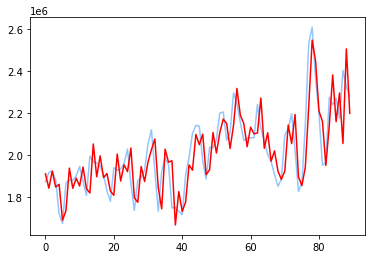

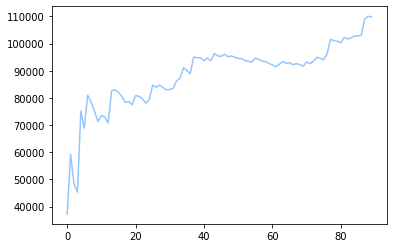

ARIMA(4, 1, 0) RMSE=109789  , actual best : (9, 0, 0) RMSE: 92506
(5, 1, 0)   step =  0
Predicted=1915098.486, Expected=1943332.000, RMSE = 40636
(5, 1, 0)   step =  1
Predicted=1849561.048, Expected=1943332.000, RMSE = 56486
(5, 1, 0)   step =  2
Predicted=1953284.934, Expected=1943332.000, RMSE = 49076
(5, 1, 0)   step =  3
Predicted=1873560.138, Expected=1943332.000, RMSE = 42791
(5, 1, 0)   step =  4
Predicted=1788068.088, Expected=1943332.000, RMSE = 48789
(5, 1, 0)   step =  5
Predicted=1696220.700, Expected=1943332.000, RMSE = 45317
(5, 1, 0)   step =  6
Predicted=1731842.661, Expected=1943332.000, RMSE = 66494
(5, 1, 0)   step =  7
Predicted=1940688.771, Expected=1943332.000, RMSE = 65577
(5, 1, 0)   step =  8
Predicted=1850745.270, Expected=1943332.000, RMSE = 62671
(5, 1, 0)   step =  9
Predicted=1911468.411, Expected=1943332.000, RMSE = 59543
(5, 1, 0)   step =  10
Predicted=1880564.034, Expected=1943332.000, RMSE = 60161
(5, 1, 0)   step =  11
Predicted=1874005.354, Expecte

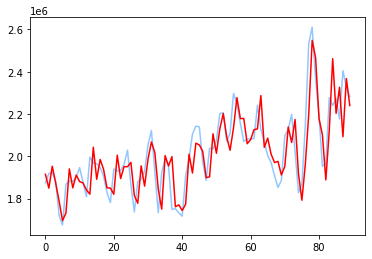

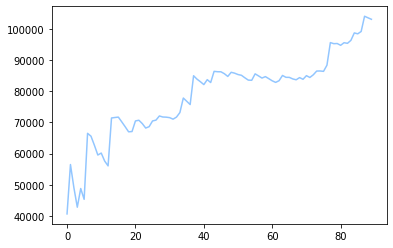

ARIMA(5, 1, 0) RMSE=103098  , actual best : (9, 0, 0) RMSE: 92506
(6, 1, 0)   step =  0
Predicted=1914946.885, Expected=1943332.000, RMSE = 40485
(6, 1, 0)   step =  1
Predicted=1850054.726, Expected=1943332.000, RMSE = 56131
(6, 1, 0)   step =  2
Predicted=1953060.012, Expected=1943332.000, RMSE = 48760
(6, 1, 0)   step =  3
Predicted=1875237.259, Expected=1943332.000, RMSE = 42428
(6, 1, 0)   step =  4
Predicted=1789258.005, Expected=1943332.000, RMSE = 48869
(6, 1, 0)   step =  5
Predicted=1692927.078, Expected=1943332.000, RMSE = 45160
(6, 1, 0)   step =  6
Predicted=1732292.784, Expected=1943332.000, RMSE = 66270
(6, 1, 0)   step =  7
Predicted=1939430.154, Expected=1943332.000, RMSE = 65239
(6, 1, 0)   step =  8
Predicted=1851296.903, Expected=1943332.000, RMSE = 62326
(6, 1, 0)   step =  9
Predicted=1911635.106, Expected=1943332.000, RMSE = 59219
(6, 1, 0)   step =  10
Predicted=1881733.764, Expected=1943332.000, RMSE = 59754
(6, 1, 0)   step =  11
Predicted=1874883.226, Expecte

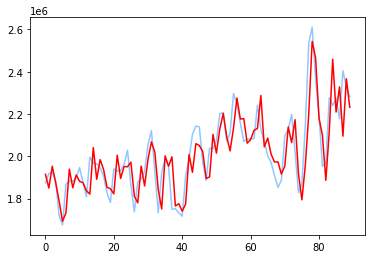

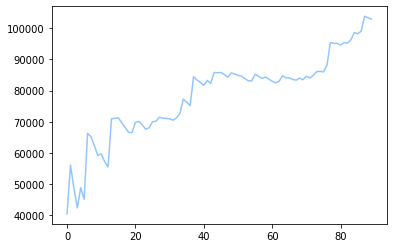

ARIMA(6, 1, 0) RMSE=102879  , actual best : (9, 0, 0) RMSE: 92506
(7, 1, 0)   step =  0
Predicted=1904984.731, Expected=1943332.000, RMSE = 30523
(7, 1, 0)   step =  1
Predicted=1852413.805, Expected=1943332.000, RMSE = 51368
(7, 1, 0)   step =  2
Predicted=1945910.137, Expected=1943332.000, RMSE = 43770
(7, 1, 0)   step =  3
Predicted=1878344.926, Expected=1943332.000, RMSE = 37993
(7, 1, 0)   step =  4
Predicted=1762501.659, Expected=1943332.000, RMSE = 38848
(7, 1, 0)   step =  5
Predicted=1673252.956, Expected=1943332.000, RMSE = 35477
(7, 1, 0)   step =  6
Predicted=1784750.222, Expected=1943332.000, RMSE = 45571
(7, 1, 0)   step =  7
Predicted=1933688.845, Expected=1943332.000, RMSE = 46390
(7, 1, 0)   step =  8
Predicted=1870988.491, Expected=1943332.000, RMSE = 43877
(7, 1, 0)   step =  9
Predicted=1903265.915, Expected=1943332.000, RMSE = 41630
(7, 1, 0)   step =  10
Predicted=1878827.874, Expected=1943332.000, RMSE = 44643
(7, 1, 0)   step =  11
Predicted=1856993.047, Expecte

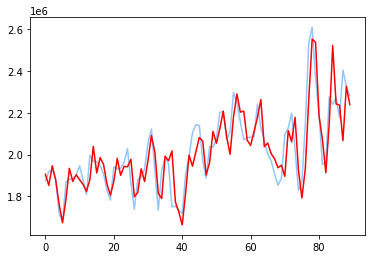

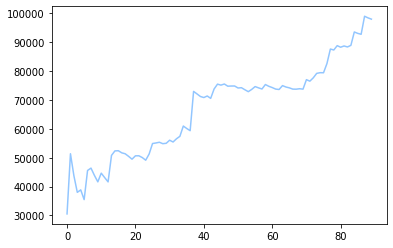

ARIMA(7, 1, 0) RMSE=97995  , actual best : (9, 0, 0) RMSE: 92506
(8, 1, 0)   step =  0
Predicted=1883077.443, Expected=1943332.000, RMSE = 8615
(8, 1, 0)   step =  1
Predicted=1856064.694, Expected=1943332.000, RMSE = 44452
(8, 1, 0)   step =  2
Predicted=1950466.197, Expected=1943332.000, RMSE = 39329
(8, 1, 0)   step =  3
Predicted=1881336.871, Expected=1943332.000, RMSE = 34077
(8, 1, 0)   step =  4
Predicted=1760963.047, Expected=1943332.000, RMSE = 35467
(8, 1, 0)   step =  5
Predicted=1687252.913, Expected=1943332.000, RMSE = 32717
(8, 1, 0)   step =  6
Predicted=1798039.349, Expected=1943332.000, RMSE = 40290
(8, 1, 0)   step =  7
Predicted=1906047.943, Expected=1943332.000, RMSE = 38640
(8, 1, 0)   step =  8
Predicted=1870055.330, Expected=1943332.000, RMSE = 36629
(8, 1, 0)   step =  9
Predicted=1891543.016, Expected=1943332.000, RMSE = 34885
(8, 1, 0)   step =  10
Predicted=1884260.580, Expected=1943332.000, RMSE = 38204
(8, 1, 0)   step =  11
Predicted=1864812.993, Expected=

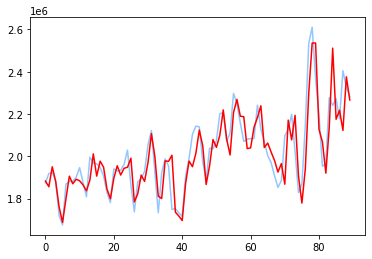

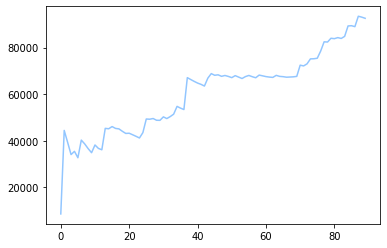

ARIMA(8, 1, 0) RMSE=92565  , actual best : (9, 0, 0) RMSE: 92506
(9, 1, 0)   step =  0
Predicted=1882733.239, Expected=1943332.000, RMSE = 8271
(9, 1, 0)   step =  1
Predicted=1856614.751, Expected=1943332.000, RMSE = 44034
(9, 1, 0)   step =  2
Predicted=1950476.731, Expected=1943332.000, RMSE = 39016
(9, 1, 0)   step =  3
Predicted=1881159.973, Expected=1943332.000, RMSE = 33809
(9, 1, 0)   step =  4
Predicted=1760900.728, Expected=1943332.000, RMSE = 35247
(9, 1, 0)   step =  5
Predicted=1687215.727, Expected=1943332.000, RMSE = 32516
(9, 1, 0)   step =  6
Predicted=1797636.019, Expected=1943332.000, RMSE = 40251
(9, 1, 0)   step =  7
Predicted=1905839.698, Expected=1943332.000, RMSE = 38589
(9, 1, 0)   step =  8
Predicted=1870732.519, Expected=1943332.000, RMSE = 36559
(9, 1, 0)   step =  9
Predicted=1891584.523, Expected=1943332.000, RMSE = 34816
(9, 1, 0)   step =  10
Predicted=1884586.151, Expected=1943332.000, RMSE = 38099
(9, 1, 0)   step =  11
Predicted=1864797.087, Expected=

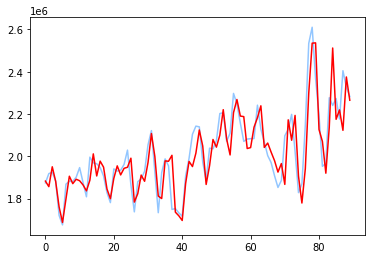

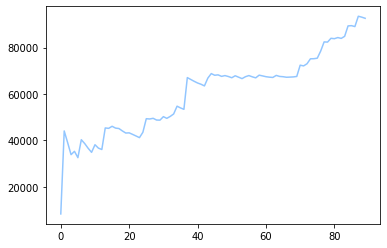

ARIMA(9, 1, 0) RMSE=92591  , actual best : (9, 0, 0) RMSE: 92506
(10, 1, 0)   step =  0
Predicted=1882861.428, Expected=1943332.000, RMSE = 8399
(10, 1, 0)   step =  1
Predicted=1859920.699, Expected=1943332.000, RMSE = 41731
(10, 1, 0)   step =  2
Predicted=1945455.670, Expected=1943332.000, RMSE = 36210
(10, 1, 0)   step =  3
Predicted=1880999.771, Expected=1943332.000, RMSE = 31383
(10, 1, 0)   step =  4
Predicted=1762375.099, Expected=1943332.000, RMSE = 33766
(10, 1, 0)   step =  5
Predicted=1687779.703, Expected=1943332.000, RMSE = 31215
(10, 1, 0)   step =  6
Predicted=1797912.831, Expected=1943332.000, RMSE = 39287
(10, 1, 0)   step =  7
Predicted=1909413.812, Expected=1943332.000, RMSE = 38013
(10, 1, 0)   step =  8
Predicted=1872766.944, Expected=1943332.000, RMSE = 35957
(10, 1, 0)   step =  9
Predicted=1885451.678, Expected=1943332.000, RMSE = 34474
(10, 1, 0)   step =  10
Predicted=1884186.700, Expected=1943332.000, RMSE = 37875
(10, 1, 0)   step =  11
Predicted=1861891.27

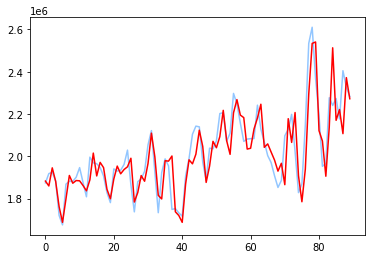

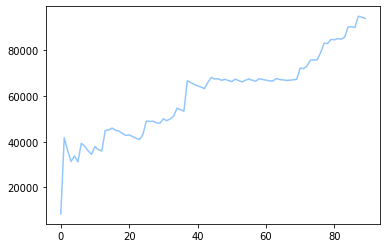

ARIMA(10, 1, 0) RMSE=93969  , actual best : (9, 0, 0) RMSE: 92506
(11, 1, 0)   step =  0
Predicted=1880669.762, Expected=1943332.000, RMSE = 6208
(11, 1, 0)   step =  1
Predicted=1860099.218, Expected=1943332.000, RMSE = 41413
(11, 1, 0)   step =  2
Predicted=1950667.413, Expected=1943332.000, RMSE = 37099
(11, 1, 0)   step =  3
Predicted=1872416.738, Expected=1943332.000, RMSE = 32602
(11, 1, 0)   step =  4
Predicted=1762113.837, Expected=1943332.000, RMSE = 34615
(11, 1, 0)   step =  5
Predicted=1690619.543, Expected=1943332.000, RMSE = 32179
(11, 1, 0)   step =  6
Predicted=1799021.053, Expected=1943332.000, RMSE = 39670
(11, 1, 0)   step =  7
Predicted=1909519.968, Expected=1943332.000, RMSE = 38369
(11, 1, 0)   step =  8
Predicted=1879125.632, Expected=1943332.000, RMSE = 36183
(11, 1, 0)   step =  9
Predicted=1888822.310, Expected=1943332.000, RMSE = 34550
(11, 1, 0)   step =  10
Predicted=1873410.103, Expected=1943332.000, RMSE = 39649
(11, 1, 0)   step =  11
Predicted=1860783.3

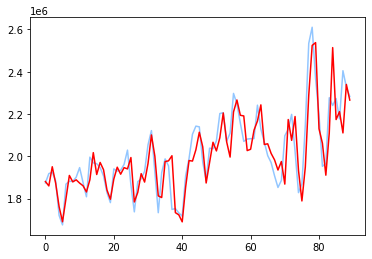

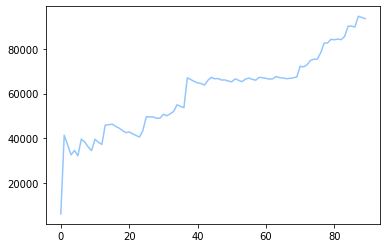

ARIMA(11, 1, 0) RMSE=93583  , actual best : (9, 0, 0) RMSE: 92506
(12, 1, 0)   step =  0
Predicted=1884287.479, Expected=1943332.000, RMSE = 9825
(12, 1, 0)   step =  1
Predicted=1856868.788, Expected=1943332.000, RMSE = 44016
(12, 1, 0)   step =  2
Predicted=1949925.809, Expected=1943332.000, RMSE = 38880
(12, 1, 0)   step =  3
Predicted=1880380.046, Expected=1943332.000, RMSE = 33707
(12, 1, 0)   step =  4
Predicted=1749646.471, Expected=1943332.000, RMSE = 32862
(12, 1, 0)   step =  5
Predicted=1691040.617, Expected=1943332.000, RMSE = 30643
(12, 1, 0)   step =  6
Predicted=1803432.203, Expected=1943332.000, RMSE = 37503
(12, 1, 0)   step =  7
Predicted=1909837.935, Expected=1943332.000, RMSE = 36442
(12, 1, 0)   step =  8
Predicted=1879589.542, Expected=1943332.000, RMSE = 34364
(12, 1, 0)   step =  9
Predicted=1897933.919, Expected=1943332.000, RMSE = 32617
(12, 1, 0)   step =  10
Predicted=1878065.206, Expected=1943332.000, RMSE = 37337
(12, 1, 0)   step =  11
Predicted=1843997.6

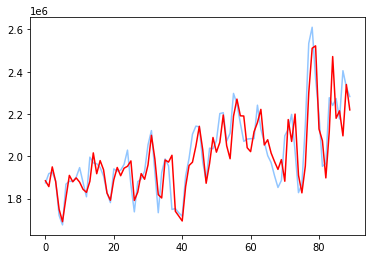

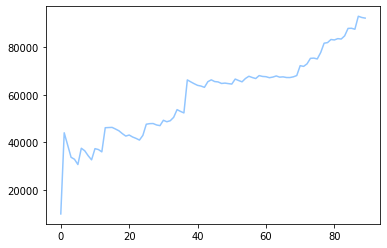

ARIMA(12, 1, 0) RMSE=92350  , actual best : (12, 1, 0) RMSE: 92350
(13, 1, 0)   step =  0
Predicted=1885416.114, Expected=1943332.000, RMSE = 10954
(13, 1, 0)   step =  1
Predicted=1855789.880, Expected=1943332.000, RMSE = 44900
(13, 1, 0)   step =  2
Predicted=1951261.135, Expected=1943332.000, RMSE = 39844
(13, 1, 0)   step =  3
Predicted=1880400.825, Expected=1943332.000, RMSE = 34541
(13, 1, 0)   step =  4
Predicted=1747520.944, Expected=1943332.000, RMSE = 33188
(13, 1, 0)   step =  5
Predicted=1694160.914, Expected=1943332.000, RMSE = 31217
(13, 1, 0)   step =  6
Predicted=1803226.068, Expected=1943332.000, RMSE = 37957
(13, 1, 0)   step =  7
Predicted=1909140.541, Expected=1943332.000, RMSE = 36786
(13, 1, 0)   step =  8
Predicted=1879272.017, Expected=1943332.000, RMSE = 34690
(13, 1, 0)   step =  9
Predicted=1897835.403, Expected=1943332.000, RMSE = 32928
(13, 1, 0)   step =  10
Predicted=1875665.840, Expected=1943332.000, RMSE = 37987
(13, 1, 0)   step =  11
Predicted=1843260

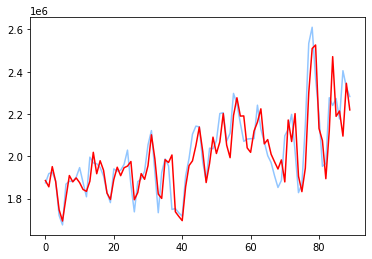

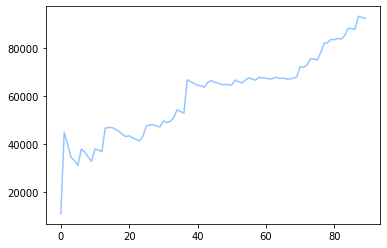

ARIMA(13, 1, 0) RMSE=92563  , actual best : (12, 1, 0) RMSE: 92350
(14, 1, 0)   step =  0
Predicted=1877145.505, Expected=1943332.000, RMSE = 2684
(14, 1, 0)   step =  1
Predicted=1861919.418, Expected=1943332.000, RMSE = 39938
(14, 1, 0)   step =  2
Predicted=1945027.677, Expected=1943332.000, RMSE = 34749
(14, 1, 0)   step =  3
Predicted=1887536.761, Expected=1943332.000, RMSE = 30162
(14, 1, 0)   step =  4
Predicted=1747312.917, Expected=1943332.000, RMSE = 29539
(14, 1, 0)   step =  5
Predicted=1683023.316, Expected=1943332.000, RMSE = 27129
(14, 1, 0)   step =  6
Predicted=1820423.673, Expected=1943332.000, RMSE = 30963
(14, 1, 0)   step =  7
Predicted=1907576.003, Expected=1943332.000, RMSE = 30349
(14, 1, 0)   step =  8
Predicted=1875742.248, Expected=1943332.000, RMSE = 28678
(14, 1, 0)   step =  9
Predicted=1896251.593, Expected=1943332.000, RMSE = 27251
(14, 1, 0)   step =  10
Predicted=1874850.191, Expected=1943332.000, RMSE = 33809
(14, 1, 0)   step =  11
Predicted=1829402.

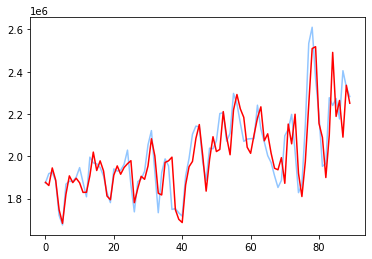

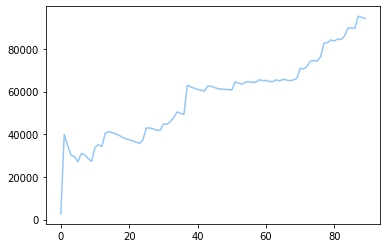

ARIMA(14, 1, 0) RMSE=94321  , actual best : (12, 1, 0) RMSE: 92350
(15, 1, 0)   step =  0
Predicted=1867136.982, Expected=1943332.000, RMSE = 7325
(15, 1, 0)   step =  1
Predicted=1867066.683, Expected=1943332.000, RMSE = 36621
(15, 1, 0)   step =  2
Predicted=1943635.047, Expected=1943332.000, RMSE = 31931
(15, 1, 0)   step =  3
Predicted=1891130.120, Expected=1943332.000, RMSE = 27915
(15, 1, 0)   step =  4
Predicted=1742237.963, Expected=1943332.000, RMSE = 26809
(15, 1, 0)   step =  5
Predicted=1682029.246, Expected=1943332.000, RMSE = 24608
(15, 1, 0)   step =  6
Predicted=1827671.185, Expected=1943332.000, RMSE = 27480
(15, 1, 0)   step =  7
Predicted=1897750.612, Expected=1943332.000, RMSE = 26307
(15, 1, 0)   step =  8
Predicted=1875519.694, Expected=1943332.000, RMSE = 24883
(15, 1, 0)   step =  9
Predicted=1899190.663, Expected=1943332.000, RMSE = 23615
(15, 1, 0)   step =  10
Predicted=1876352.829, Expected=1943332.000, RMSE = 30911
(15, 1, 0)   step =  11
Predicted=1832702.

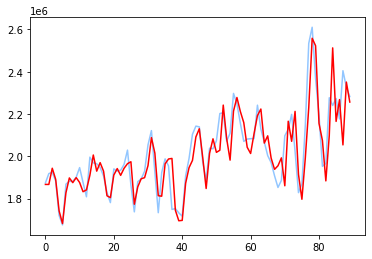

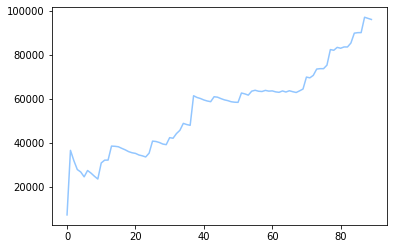

ARIMA(15, 1, 0) RMSE=96024  , actual best : (12, 1, 0) RMSE: 92350
(16, 1, 0)   step =  0
Predicted=1866945.195, Expected=1943332.000, RMSE = 7517
(16, 1, 0)   step =  1
Predicted=1867620.436, Expected=1943332.000, RMSE = 36253
(16, 1, 0)   step =  2
Predicted=1943472.894, Expected=1943332.000, RMSE = 31617
(16, 1, 0)   step =  3
Predicted=1891182.056, Expected=1943332.000, RMSE = 27650
(16, 1, 0)   step =  4
Predicted=1742042.647, Expected=1943332.000, RMSE = 26556
(16, 1, 0)   step =  5
Predicted=1682288.008, Expected=1943332.000, RMSE = 24389
(16, 1, 0)   step =  6
Predicted=1827715.999, Expected=1943332.000, RMSE = 27303
(16, 1, 0)   step =  7
Predicted=1897408.519, Expected=1943332.000, RMSE = 26120
(16, 1, 0)   step =  8
Predicted=1876040.987, Expected=1943332.000, RMSE = 24693
(16, 1, 0)   step =  9
Predicted=1899193.785, Expected=1943332.000, RMSE = 23435
(16, 1, 0)   step =  10
Predicted=1876195.949, Expected=1943332.000, RMSE = 30819
(16, 1, 0)   step =  11
Predicted=1832761.

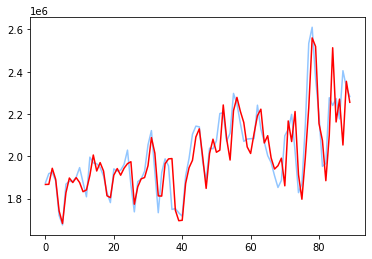

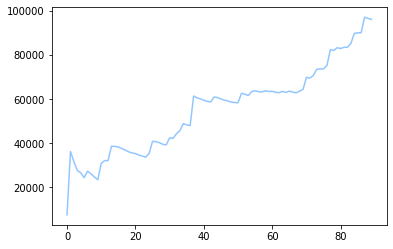

ARIMA(16, 1, 0) RMSE=95973  , actual best : (12, 1, 0) RMSE: 92350
(17, 1, 0)   step =  0
Predicted=1868287.942, Expected=1943332.000, RMSE = 6174
(17, 1, 0)   step =  1
Predicted=1868353.434, Expected=1943332.000, RMSE = 35612
(17, 1, 0)   step =  2
Predicted=1941561.475, Expected=1943332.000, RMSE = 30750
(17, 1, 0)   step =  3
Predicted=1891809.329, Expected=1943332.000, RMSE = 26953
(17, 1, 0)   step =  4
Predicted=1741865.581, Expected=1943332.000, RMSE = 25947
(17, 1, 0)   step =  5
Predicted=1682881.567, Expected=1943332.000, RMSE = 23866
(17, 1, 0)   step =  6
Predicted=1826914.996, Expected=1943332.000, RMSE = 27078
(17, 1, 0)   step =  7
Predicted=1897357.122, Expected=1943332.000, RMSE = 25910
(17, 1, 0)   step =  8
Predicted=1877169.791, Expected=1943332.000, RMSE = 24470
(17, 1, 0)   step =  9
Predicted=1897502.253, Expected=1943332.000, RMSE = 23245
(17, 1, 0)   step =  10
Predicted=1876115.753, Expected=1943332.000, RMSE = 30704
(17, 1, 0)   step =  11
Predicted=1833266.

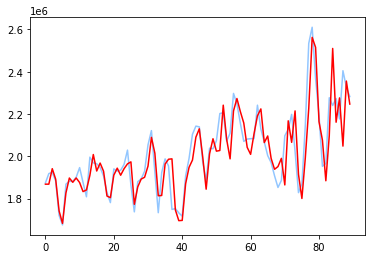

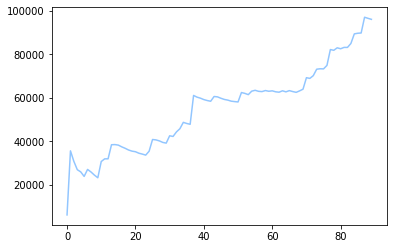

ARIMA(17, 1, 0) RMSE=96046  , actual best : (12, 1, 0) RMSE: 92350
(18, 1, 0)   step =  0
Predicted=1872854.669, Expected=1943332.000, RMSE = 1607
(18, 1, 0)   step =  1
Predicted=1870233.551, Expected=1943332.000, RMSE = 34033
(18, 1, 0)   step =  2
Predicted=1942386.850, Expected=1943332.000, RMSE = 29699
(18, 1, 0)   step =  3
Predicted=1889077.920, Expected=1943332.000, RMSE = 25871
(18, 1, 0)   step =  4
Predicted=1742894.377, Expected=1943332.000, RMSE = 25231
(18, 1, 0)   step =  5
Predicted=1682614.326, Expected=1943332.000, RMSE = 23203
(18, 1, 0)   step =  6
Predicted=1827912.981, Expected=1943332.000, RMSE = 26359
(18, 1, 0)   step =  7
Predicted=1896150.742, Expected=1943332.000, RMSE = 25164
(18, 1, 0)   step =  8
Predicted=1876992.078, Expected=1943332.000, RMSE = 23773
(18, 1, 0)   step =  9
Predicted=1899105.135, Expected=1943332.000, RMSE = 22563
(18, 1, 0)   step =  10
Predicted=1873593.708, Expected=1943332.000, RMSE = 30777
(18, 1, 0)   step =  11
Predicted=1833062.

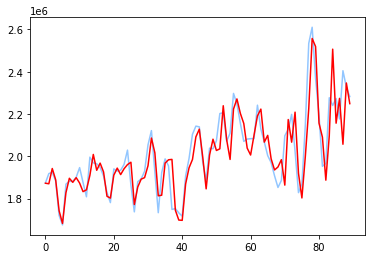

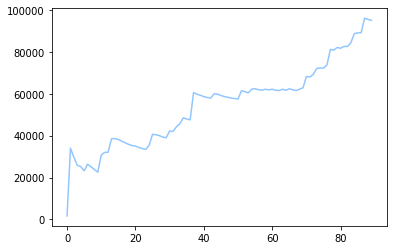

ARIMA(18, 1, 0) RMSE=95283  , actual best : (12, 1, 0) RMSE: 92350
(19, 1, 0)   step =  0
Predicted=1876540.199, Expected=1943332.000, RMSE = 2078
(19, 1, 0)   step =  1
Predicted=1877000.424, Expected=1943332.000, RMSE = 29266
(19, 1, 0)   step =  2
Predicted=1945233.018, Expected=1943332.000, RMSE = 26796
(19, 1, 0)   step =  3
Predicted=1890479.164, Expected=1943332.000, RMSE = 23467
(19, 1, 0)   step =  4
Predicted=1738712.462, Expected=1943332.000, RMSE = 22530
(19, 1, 0)   step =  5
Predicted=1684349.808, Expected=1943332.000, RMSE = 20866
(19, 1, 0)   step =  6
Predicted=1827605.647, Expected=1943332.000, RMSE = 24700
(19, 1, 0)   step =  7
Predicted=1897403.458, Expected=1943332.000, RMSE = 23743
(19, 1, 0)   step =  8
Predicted=1875026.037, Expected=1943332.000, RMSE = 22489
(19, 1, 0)   step =  9
Predicted=1898915.202, Expected=1943332.000, RMSE = 21348
(19, 1, 0)   step =  10
Predicted=1876095.280, Expected=1943332.000, RMSE = 29430
(19, 1, 0)   step =  11
Predicted=1828868.

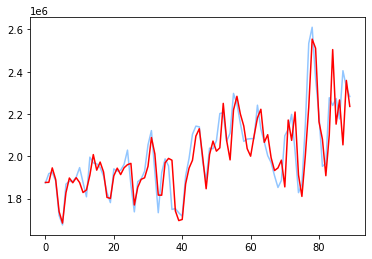

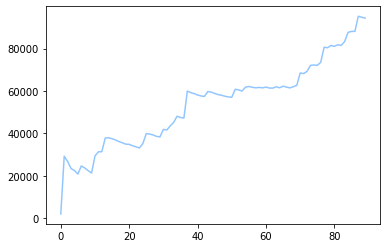

ARIMA(19, 1, 0) RMSE=94385  , actual best : (12, 1, 0) RMSE: 92350
(0, 0, 1)   step =  0
Predicted=1933172.964, Expected=1943332.000, RMSE = 58711
(0, 0, 1)   step =  1


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1887292.353, Expected=1943332.000, RMSE = 46961
(0, 0, 1)   step =  2
Predicted=1966456.669, Expected=1943332.000, RMSE = 45438
(0, 0, 1)   step =  3


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1901809.984, Expected=1943332.000, RMSE = 40402
(0, 0, 1)   step =  4
Predicted=1922888.655, Expected=1943332.000, RMSE = 97496
(0, 0, 1)   step =  5


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1760362.167, Expected=1943332.000, RMSE = 95473
(0, 0, 1)   step =  6
Predicted=1864232.948, Expected=1943332.000, RMSE = 88404
(0, 0, 1)   step =  7


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1942440.502, Expected=1943332.000, RMSE = 85417
(0, 0, 1)   step =  8
Predicted=1885417.862, Expected=1943332.000, RMSE = 80543
(0, 0, 1)   step =  9


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1935322.026, Expected=1943332.000, RMSE = 77167
(0, 0, 1)   step =  10
Predicted=1908682.928, Expected=1943332.000, RMSE = 74458
(0, 0, 1)   step =  11


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1972202.332, Expected=1943332.000, RMSE = 76458
(0, 0, 1)   step =  12
Predicted=1854278.624, Expected=1943332.000, RMSE = 74537
(0, 0, 1)   step =  13


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1898522.777, Expected=1943332.000, RMSE = 76406
(0, 0, 1)   step =  14
Predicted=2024714.907, Expected=1943332.000, RMSE = 75207
(0, 0, 1)   step =  15


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1889507.847, Expected=1943332.000, RMSE = 75222
(0, 0, 1)   step =  16
Predicted=2005277.766, Expected=1943332.000, RMSE = 74328
(0, 0, 1)   step =  17


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1887380.440, Expected=1943332.000, RMSE = 72383
(0, 0, 1)   step =  18
Predicted=1956051.702, Expected=1943332.000, RMSE = 76277
(0, 0, 1)   step =  19


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1826278.105, Expected=1943332.000, RMSE = 75028
(0, 0, 1)   step =  20
Predicted=1898834.231, Expected=1943332.000, RMSE = 73782
(0, 0, 1)   step =  21


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1975385.014, Expected=1943332.000, RMSE = 72729
(0, 0, 1)   step =  22
Predicted=1898688.920, Expected=1943332.000, RMSE = 71511
(0, 0, 1)   step =  23


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1969814.402, Expected=1943332.000, RMSE = 70026
(0, 0, 1)   step =  24
Predicted=1931341.004, Expected=1943332.000, RMSE = 71351
(0, 0, 1)   step =  25


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2025011.404, Expected=1943332.000, RMSE = 76714
(0, 0, 1)   step =  26
Predicted=1797095.739, Expected=1943332.000, RMSE = 76150
(0, 0, 1)   step =  27


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1885983.954, Expected=1943332.000, RMSE = 74786
(0, 0, 1)   step =  28
Predicted=1933273.999, Expected=1943332.000, RMSE = 73862
(0, 0, 1)   step =  29


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1903129.455, Expected=1943332.000, RMSE = 72777
(0, 0, 1)   step =  30
Predicted=1961569.089, Expected=1943332.000, RMSE = 73500
(0, 0, 1)   step =  31


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2020214.724, Expected=1943332.000, RMSE = 74529
(0, 0, 1)   step =  32
Predicted=2028020.659, Expected=1943332.000, RMSE = 75473
(0, 0, 1)   step =  33


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1849383.117, Expected=1943332.000, RMSE = 76967
(0, 0, 1)   step =  34
Predicted=1836289.135, Expected=1943332.000, RMSE = 77271
(0, 0, 1)   step =  35


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2015266.024, Expected=1943332.000, RMSE = 76328
(0, 0, 1)   step =  36
Predicted=1914279.078, Expected=1943332.000, RMSE = 75582
(0, 0, 1)   step =  37


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1974200.914, Expected=1943332.000, RMSE = 83051
(0, 0, 1)   step =  38
Predicted=1739799.912, Expected=1943332.000, RMSE = 82006
(0, 0, 1)   step =  39


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1949964.288, Expected=1943332.000, RMSE = 87960
(0, 0, 1)   step =  40
Predicted=1746747.898, Expected=1943332.000, RMSE = 87005
(0, 0, 1)   step =  41


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1912105.823, Expected=1943332.000, RMSE = 85966
(0, 0, 1)   step =  42
Predicted=1933897.596, Expected=1943332.000, RMSE = 85393
(0, 0, 1)   step =  43


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1987850.333, Expected=1943332.000, RMSE = 86221
(0, 0, 1)   step =  44


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2040904.657, Expected=1943332.000, RMSE = 86598
(0, 0, 1)   step =  45


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2028144.766, Expected=1943332.000, RMSE = 87203
(0, 0, 1)   step =  46
Predicted=2036413.037, Expected=1943332.000, RMSE = 86767
(0, 0, 1)   step =  47


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1882440.946, Expected=1943332.000, RMSE = 85860
(0, 0, 1)   step =  48
Predicted=1942198.953, Expected=1943332.000, RMSE = 86086
(0, 0, 1)   step =  49


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2023433.876, Expected=1943332.000, RMSE = 85239
(0, 0, 1)   step =  50
Predicted=1949333.629, Expected=1943332.000, RMSE = 86174
(0, 0, 1)   step =  51


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2048180.231, Expected=1943332.000, RMSE = 87970
(0, 0, 1)   step =  52
Predicted=2074409.982, Expected=1943332.000, RMSE = 88994
(0, 0, 1)   step =  53


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2054954.885, Expected=1943332.000, RMSE = 88196
(0, 0, 1)   step =  54
Predicted=1953552.303, Expected=1943332.000, RMSE = 89872
(0, 0, 1)   step =  55


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2076102.266, Expected=1943332.000, RMSE = 93840
(0, 0, 1)   step =  56
Predicted=2134068.854, Expected=1943332.000, RMSE = 94235
(0, 0, 1)   step =  57


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2039857.539, Expected=1943332.000, RMSE = 94669
(0, 0, 1)   step =  58
Predicted=2042263.205, Expected=1943332.000, RMSE = 93936
(0, 0, 1)   step =  59


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1964237.017, Expected=1943332.000, RMSE = 94372
(0, 0, 1)   step =  60
Predicted=2042813.871, Expected=1943332.000, RMSE = 93739
(0, 0, 1)   step =  61


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1975151.466, Expected=1943332.000, RMSE = 94002
(0, 0, 1)   step =  62
Predicted=2035533.402, Expected=1943332.000, RMSE = 96803
(0, 0, 1)   step =  63


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2121451.858, Expected=1943332.000, RMSE = 96048
(0, 0, 1)   step =  64
Predicted=1946030.221, Expected=1943332.000, RMSE = 96503
(0, 0, 1)   step =  65


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2047484.479, Expected=1943332.000, RMSE = 95923
(0, 0, 1)   step =  66
Predicted=1900780.579, Expected=1943332.000, RMSE = 95582
(0, 0, 1)   step =  67


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2001050.443, Expected=1943332.000, RMSE = 95545
(0, 0, 1)   step =  68
Predicted=1857723.133, Expected=1943332.000, RMSE = 94852
(0, 0, 1)   step =  69


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1935377.518, Expected=1943332.000, RMSE = 94357
(0, 0, 1)   step =  70
Predicted=1896093.392, Expected=1943332.000, RMSE = 96679
(0, 0, 1)   step =  71


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2117016.883, Expected=1943332.000, RMSE = 96013
(0, 0, 1)   step =  72
Predicted=1949034.008, Expected=1943332.000, RMSE = 99713
(0, 0, 1)   step =  73


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2159583.064, Expected=1943332.000, RMSE = 100291
(0, 0, 1)   step =  74
Predicted=1820130.175, Expected=1943332.000, RMSE = 99625
(0, 0, 1)   step =  75


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1947134.262, Expected=1943332.000, RMSE = 99365
(0, 0, 1)   step =  76
Predicted=1871645.394, Expected=1943332.000, RMSE = 103594
(0, 0, 1)   step =  77


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2182705.043, Expected=1943332.000, RMSE = 110336
(0, 0, 1)   step =  78


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2249314.481, Expected=1943332.000, RMSE = 116907
(0, 0, 1)   step =  79
Predicted=2258334.992, Expected=1943332.000, RMSE = 116810
(0, 0, 1)   step =  80


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2036457.957, Expected=1943332.000, RMSE = 117422
(0, 0, 1)   step =  81
Predicted=2080768.638, Expected=1943332.000, RMSE = 117557
(0, 0, 1)   step =  82


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1828005.005, Expected=1943332.000, RMSE = 117829
(0, 0, 1)   step =  83


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2062604.548, Expected=1943332.000, RMSE = 119436
(0, 0, 1)   step =  84
Predicted=2129542.268, Expected=1943332.000, RMSE = 119337
(0, 0, 1)   step =  85


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2038522.399, Expected=1943332.000, RMSE = 121307
(0, 0, 1)   step =  86
Predicted=2147776.928, Expected=1943332.000, RMSE = 120647
(0, 0, 1)   step =  87


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1966703.025, Expected=1943332.000, RMSE = 128724
(0, 0, 1)   step =  88
Predicted=2327528.982, Expected=1943332.000, RMSE = 127999
(0, 0, 1)   step =  89


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1940954.907, Expected=1943332.000, RMSE = 132277


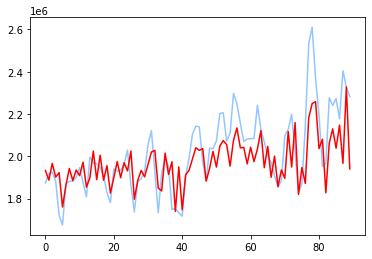

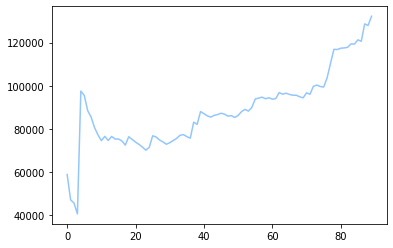

ARIMA(0, 0, 1) RMSE=132277  , actual best : (12, 1, 0) RMSE: 92350
(1, 0, 1)   step =  0
Predicted=1931112.840, Expected=1943332.000, RMSE = 56651
(1, 0, 1)   step =  1
Predicted=1860069.551, Expected=1943332.000, RMSE = 57464
(1, 0, 1)   step =  2
Predicted=1952100.441, Expected=1943332.000, RMSE = 49602
(1, 0, 1)   step =  3
Predicted=1913467.204, Expected=1943332.000, RMSE = 45496
(1, 0, 1)   step =  4
Predicted=1880527.672, Expected=1943332.000, RMSE = 82362
(1, 0, 1)   step =  5
Predicted=1687541.532, Expected=1943332.000, RMSE = 75341
(1, 0, 1)   step =  6
Predicted=1727012.787, Expected=1943332.000, RMSE = 87853
(1, 0, 1)   step =  7
Predicted=1954662.289, Expected=1943332.000, RMSE = 86108
(1, 0, 1)   step =  8
Predicted=1857783.139, Expected=1943332.000, RMSE = 81568
(1, 0, 1)   step =  9
Predicted=1905878.785, Expected=1943332.000, RMSE = 77396
(1, 0, 1)   step =  10
Predicted=1907066.319, Expected=1943332.000, RMSE = 74750
(1, 0, 1)   step =  11
Predicted=1964738.467, Expect

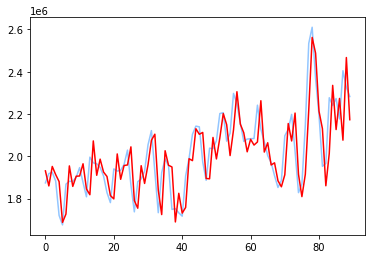

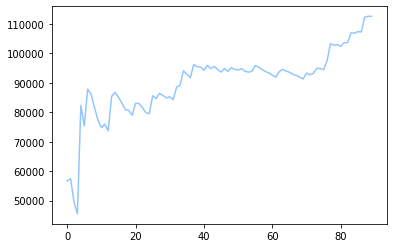

ARIMA(1, 0, 1) RMSE=112557  , actual best : (12, 1, 0) RMSE: 92350
(2, 0, 1)   step =  0


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1900933.751, Expected=1943332.000, RMSE = 26472
(2, 0, 1)   step =  1


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1858174.648, Expected=1943332.000, RMSE = 46477
(2, 0, 1)   step =  2


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1955319.303, Expected=1943332.000, RMSE = 41979
(2, 0, 1)   step =  3


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1902842.491, Expected=1943332.000, RMSE = 37620
(2, 0, 1)   step =  4


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1892900.528, Expected=1943332.000, RMSE = 84160
(2, 0, 1)   step =  5


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1686744.212, Expected=1943332.000, RMSE = 76959
(2, 0, 1)   step =  6


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1738636.325, Expected=1943332.000, RMSE = 86484
(2, 0, 1)   step =  7


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1926459.204, Expected=1943332.000, RMSE = 82416
(2, 0, 1)   step =  8


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1857832.529, Expected=1943332.000, RMSE = 78102
(2, 0, 1)   step =  9


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1911955.234, Expected=1943332.000, RMSE = 74171
(2, 0, 1)   step =  10


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1896131.130, Expected=1943332.000, RMSE = 72338
(2, 0, 1)   step =  11


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1969605.612, Expected=1943332.000, RMSE = 74294
(2, 0, 1)   step =  12


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1840869.272, Expected=1943332.000, RMSE = 71934
(2, 0, 1)   step =  13


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1832820.504, Expected=1943332.000, RMSE = 81899
(2, 0, 1)   step =  14


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2051911.243, Expected=1943332.000, RMSE = 81971
(2, 0, 1)   step =  15


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1908221.599, Expected=1943332.000, RMSE = 80625
(2, 0, 1)   step =  16


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2002353.391, Expected=1943332.000, RMSE = 79358
(2, 0, 1)   step =  17


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1909175.274, Expected=1943332.000, RMSE = 77124
(2, 0, 1)   step =  18


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1923771.190, Expected=1943332.000, RMSE = 78177
(2, 0, 1)   step =  19


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1804600.011, Expected=1943332.000, RMSE = 76377
(2, 0, 1)   step =  20


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1812243.815, Expected=1943332.000, RMSE = 79620
(2, 0, 1)   step =  21


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1990534.772, Expected=1943332.000, RMSE = 78848
(2, 0, 1)   step =  22


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1890088.111, Expected=1943332.000, RMSE = 77658
(2, 0, 1)   step =  23


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1966676.208, Expected=1943332.000, RMSE = 76030
(2, 0, 1)   step =  24


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1944876.078, Expected=1943332.000, RMSE = 76381
(2, 0, 1)   step =  25


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2052634.438, Expected=1943332.000, RMSE = 83486
(2, 0, 1)   step =  26


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1787846.432, Expected=1943332.000, RMSE = 82497
(2, 0, 1)   step =  27


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1780880.114, Expected=1943332.000, RMSE = 83149
(2, 0, 1)   step =  28


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1926531.703, Expected=1943332.000, RMSE = 81937
(2, 0, 1)   step =  29


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1874808.714, Expected=1943332.000, RMSE = 81172
(2, 0, 1)   step =  30


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1961667.882, Expected=1943332.000, RMSE = 81562
(2, 0, 1)   step =  31


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2061790.108, Expected=1943332.000, RMSE = 80970
(2, 0, 1)   step =  32


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2106066.991, Expected=1943332.000, RMSE = 85618
(2, 0, 1)   step =  33


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1851189.746, Expected=1943332.000, RMSE = 86732
(2, 0, 1)   step =  34


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1746441.308, Expected=1943332.000, RMSE = 90559
(2, 0, 1)   step =  35


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2004682.097, Expected=1943332.000, RMSE = 89336
(2, 0, 1)   step =  36


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1945875.103, Expected=1943332.000, RMSE = 88133
(2, 0, 1)   step =  37


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1967002.418, Expected=1943332.000, RMSE = 93884
(2, 0, 1)   step =  38


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1687330.320, Expected=1943332.000, RMSE = 93265
(2, 0, 1)   step =  39


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1842155.232, Expected=1943332.000, RMSE = 93704
(2, 0, 1)   step =  40


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1703272.983, Expected=1943332.000, RMSE = 92579
(2, 0, 1)   step =  41


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1781342.289, Expected=1943332.000, RMSE = 93509
(2, 0, 1)   step =  42


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1953874.631, Expected=1943332.000, RMSE = 92581
(2, 0, 1)   step =  43


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1981995.390, Expected=1943332.000, RMSE = 93360
(2, 0, 1)   step =  44


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2125631.264, Expected=1943332.000, RMSE = 92352
(2, 0, 1)   step =  45


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2098613.055, Expected=1943332.000, RMSE = 91539
(2, 0, 1)   step =  46


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2125372.716, Expected=1943332.000, RMSE = 93251
(2, 0, 1)   step =  47


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1898718.109, Expected=1943332.000, RMSE = 92291
(2, 0, 1)   step =  48


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1913756.936, Expected=1943332.000, RMSE = 93066
(2, 0, 1)   step =  49


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2065885.577, Expected=1943332.000, RMSE = 92230
(2, 0, 1)   step =  50


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1992137.678, Expected=1943332.000, RMSE = 92031
(2, 0, 1)   step =  51


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2093177.720, Expected=1943332.000, RMSE = 92384
(2, 0, 1)   step =  52


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2187554.899, Expected=1943332.000, RMSE = 91544
(2, 0, 1)   step =  53


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2158726.030, Expected=1943332.000, RMSE = 91463
(2, 0, 1)   step =  54


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2015017.682, Expected=1943332.000, RMSE = 91512
(2, 0, 1)   step =  55


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2130313.610, Expected=1943332.000, RMSE = 93394
(2, 0, 1)   step =  56


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2287777.558, Expected=1943332.000, RMSE = 92719
(2, 0, 1)   step =  57


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2163223.658, Expected=1943332.000, RMSE = 91920
(2, 0, 1)   step =  58


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2128898.550, Expected=1943332.000, RMSE = 91454
(2, 0, 1)   step =  59


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2021947.548, Expected=1943332.000, RMSE = 91014
(2, 0, 1)   step =  60


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2090839.101, Expected=1943332.000, RMSE = 90270
(2, 0, 1)   step =  61


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2044848.764, Expected=1943332.000, RMSE = 89678
(2, 0, 1)   step =  62


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2080556.830, Expected=1943332.000, RMSE = 91250
(2, 0, 1)   step =  63


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2249164.696, Expected=1943332.000, RMSE = 91778
(2, 0, 1)   step =  64


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2028531.924, Expected=1943332.000, RMSE = 91202
(2, 0, 1)   step =  65


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2086181.563, Expected=1943332.000, RMSE = 91081
(2, 0, 1)   step =  66


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1945692.946, Expected=1943332.000, RMSE = 90449
(2, 0, 1)   step =  67


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1991170.620, Expected=1943332.000, RMSE = 90345
(2, 0, 1)   step =  68


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1870951.348, Expected=1943332.000, RMSE = 89715
(2, 0, 1)   step =  69


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1874561.489, Expected=1943332.000, RMSE = 89082
(2, 0, 1)   step =  70


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1897046.247, Expected=1943332.000, RMSE = 91584
(2, 0, 1)   step =  71


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2150700.375, Expected=1943332.000, RMSE = 90986
(2, 0, 1)   step =  72


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2059361.107, Expected=1943332.000, RMSE = 91811
(2, 0, 1)   step =  73


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2223318.026, Expected=1943332.000, RMSE = 94097
(2, 0, 1)   step =  74


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1906021.311, Expected=1943332.000, RMSE = 93898
(2, 0, 1)   step =  75


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1850911.262, Expected=1943332.000, RMSE = 93303
(2, 0, 1)   step =  76


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1887683.982, Expected=1943332.000, RMSE = 97301
(2, 0, 1)   step =  77


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2214895.516, Expected=1943332.000, RMSE = 103197
(2, 0, 1)   step =  78


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2528569.109, Expected=1943332.000, RMSE = 102950
(2, 0, 1)   step =  79


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2498734.561, Expected=1943332.000, RMSE = 103357
(2, 0, 1)   step =  80


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2241181.437, Expected=1943332.000, RMSE = 102843
(2, 0, 1)   step =  81


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2151555.075, Expected=1943332.000, RMSE = 104544
(2, 0, 1)   step =  82


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=1869883.256, Expected=1943332.000, RMSE = 104450
(2, 0, 1)   step =  83


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2028000.488, Expected=1943332.000, RMSE = 107319
(2, 0, 1)   step =  84


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2299597.749, Expected=1943332.000, RMSE = 106879
(2, 0, 1)   step =  85


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2138957.372, Expected=1943332.000, RMSE = 107236
(2, 0, 1)   step =  86


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2288281.866, Expected=1943332.000, RMSE = 107286
(2, 0, 1)   step =  87


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2067653.543, Expected=1943332.000, RMSE = 112561
(2, 0, 1)   step =  88


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2486068.918, Expected=1943332.000, RMSE = 113191
(2, 0, 1)   step =  89


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted=2144552.372, Expected=1943332.000, RMSE = 113495


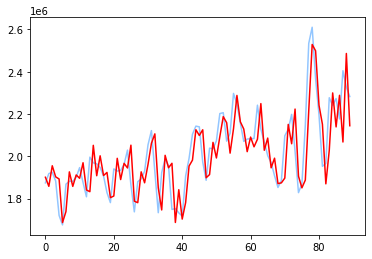

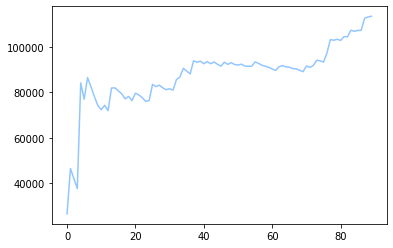

ARIMA(2, 0, 1) RMSE=113495  , actual best : (12, 1, 0) RMSE: 92350
(3, 0, 1)   step =  0
Predicted=1936617.843, Expected=1943332.000, RMSE = 62156
(3, 0, 1)   step =  1
Predicted=1859940.445, Expected=1943332.000, RMSE = 60305
(3, 0, 1)   step =  2
Predicted=1894326.004, Expected=1943332.000, RMSE = 52178
(3, 0, 1)   step =  3
Predicted=1887637.040, Expected=1943332.000, RMSE = 45235
(3, 0, 1)   step =  4
Predicted=1850464.025, Expected=1943332.000, RMSE = 70851
(3, 0, 1)   step =  5
Predicted=1701134.842, Expected=1943332.000, RMSE = 65504
(3, 0, 1)   step =  6
Predicted=1732918.584, Expected=1943332.000, RMSE = 79355
(3, 0, 1)   step =  7
Predicted=1950103.847, Expected=1943332.000, RMSE = 78045
(3, 0, 1)   step =  8
Predicted=1859200.605, Expected=1943332.000, RMSE = 73956
(3, 0, 1)   step =  9
Predicted=1859243.630, Expected=1943332.000, RMSE = 71406
(3, 0, 1)   step =  10
Predicted=1887216.320, Expected=1943332.000, RMSE = 70397
(3, 0, 1)   step =  11
Predicted=1931614.628, Expect

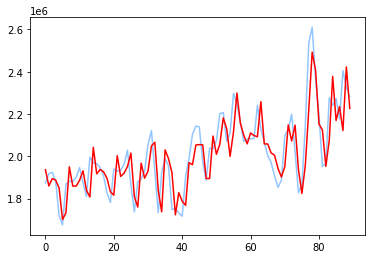

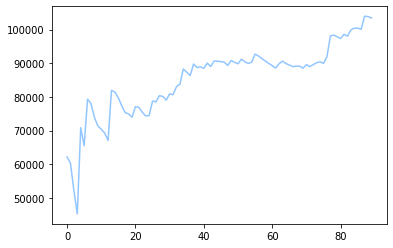

ARIMA(3, 0, 1) RMSE=103479  , actual best : (12, 1, 0) RMSE: 92350
(4, 0, 1)   step =  0
Predicted=1912413.863, Expected=1943332.000, RMSE = 37952
(4, 0, 1)   step =  1
Predicted=1830377.575, Expected=1943332.000, RMSE = 67739
(4, 0, 1)   step =  2
Predicted=1932301.172, Expected=1943332.000, RMSE = 55504
(4, 0, 1)   step =  3
Predicted=1906154.360, Expected=1943332.000, RMSE = 49385
(4, 0, 1)   step =  4
Predicted=1883148.616, Expected=1943332.000, RMSE = 85135
(4, 0, 1)   step =  5
Predicted=1694944.572, Expected=1943332.000, RMSE = 78113
(4, 0, 1)   step =  6
Predicted=1749426.245, Expected=1943332.000, RMSE = 85144
(4, 0, 1)   step =  7
Predicted=1936923.716, Expected=1943332.000, RMSE = 81984
(4, 0, 1)   step =  8
Predicted=1835212.734, Expected=1943332.000, RMSE = 78820
(4, 0, 1)   step =  9
Predicted=1892144.271, Expected=1943332.000, RMSE = 74831
(4, 0, 1)   step =  10
Predicted=1904821.181, Expected=1943332.000, RMSE = 72451
(4, 0, 1)   step =  11
Predicted=1960091.948, Expect

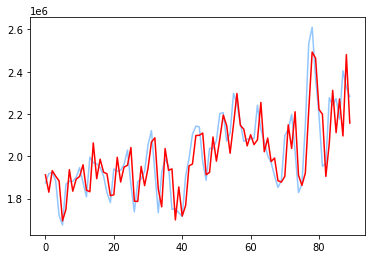

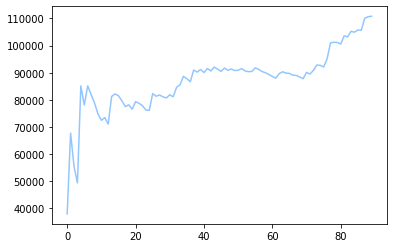

ARIMA(4, 0, 1) RMSE=110815  , actual best : (12, 1, 0) RMSE: 92350
(5, 0, 1)   step =  0
Predicted=1917560.361, Expected=1943332.000, RMSE = 43098
(5, 0, 1)   step =  1
Predicted=1838786.665, Expected=1943332.000, RMSE = 63975
(5, 0, 1)   step =  2
Predicted=1915899.789, Expected=1943332.000, RMSE = 52456
(5, 0, 1)   step =  3
Predicted=1896887.089, Expected=1943332.000, RMSE = 45919
(5, 0, 1)   step =  4
Predicted=1884944.608, Expected=1943332.000, RMSE = 84269
(5, 0, 1)   step =  5
Predicted=1692343.876, Expected=1943332.000, RMSE = 77226
(5, 0, 1)   step =  6
Predicted=1753888.846, Expected=1943332.000, RMSE = 83562
(5, 0, 1)   step =  7
Predicted=1938928.238, Expected=1943332.000, RMSE = 80722
(5, 0, 1)   step =  8
Predicted=1843963.541, Expected=1943332.000, RMSE = 77127
(5, 0, 1)   step =  9
Predicted=1878320.007, Expected=1943332.000, RMSE = 73526
(5, 0, 1)   step =  10
Predicted=1896858.104, Expected=1943332.000, RMSE = 71691
(5, 0, 1)   step =  11
Predicted=1963262.772, Expect

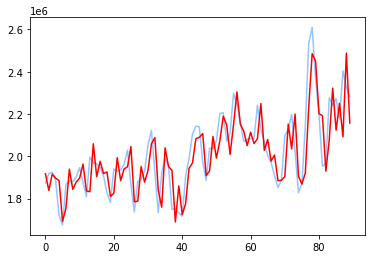

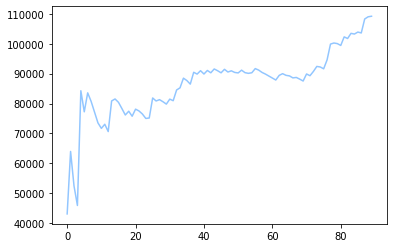

ARIMA(5, 0, 1) RMSE=109168  , actual best : (12, 1, 0) RMSE: 92350
(6, 0, 1)   step =  0
Predicted=1923317.330, Expected=1943332.000, RMSE = 48855
(6, 0, 1)   step =  1
Predicted=1855191.697, Expected=1943332.000, RMSE = 56454
(6, 0, 1)   step =  2
Predicted=1960965.598, Expected=1943332.000, RMSE = 50740
(6, 0, 1)   step =  3
Predicted=1876182.469, Expected=1943332.000, RMSE = 44094
(6, 0, 1)   step =  4
Predicted=1790586.925, Expected=1943332.000, RMSE = 50403
(6, 0, 1)   step =  5
Predicted=1699494.717, Expected=1943332.000, RMSE = 47023
(6, 0, 1)   step =  6
Predicted=1740621.368, Expected=1943332.000, RMSE = 65001
(6, 0, 1)   step =  7
Predicted=1947120.203, Expected=1943332.000, RMSE = 65025
(6, 0, 1)   step =  8
Predicted=1854777.869, Expected=1943332.000, RMSE = 61949
(6, 0, 1)   step =  9
Predicted=1918624.793, Expected=1943332.000, RMSE = 59027
(6, 0, 1)   step =  10
Predicted=1883718.685, Expected=1943332.000, RMSE = 59387
(6, 0, 1)   step =  11
Predicted=1875796.980, Expect

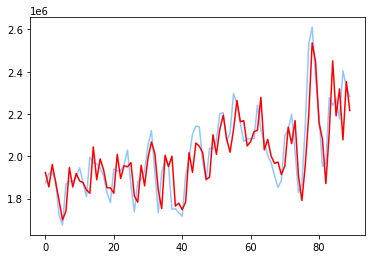

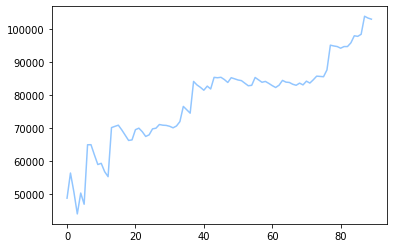

ARIMA(6, 0, 1) RMSE=102982  , actual best : (12, 1, 0) RMSE: 92350
(7, 0, 1)   step =  0
Predicted=1908241.206, Expected=1943332.000, RMSE = 33779
(7, 0, 1)   step =  1
Predicted=1867096.749, Expected=1943332.000, RMSE = 43396
(7, 0, 1)   step =  2
Predicted=1953071.629, Expected=1943332.000, RMSE = 39151
(7, 0, 1)   step =  3
Predicted=1894693.870, Expected=1943332.000, RMSE = 34365
(7, 0, 1)   step =  4
Predicted=1786264.159, Expected=1943332.000, RMSE = 42570
(7, 0, 1)   step =  5
Predicted=1667732.266, Expected=1943332.000, RMSE = 38997
(7, 0, 1)   step =  6
Predicted=1765841.794, Expected=1943332.000, RMSE = 52953
(7, 0, 1)   step =  7
Predicted=1923543.051, Expected=1943332.000, RMSE = 51672
(7, 0, 1)   step =  8
Predicted=1872921.951, Expected=1943332.000, RMSE = 48800
(7, 0, 1)   step =  9
Predicted=1907465.169, Expected=1943332.000, RMSE = 46338
(7, 0, 1)   step =  10
Predicted=1901004.169, Expected=1943332.000, RMSE = 46270
(7, 0, 1)   step =  11
Predicted=1873042.753, Expect

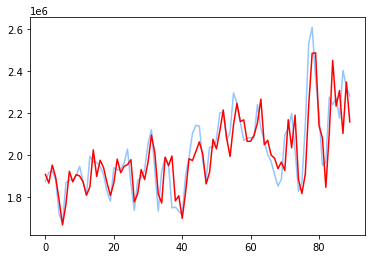

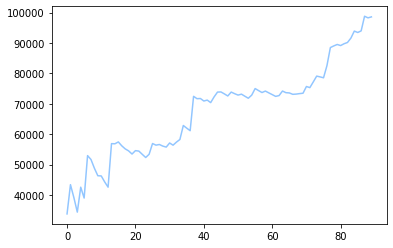

ARIMA(7, 0, 1) RMSE=98571  , actual best : (12, 1, 0) RMSE: 92350
(8, 0, 1)   step =  0
Predicted=1894950.046, Expected=1943332.000, RMSE = 20488
(8, 0, 1)   step =  1
Predicted=1868711.466, Expected=1943332.000, RMSE = 37963
(8, 0, 1)   step =  2
Predicted=1953174.320, Expected=1943332.000, RMSE = 35214
(8, 0, 1)   step =  3
Predicted=1882332.018, Expected=1943332.000, RMSE = 30502
(8, 0, 1)   step =  4
Predicted=1759579.094, Expected=1943332.000, RMSE = 32422
(8, 0, 1)   step =  5
Predicted=1687640.901, Expected=1943332.000, RMSE = 29994
(8, 0, 1)   step =  6
Predicted=1806700.930, Expected=1943332.000, RMSE = 36244
(8, 0, 1)   step =  7
Predicted=1921980.887, Expected=1943332.000, RMSE = 36742
(8, 0, 1)   step =  8
Predicted=1884785.382, Expected=1943332.000, RMSE = 34658
(8, 0, 1)   step =  9
Predicted=1899060.372, Expected=1943332.000, RMSE = 32886
(8, 0, 1)   step =  10
Predicted=1890005.070, Expected=1943332.000, RMSE = 35697
(8, 0, 1)   step =  11
Predicted=1858600.314, Expecte

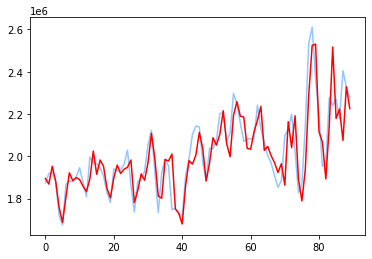

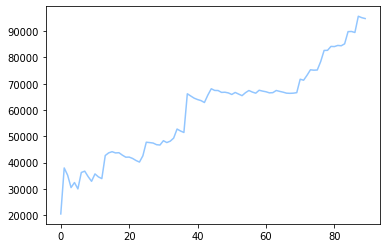

ARIMA(8, 0, 1) RMSE=94769  , actual best : (12, 1, 0) RMSE: 92350
(9, 0, 1)   step =  0
Predicted=1889980.834, Expected=1943332.000, RMSE = 15519
(9, 0, 1)   step =  1
Predicted=1862912.363, Expected=1943332.000, RMSE = 40698
(9, 0, 1)   step =  2
Predicted=1957346.455, Expected=1943332.000, RMSE = 38338
(9, 0, 1)   step =  3
Predicted=1882014.859, Expected=1943332.000, RMSE = 33210
(9, 0, 1)   step =  4
Predicted=1760330.952, Expected=1943332.000, RMSE = 34656
(9, 0, 1)   step =  5
Predicted=1692141.330, Expected=1943332.000, RMSE = 32339
(9, 0, 1)   step =  6
Predicted=1809980.364, Expected=1943332.000, RMSE = 37185
(9, 0, 1)   step =  7
Predicted=1913109.814, Expected=1943332.000, RMSE = 36489
(9, 0, 1)   step =  8
Predicted=1877228.998, Expected=1943332.000, RMSE = 34431
(9, 0, 1)   step =  9
Predicted=1898465.044, Expected=1943332.000, RMSE = 32676
(9, 0, 1)   step =  10
Predicted=1887129.905, Expected=1943332.000, RMSE = 35946
(9, 0, 1)   step =  11
Predicted=1863582.386, Expecte

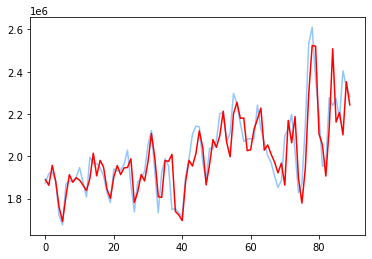

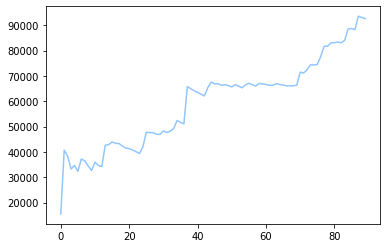

ARIMA(9, 0, 1) RMSE=92614  , actual best : (12, 1, 0) RMSE: 92350
(10, 0, 1)   step =  0
Predicted=1890079.559, Expected=1943332.000, RMSE = 15618
(10, 0, 1)   step =  1
Predicted=1863244.483, Expected=1943332.000, RMSE = 40491
(10, 0, 1)   step =  2
Predicted=1956508.199, Expected=1943332.000, RMSE = 37951
(10, 0, 1)   step =  3
Predicted=1882348.314, Expected=1943332.000, RMSE = 32872
(10, 0, 1)   step =  4
Predicted=1760338.312, Expected=1943332.000, RMSE = 34399
(10, 0, 1)   step =  5
Predicted=1692164.626, Expected=1943332.000, RMSE = 32111
(10, 0, 1)   step =  6
Predicted=1809927.797, Expected=1943332.000, RMSE = 37027
(10, 0, 1)   step =  7
Predicted=1913493.502, Expected=1943332.000, RMSE = 36389
(10, 0, 1)   step =  8
Predicted=1877284.433, Expected=1943332.000, RMSE = 34337
(10, 0, 1)   step =  9
Predicted=1897610.371, Expected=1943332.000, RMSE = 32595
(10, 0, 1)   step =  10
Predicted=1887523.433, Expected=1943332.000, RMSE = 35820
(10, 0, 1)   step =  11
Predicted=1863079.

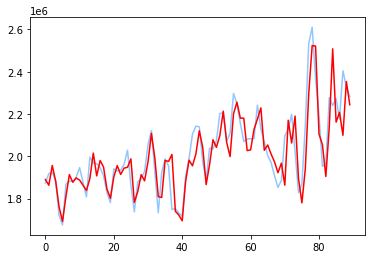

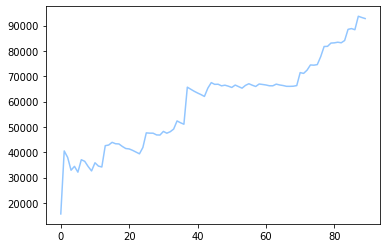

ARIMA(10, 0, 1) RMSE=92780  , actual best : (12, 1, 0) RMSE: 92350
(11, 0, 1)   step =  0


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1887455.404, Expected=1943332.000, RMSE = 12993
(11, 0, 1)   step =  1


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1866413.759, Expected=1943332.000, RMSE = 37847
(11, 0, 1)   step =  2


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1956160.492, Expected=1943332.000, RMSE = 35983
(11, 0, 1)   step =  3
Predicted=1882295.046, Expected=1943332.000, RMSE = 31168
(11, 0, 1)   step =  4


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1757981.291, Expected=1943332.000, RMSE = 32550
(11, 0, 1)   step =  5


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1699533.947, Expected=1943332.000, RMSE = 31263
(11, 0, 1)   step =  6
Predicted=1810398.554, Expected=1943332.000, RMSE = 36292
(11, 0, 1)   step =  7


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1915702.911, Expected=1943332.000, RMSE = 35987
(11, 0, 1)   step =  8


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1880066.848, Expected=1943332.000, RMSE = 33932
(11, 0, 1)   step =  9


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1894000.286, Expected=1943332.000, RMSE = 32272
(11, 0, 1)   step =  10


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1884037.761, Expected=1943332.000, RMSE = 36091
(11, 0, 1)   step =  11


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1860207.899, Expected=1943332.000, RMSE = 34871
(11, 0, 1)   step =  12


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1837618.525, Expected=1943332.000, RMSE = 34448
(11, 0, 1)   step =  13


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1899935.010, Expected=1943332.000, RMSE = 41969
(11, 0, 1)   step =  14
Predicted=2014688.413, Expected=1943332.000, RMSE = 42231
(11, 0, 1)   step =  15
Predicted=1906678.078, Expected=1943332.000, RMSE = 43408
(11, 0, 1)   step =  16


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1977472.857, Expected=1943332.000, RMSE = 42752
(11, 0, 1)   step =  17


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1949156.063, Expected=1943332.000, RMSE = 42718
(11, 0, 1)   step =  18


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1837829.536, Expected=1943332.000, RMSE = 41632
(11, 0, 1)   step =  19


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1802066.781, Expected=1943332.000, RMSE = 40847
(11, 0, 1)   step =  20


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1900849.265, Expected=1943332.000, RMSE = 40792
(11, 0, 1)   step =  21
Predicted=1956823.409, Expected=1943332.000, RMSE = 40258
(11, 0, 1)   step =  22
Predicted=1912640.179, Expected=1943332.000, RMSE = 39626
(11, 0, 1)   step =  23
Predicted=1945616.814, Expected=1943332.000, RMSE = 38928
(11, 0, 1)   step =  24
Predicted=1947209.976, Expected=1943332.000, RMSE = 41521
(11, 0, 1)   step =  25
Predicted=1988213.107, Expected=1943332.000, RMSE = 47388
(11, 0, 1)   step =  26


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1784012.853, Expected=1943332.000, RMSE = 47356
(11, 0, 1)   step =  27


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1843112.490, Expected=1943332.000, RMSE = 47023
(11, 0, 1)   step =  28


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1911925.678, Expected=1943332.000, RMSE = 46337
(11, 0, 1)   step =  29


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1882029.803, Expected=1943332.000, RMSE = 46367
(11, 0, 1)   step =  30


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1972229.648, Expected=1943332.000, RMSE = 47929
(11, 0, 1)   step =  31


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2112584.174, Expected=1943332.000, RMSE = 47201
(11, 0, 1)   step =  32


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1983384.631, Expected=1943332.000, RMSE = 47509
(11, 0, 1)   step =  33
Predicted=1808573.814, Expected=1943332.000, RMSE = 48545
(11, 0, 1)   step =  34
Predicted=1806272.559, Expected=1943332.000, RMSE = 51773
(11, 0, 1)   step =  35
Predicted=1980237.291, Expected=1943332.000, RMSE = 51064
(11, 0, 1)   step =  36
Predicted=1975376.716, Expected=1943332.000, RMSE = 50484
(11, 0, 1)   step =  37
Predicted=2009590.296, Expected=1943332.000, RMSE = 65339
(11, 0, 1)   step =  38
Predicted=1739885.415, Expected=1943332.000, RMSE = 64530
(11, 0, 1)   step =  39
Predicted=1721461.577, Expected=1943332.000, RMSE = 63743
(11, 0, 1)   step =  40
Predicted=1696279.670, Expected=1943332.000, RMSE = 63044
(11, 0, 1)   step =  41
Predicted=1882400.658, Expected=1943332.000, RMSE = 62407
(11, 0, 1)   step =  42
Predicted=1982244.437, Expected=1943332.000, RMSE = 61689
(11, 0, 1)   step =  43
Predicted=1953047.309, Expected=1943332.000, RMSE = 65103
(11, 0, 1)   step =  44
Predicted=201239

D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1964040.298, Expected=1943332.000, RMSE = 66217
(11, 0, 1)   step =  49
Predicted=2078871.777, Expected=1943332.000, RMSE = 65835
(11, 0, 1)   step =  50
Predicted=2041431.140, Expected=1943332.000, RMSE = 65342
(11, 0, 1)   step =  51
Predicted=2098717.062, Expected=1943332.000, RMSE = 66279
(11, 0, 1)   step =  52
Predicted=2212456.571, Expected=1943332.000, RMSE = 65657
(11, 0, 1)   step =  53
Predicted=2067243.039, Expected=1943332.000, RMSE = 65049
(11, 0, 1)   step =  54
Predicted=1997581.511, Expected=1943332.000, RMSE = 66186
(11, 0, 1)   step =  55
Predicted=2201403.393, Expected=1943332.000, RMSE = 66831
(11, 0, 1)   step =  56
Predicted=2256162.039, Expected=1943332.000, RMSE = 66250
(11, 0, 1)   step =  57
Predicted=2179064.672, Expected=1943332.000, RMSE = 65743
(11, 0, 1)   step =  58
Predicted=2181031.197, Expected=1943332.000, RMSE = 66752
(11, 0, 1)   step =  59
Predicted=2026504.347, Expected=1943332.000, RMSE = 66573
(11, 0, 1)   step =  60
Predicted=202974

D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2114538.304, Expected=1943332.000, RMSE = 82755
(11, 0, 1)   step =  81
Predicted=2044293.816, Expected=1943332.000, RMSE = 82867
(11, 0, 1)   step =  82
Predicted=1919372.550, Expected=1943332.000, RMSE = 82528
(11, 0, 1)   step =  83
Predicted=2124405.324, Expected=1943332.000, RMSE = 83705
(11, 0, 1)   step =  84


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2517662.571, Expected=1943332.000, RMSE = 88484
(11, 0, 1)   step =  85
Predicted=2162374.889, Expected=1943332.000, RMSE = 88773
(11, 0, 1)   step =  86
Predicted=2205598.983, Expected=1943332.000, RMSE = 88316
(11, 0, 1)   step =  87
Predicted=2101929.987, Expected=1943332.000, RMSE = 93554
(11, 0, 1)   step =  88
Predicted=2355179.578, Expected=1943332.000, RMSE = 93076
(11, 0, 1)   step =  89
Predicted=2239442.613, Expected=1943332.000, RMSE = 92668


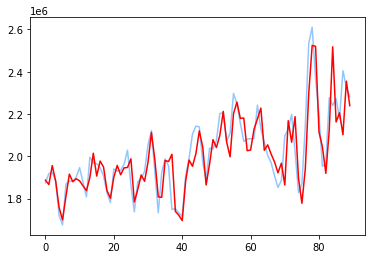

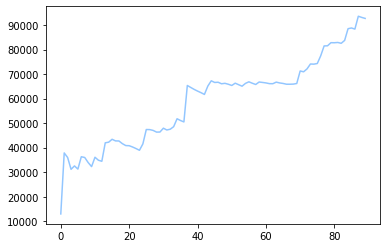

ARIMA(11, 0, 1) RMSE=92668  , actual best : (12, 1, 0) RMSE: 92350
(12, 0, 1)   step =  0
Predicted=1885974.855, Expected=1943332.000, RMSE = 11513
(12, 0, 1)   step =  1
Predicted=1868176.440, Expected=1943332.000, RMSE = 36390
(12, 0, 1)   step =  2
Predicted=1951891.593, Expected=1943332.000, RMSE = 33733
(12, 0, 1)   step =  3
Predicted=1878633.203, Expected=1943332.000, RMSE = 29314
(12, 0, 1)   step =  4
Predicted=1763525.780, Expected=1943332.000, RMSE = 32547
(12, 0, 1)   step =  5
Predicted=1691047.155, Expected=1943332.000, RMSE = 30362
(12, 0, 1)   step =  6
Predicted=1811553.103, Expected=1943332.000, RMSE = 35364
(12, 0, 1)   step =  7
Predicted=1915222.895, Expected=1943332.000, RMSE = 35112
(12, 0, 1)   step =  8
Predicted=1880641.381, Expected=1943332.000, RMSE = 33105
(12, 0, 1)   step =  9
Predicted=1891677.997, Expected=1943332.000, RMSE = 31551
(12, 0, 1)   step =  10
Predicted=1882749.508, Expected=1943332.000, RMSE = 35715
(12, 0, 1)   step =  11
Predicted=1863614

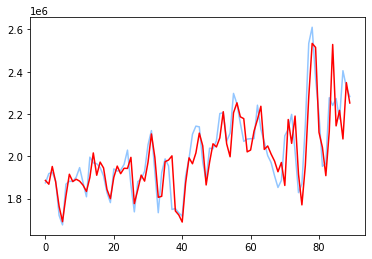

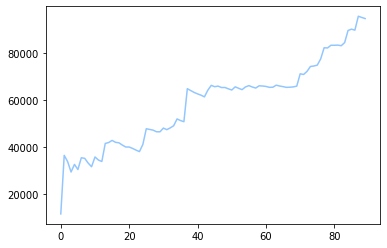

ARIMA(12, 0, 1) RMSE=94492  , actual best : (12, 1, 0) RMSE: 92350
(13, 0, 1)   step =  0
Predicted=1890879.381, Expected=1943332.000, RMSE = 16417
(13, 0, 1)   step =  1
Predicted=1860495.995, Expected=1943332.000, RMSE = 42515
(13, 0, 1)   step =  2
Predicted=1956772.070, Expected=1943332.000, RMSE = 39471
(13, 0, 1)   step =  3
Predicted=1880353.380, Expected=1943332.000, RMSE = 34219
(13, 0, 1)   step =  4
Predicted=1746144.517, Expected=1943332.000, RMSE = 32699
(13, 0, 1)   step =  5
Predicted=1694503.397, Expected=1943332.000, RMSE = 30819
(13, 0, 1)   step =  6
Predicted=1814236.253, Expected=1943332.000, RMSE = 35101
(13, 0, 1)   step =  7
Predicted=1915262.452, Expected=1943332.000, RMSE = 34885
(13, 0, 1)   step =  8
Predicted=1883234.582, Expected=1943332.000, RMSE = 32895
(13, 0, 1)   step =  9
Predicted=1904414.911, Expected=1943332.000, RMSE = 31223
(13, 0, 1)   step =  10
Predicted=1879010.087, Expected=1943332.000, RMSE = 36076
(13, 0, 1)   step =  11
Predicted=1841717

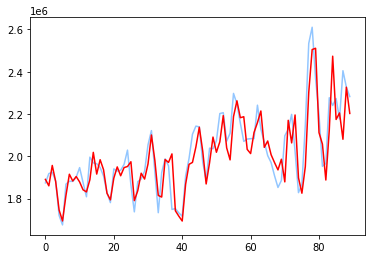

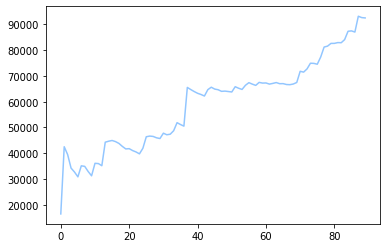

ARIMA(13, 0, 1) RMSE=92543  , actual best : (12, 1, 0) RMSE: 92350
(14, 0, 1)   step =  0
Predicted=1882000.822, Expected=1943332.000, RMSE = 7539
(14, 0, 1)   step =  1
Predicted=1869017.691, Expected=1943332.000, RMSE = 35278
(14, 0, 1)   step =  2
Predicted=1947803.481, Expected=1943332.000, RMSE = 31858
(14, 0, 1)   step =  3
Predicted=1886377.154, Expected=1943332.000, RMSE = 27628
(14, 0, 1)   step =  4
Predicted=1746668.333, Expected=1943332.000, RMSE = 27360
(14, 0, 1)   step =  5
Predicted=1685033.221, Expected=1943332.000, RMSE = 25263
(14, 0, 1)   step =  6
Predicted=1820226.920, Expected=1943332.000, RMSE = 29624
(14, 0, 1)   step =  7
Predicted=1913136.540, Expected=1943332.000, RMSE = 29826
(14, 0, 1)   step =  8
Predicted=1884736.761, Expected=1943332.000, RMSE = 28141
(14, 0, 1)   step =  9
Predicted=1903223.651, Expected=1943332.000, RMSE = 26705
(14, 0, 1)   step =  10
Predicted=1885907.037, Expected=1943332.000, RMSE = 31354
(14, 0, 1)   step =  11
Predicted=1839725.

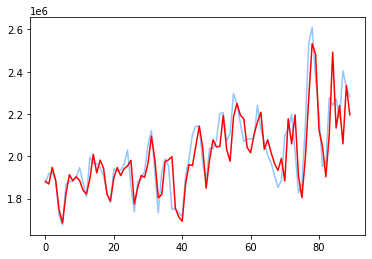

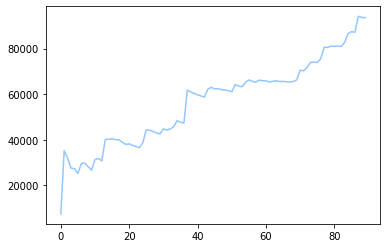

ARIMA(14, 0, 1) RMSE=93558  , actual best : (12, 1, 0) RMSE: 92350
(15, 0, 1)   step =  0


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1873996.714, Expected=1943332.000, RMSE = 465
(15, 0, 1)   step =  1


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1874023.861, Expected=1943332.000, RMSE = 31335
(15, 0, 1)   step =  2


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1945225.988, Expected=1943332.000, RMSE = 28311
(15, 0, 1)   step =  3


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1895488.265, Expected=1943332.000, RMSE = 25241
(15, 0, 1)   step =  4


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1737792.976, Expected=1943332.000, RMSE = 23878
(15, 0, 1)   step =  5


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1687469.207, Expected=1943332.000, RMSE = 22318
(15, 0, 1)   step =  6


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1839614.304, Expected=1943332.000, RMSE = 23339
(15, 0, 1)   step =  7


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1903431.529, Expected=1943332.000, RMSE = 23118
(15, 0, 1)   step =  8


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1885312.615, Expected=1943332.000, RMSE = 21832
(15, 0, 1)   step =  9


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1900087.675, Expected=1943332.000, RMSE = 20715
(15, 0, 1)   step =  10


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1879101.250, Expected=1943332.000, RMSE = 28359
(15, 0, 1)   step =  11


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1834709.756, Expected=1943332.000, RMSE = 29706
(15, 0, 1)   step =  12


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1834293.262, Expected=1943332.000, RMSE = 29408
(15, 0, 1)   step =  13


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1913585.251, Expected=1943332.000, RMSE = 35896
(15, 0, 1)   step =  14


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2010978.337, Expected=1943332.000, RMSE = 36337
(15, 0, 1)   step =  15


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1942429.009, Expected=1943332.000, RMSE = 35631
(15, 0, 1)   step =  16


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1969028.861, Expected=1943332.000, RMSE = 34975
(15, 0, 1)   step =  17


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1935325.858, Expected=1943332.000, RMSE = 34638
(15, 0, 1)   step =  18


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1812631.819, Expected=1943332.000, RMSE = 33913
(15, 0, 1)   step =  19


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1800088.490, Expected=1943332.000, RMSE = 33324
(15, 0, 1)   step =  20


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1917708.319, Expected=1943332.000, RMSE = 32900
(15, 0, 1)   step =  21


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1943765.786, Expected=1943332.000, RMSE = 32275
(15, 0, 1)   step =  22


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1927400.018, Expected=1943332.000, RMSE = 31596
(15, 0, 1)   step =  23


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1936188.027, Expected=1943332.000, RMSE = 31362
(15, 0, 1)   step =  24


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1968618.769, Expected=1943332.000, RMSE = 33034
(15, 0, 1)   step =  25


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1976984.187, Expected=1943332.000, RMSE = 39182
(15, 0, 1)   step =  26


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1773086.241, Expected=1943332.000, RMSE = 39056
(15, 0, 1)   step =  27


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1859333.020, Expected=1943332.000, RMSE = 38551
(15, 0, 1)   step =  28


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1881458.957, Expected=1943332.000, RMSE = 37943
(15, 0, 1)   step =  29


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1913038.425, Expected=1943332.000, RMSE = 37423
(15, 0, 1)   step =  30


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1942246.153, Expected=1943332.000, RMSE = 41945
(15, 0, 1)   step =  31


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2091833.270, Expected=1943332.000, RMSE = 41618
(15, 0, 1)   step =  32


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2000640.917, Expected=1943332.000, RMSE = 42947
(15, 0, 1)   step =  33


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1803345.467, Expected=1943332.000, RMSE = 43975
(15, 0, 1)   step =  34


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1820559.368, Expected=1943332.000, RMSE = 46690
(15, 0, 1)   step =  35


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1953788.789, Expected=1943332.000, RMSE = 46384
(15, 0, 1)   step =  36


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2005880.518, Expected=1943332.000, RMSE = 46520
(15, 0, 1)   step =  37


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1974653.098, Expected=1943332.000, RMSE = 58717
(15, 0, 1)   step =  38


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1768517.476, Expected=1943332.000, RMSE = 58014
(15, 0, 1)   step =  39


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1696716.506, Expected=1943332.000, RMSE = 57566
(15, 0, 1)   step =  40


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1693951.276, Expected=1943332.000, RMSE = 56974
(15, 0, 1)   step =  41


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1886074.738, Expected=1943332.000, RMSE = 56386
(15, 0, 1)   step =  42


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1938027.296, Expected=1943332.000, RMSE = 56291
(15, 0, 1)   step =  43


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2006204.760, Expected=1943332.000, RMSE = 57576
(15, 0, 1)   step =  44


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2061404.201, Expected=1943332.000, RMSE = 58209
(15, 0, 1)   step =  45


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2146232.011, Expected=1943332.000, RMSE = 57582
(15, 0, 1)   step =  46


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1989317.080, Expected=1943332.000, RMSE = 57016
(15, 0, 1)   step =  47


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1831678.931, Expected=1943332.000, RMSE = 56975
(15, 0, 1)   step =  48


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2021321.914, Expected=1943332.000, RMSE = 56444
(15, 0, 1)   step =  49


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2058808.219, Expected=1943332.000, RMSE = 55972
(15, 0, 1)   step =  50


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2055268.910, Expected=1943332.000, RMSE = 55480
(15, 0, 1)   step =  51


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1996866.430, Expected=1943332.000, RMSE = 61877
(15, 0, 1)   step =  52


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2247187.141, Expected=1943332.000, RMSE = 61549
(15, 0, 1)   step =  53


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2064602.033, Expected=1943332.000, RMSE = 60984
(15, 0, 1)   step =  54


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1984943.748, Expected=1943332.000, RMSE = 62704
(15, 0, 1)   step =  55


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2224923.285, Expected=1943332.000, RMSE = 62888
(15, 0, 1)   step =  56


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2258199.864, Expected=1943332.000, RMSE = 62348
(15, 0, 1)   step =  57


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2228060.642, Expected=1943332.000, RMSE = 62516
(15, 0, 1)   step =  58


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2150765.614, Expected=1943332.000, RMSE = 62858
(15, 0, 1)   step =  59


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2050752.456, Expected=1943332.000, RMSE = 62458
(15, 0, 1)   step =  60


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1990843.073, Expected=1943332.000, RMSE = 63065
(15, 0, 1)   step =  61


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2092997.042, Expected=1943332.000, RMSE = 62565
(15, 0, 1)   step =  62


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2195162.167, Expected=1943332.000, RMSE = 62343
(15, 0, 1)   step =  63


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2200751.473, Expected=1943332.000, RMSE = 62506
(15, 0, 1)   step =  64


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2072582.082, Expected=1943332.000, RMSE = 62026
(15, 0, 1)   step =  65


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2081596.943, Expected=1943332.000, RMSE = 62304
(15, 0, 1)   step =  66


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2002416.562, Expected=1943332.000, RMSE = 61962
(15, 0, 1)   step =  67


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1936075.729, Expected=1943332.000, RMSE = 61598
(15, 0, 1)   step =  68


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1936606.572, Expected=1943332.000, RMSE = 61978
(15, 0, 1)   step =  69


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2008385.451, Expected=1943332.000, RMSE = 63250
(15, 0, 1)   step =  70


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1844148.138, Expected=1943332.000, RMSE = 69609
(15, 0, 1)   step =  71


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2170881.955, Expected=1943332.000, RMSE = 69313
(15, 0, 1)   step =  72


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2045066.201, Expected=1943332.000, RMSE = 71131
(15, 0, 1)   step =  73


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2199316.964, Expected=1943332.000, RMSE = 73543
(15, 0, 1)   step =  74


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1896621.896, Expected=1943332.000, RMSE = 73476
(15, 0, 1)   step =  75


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1803044.051, Expected=1943332.000, RMSE = 73389
(15, 0, 1)   step =  76


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1995263.736, Expected=1943332.000, RMSE = 74941
(15, 0, 1)   step =  77


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2230323.968, Expected=1943332.000, RMSE = 82003
(15, 0, 1)   step =  78


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2552443.848, Expected=1943332.000, RMSE = 81740
(15, 0, 1)   step =  79


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2476710.364, Expected=1943332.000, RMSE = 82145
(15, 0, 1)   step =  80


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2148850.036, Expected=1943332.000, RMSE = 81800
(15, 0, 1)   step =  81


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2061217.090, Expected=1943332.000, RMSE = 82177
(15, 0, 1)   step =  82


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1885022.175, Expected=1943332.000, RMSE = 82167
(15, 0, 1)   step =  83


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2102017.158, Expected=1943332.000, RMSE = 83875
(15, 0, 1)   step =  84


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2511033.567, Expected=1943332.000, RMSE = 88401
(15, 0, 1)   step =  85


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2151895.228, Expected=1943332.000, RMSE = 88851
(15, 0, 1)   step =  86


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2272508.790, Expected=1943332.000, RMSE = 88934
(15, 0, 1)   step =  87


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2035899.656, Expected=1943332.000, RMSE = 96771
(15, 0, 1)   step =  88


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2347375.844, Expected=1943332.000, RMSE = 96250
(15, 0, 1)   step =  89


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=2224179.095, Expected=1943332.000, RMSE = 95910


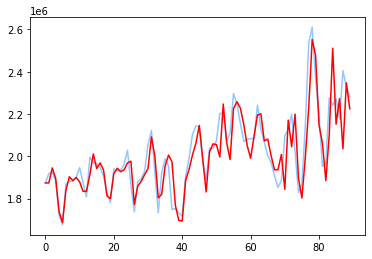

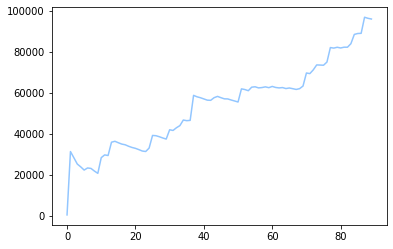

ARIMA(15, 0, 1) RMSE=95910  , actual best : (12, 1, 0) RMSE: 92350
(16, 0, 1)   step =  0


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1873157.681, Expected=1943332.000, RMSE = 1304
(16, 0, 1)   step =  1


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1871538.943, Expected=1943332.000, RMSE = 33103
(16, 0, 1)   step =  2


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1949808.444, Expected=1943332.000, RMSE = 30800
(16, 0, 1)   step =  3


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1891599.277, Expected=1943332.000, RMSE = 26980
(16, 0, 1)   step =  4


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Predicted=1738782.920, Expected=1943332.000, RMSE = 25492
(16, 0, 1)   step =  5


D:\appsserv\Anaconda3\envs\dev_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [ ]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    hist_rmse = list()
    
    #Evaluation préliminaire sur un petit échantillon
    test = test[:90]   
    
    for t in range(len(test)):
        print(arima_order,"  step = ",t)
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        #model_fit = model.fit(trend='nc', disp=0)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        hist_rmse.append(sqrt(mean_squared_error(test[:len(predictions)], predictions)))
        print('Predicted=%.3f, Expected=%.3f, RMSE = %.0f' % (yhat, obs, hist_rmse[-1]))
    
    plt.plot(test)
    plt.plot(predictions,'-r')
    plt.show()

    plt.plot(hist_rmse)
    plt.show()

    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for q in q_values:
        for d in d_values:
            for p in p_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.0f  , actual best : %s RMSE: %.0f' % (order,rmse, best_cfg,best_score))
                except:
                    print("error")
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
   
# load dataset
# evaluate parameters (p,d,q)  <=> (AR, I, MA)
p_values = range(0, 20)
d_values = range(0, 2)
q_values = range(0, 20)

evaluate_models(X, p_values, d_values, q_values)

actual best : (5, 1, 2) RMSE: 162768

#### Features historique par window

In [ ]:
# Nombre de jours de la Window
nb_jours_window = 30

# Création d'un tableau avec pour chaque ligne 
# l'historique de la consommation des nb_jours_window précédents et la consommation du lendemain 
# ==> [Total_j-nb_jours_window-1, ..., Total_j, Total_j+1]  

features = []
column_names = []
features_means = []
column_names_means = []

data_total = df_feature_total_per_day['Total'].copy()


for i in range(nb_jours_window,0,-1):
    shifted = data_total.shift(i)
    means = shifted.rolling(window=nb_jours_window).mean()
    # Features des Total_j
    features.append(shifted)
    column_names.append('Total_j-'+str(i-1))
    # Features des moyennes des  jours 
    features_means.append(means)
    column_names_means.append('mean_Total_j-'+str(i-1))
    

    
features.append(data_total)
column_names.append('Total_j+1')
df_features = pd.concat(features,axis=1)
df_features.columns = column_names

features_means.append(data_total)
column_names_means.append('Total_j+1')
df_features_means = pd.concat(features,axis=1)
df_features_means.columns = column_names_means


df_features.head(nb_jours_window+1)

In [ ]:
df_features = df_features[nb_jours_window:]
df_features.head()

In [ ]:
df_features_means = df_features[nb_jours_window:]
df_features_means.head()